**1. Выгрузка необходимых данных**

 **1.1 Получение данных из MOEX ISS**

В этом блоке вы можете ввести основные необходимые параметры: тикеры активов и временной прмоежуток. При изменении параметров нужно обязательно обновить кэшировние!

In [ ]:
import numpy as np
import pandas as pd
import requests
import os
from datetime import datetime
from pathlib import Path
import shutil


# =============================================================================
# ФУНКЦИЯ ВЫВОДА
# =============================================================================

def print_section(title: str):
    print("\n" + "=" * 100)
    print(title)
    print("=" * 100 + "\n")


# =============================================================================
# БЛОК 1: ЗАГРУЗКА ДАННЫХ С MOEX ISS
# =============================================================================

print_section("ЗАГРУЗКА ДАННЫХ С MOEX ISS")

# =============================================================================
# КОНФИГУРАЦИЯ
# =============================================================================

TICKERS = ['AFKS', 'AFLT', 'ALRS', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FLOT',
           'GAZP', 'GMKN', 'HEAD', 'IRAO', 'LKOH', 'MAGN', 'MDMG', 'MOEX',
           'MSNG', 'MTSS', 'NLMK', 'NVTK', 'PHOR', 'PIKK', 'PLZL', 'POSI',
           'RENI', 'ROSN', 'RTKM', 'RUAL', 'SBER', 'SNGS', 'SNGSP',
           'SVCB', 'T', 'TATN', 'TATNP', 'TRNFP', 'UGLD', 'UPRO', 'VKCO', 'VTBR',
           'X5', 'YDEX']
START_DATE = '2024-11-01'
END_DATE = '2025-11-01'

# Кэш для сохранения данных
CACHE_DIR = Path('./data_cache')

# =============================================================================
# 🔥 ОЧИСТКА КЭША (установите True чтобы перезагрузить данные)
# =============================================================================
FORCE_RELOAD = True  # 🔥 Установите True чтобы очистить кэш!

if FORCE_RELOAD and CACHE_DIR.exists():
    print("🗑️  Очищаю кэш...")
    shutil.rmtree(CACHE_DIR)
    print("   ✓ Кэш очищен\n")

CACHE_DIR.mkdir(exist_ok=True)

# =============================================================================
# ФУНКЦИИ ДЛЯ ЗАГРУЗКИ
# =============================================================================

def get_cache_path(ticker: str) -> Path:
    return CACHE_DIR / f"{ticker}_{START_DATE}_{END_DATE}.parquet"


def load_from_cache(ticker: str) -> pd.DataFrame:
    cache_path = get_cache_path(ticker)

    if cache_path.exists():
        try:
            df = pd.read_parquet(cache_path)
            print(f"   ✓ {ticker}: кэш ({len(df)} дней)")
            return df
        except:
            return None
    return None


def save_to_cache(ticker: str, df: pd.DataFrame) -> None:
    try:
        df.to_parquet(get_cache_path(ticker))
    except:
        pass


def fetch_from_moex_complete(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Загружает ВСЕ данные за период (полная пагинация).
    """
    url = (
        f"https://iss.moex.com/iss/history/engines/stock/markets/shares/"
        f"boards/TQBR/securities/{ticker}.json"
    )

    all_rows = []
    start_idx = 0
    columns = None

    print(f"   ↓ {ticker}...", end=" ", flush=True)

    while True:
        params = {
            'from': start_date,
            'till': end_date,
            'sort_order': 'asc',
            'start': start_idx
        }

        try:
            response = requests.get(url, params=params, timeout=15)
            response.raise_for_status()
            data = response.json()

            if 'history' not in data or 'data' not in data['history']:
                break

            rows = data['history']['data']

            if columns is None:
                columns = data['history']['columns']

            if len(rows) == 0:
                break

            all_rows.extend(rows)
            start_idx += len(rows)

            print(".", end="", flush=True)

        except Exception as e:
            print(f"✗ ERROR: {e}")
            return None

    if len(all_rows) == 0:
        print(f"✗ No data")
        return None

    print(f" ✓ ({len(all_rows)} rows)")

    try:
        df = pd.DataFrame(all_rows, columns=columns)
        df = df[['TRADEDATE', 'CLOSE']].copy()
        df.columns = ['Date', 'Close']

        df['Date'] = pd.to_datetime(df['Date'])
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

        df = df.drop_duplicates(subset=['Date'])
        df = df.dropna()
        df = df.sort_values('Date').reset_index(drop=True)

        return df
    except Exception as e:
        print(f"✗ Parse error: {e}")
        return None


def load_ticker_data(ticker: str) -> pd.DataFrame:
    print(f"📥 {ticker}:", end="")

    df = load_from_cache(ticker)

    if df is None:
        df = fetch_from_moex_complete(ticker, START_DATE, END_DATE)

        if df is None:
            print(f" ❌")
            return None

        save_to_cache(ticker, df)

    return df


# =============================================================================
# ЗАГРУЗКА ВСЕХ АКТИВОВ
# =============================================================================

print("=" * 100)
print("ЗАГРУЗКА ДАННЫХ")
print("=" * 100 + "\n")

print(f"⏰ Период: {START_DATE} → {END_DATE}")
print(f"📊 Активов: {len(TICKERS)}\n")

all_data = {}

for ticker in TICKERS:
    df = load_ticker_data(ticker)
    if df is not None:
        all_data[ticker] = df

print(f"\n✅ Loaded: {len(all_data)}/{len(TICKERS)}")

if len(all_data) == 0:
    raise ValueError("❌ Error: no data!")

# =============================================================================
# ДИАГНОСТИКА
# =============================================================================

print("\n" + "=" * 100)
print("📊 ДИАГНОСТИКА: Диапазон дат по активам")
print("=" * 100 + "\n")

for ticker in all_data:
    df = all_data[ticker]
    print(f"   {ticker:6s}: {df['Date'].min().date()} → {df['Date'].max().date()} ({len(df):3d} дней)")

# =============================================================================
# СИНХРОНИЗАЦИЯ ДАТ
# =============================================================================

print("\n" + "=" * 100)
print("СИНХРОНИЗАЦИЯ ДАТ")
print("=" * 100 + "\n")

valid_tickers = list(all_data.keys())
all_dates = set(all_data[valid_tickers[0]]['Date'])

for ticker in valid_tickers[1:]:
    all_dates = all_dates.intersection(set(all_data[ticker]['Date']))

print(f"📅 Общих дней: {len(all_dates)}")

for ticker in all_data:
    df = all_data[ticker]
    df = df[df['Date'].isin(all_dates)].sort_values('Date').reset_index(drop=True)
    all_data[ticker] = df

# =============================================================================
# ОБЪЕДИНЕНИЕ В ЕДИНЫЙ DATAFRAME
# =============================================================================

print("\n" + "=" * 100)
print("СОЗДАНИЕ ЕДИНОГО DATAFRAME")
print("=" * 100 + "\n")

first_ticker = valid_tickers[0]
priced_df = all_data[first_ticker][['Date', 'Close']].copy()
priced_df.columns = ['Date', first_ticker]

for ticker in valid_tickers[1:]:
    temp = all_data[ticker][['Date', 'Close']].copy()
    temp.columns = ['Date', ticker]
    priced_df = priced_df.merge(temp, on='Date', how='inner')

priced_df = priced_df.set_index('Date').sort_index()

print(f"✅ Размер: {priced_df.shape[0]} дней × {priced_df.shape[1]} активов")
print(f"   Период: {priced_df.index[0].date()} → {priced_df.index[-1].date()}")

# =============================================================================
# ПОДГОТОВКА К АНАЛИЗУ
# =============================================================================

asset_names = list(priced_df.columns)
n_assets = len(asset_names)
T = len(priced_df)

print("\n" + "=" * 100)
print("✅ БЛОК 1 ЗАВЕРШЁН")
print("=" * 100 + "\n")

print(f"💾 Переменные:")
print(f"   priced_df   : DataFrame цен ({priced_df.shape})")
print(f"   asset_names : {asset_names}")
print(f"   n_assets    : {n_assets}")
print(f"   T           : {T} дней")



ЗАГРУЗКА ДАННЫХ С MOEX ISS

ЗАГРУЗКА ДАННЫХ

⏰ Период: 2024-11-01 → 2025-11-01
📊 Активов: 42

📥 AFKS:   ↓ AFKS... ... ✓ (256 rows)
📥 AFLT:   ↓ AFLT... ... ✓ (256 rows)
📥 ALRS:   ↓ ALRS... ... ✓ (256 rows)
📥 BSPB:   ↓ BSPB... ... ✓ (256 rows)
📥 CBOM:   ↓ CBOM... ... ✓ (256 rows)
📥 CHMF:   ↓ CHMF... ... ✓ (256 rows)
📥 ENPG:   ↓ ENPG... ... ✓ (256 rows)
📥 FLOT:   ↓ FLOT... ... ✓ (256 rows)
📥 GAZP:   ↓ GAZP... ... ✓ (256 rows)
📥 GMKN:   ↓ GMKN... ... ✓ (256 rows)
📥 HEAD:   ↓ HEAD... ... ✓ (256 rows)
📥 IRAO:   ↓ IRAO... ... ✓ (256 rows)
📥 LKOH:   ↓ LKOH... ... ✓ (256 rows)
📥 MAGN:   ↓ MAGN... ... ✓ (256 rows)
📥 MDMG:   ↓ MDMG... ... ✓ (256 rows)
📥 MOEX:   ↓ MOEX... ... ✓ (256 rows)
📥 MSNG:   ↓ MSNG... ... ✓ (256 rows)
📥 MTSS:   ↓ MTSS... ... ✓ (256 rows)
📥 NLMK:   ↓ NLMK... ... ✓ (256 rows)
📥 NVTK:   ↓ NVTK... ... ✓ (256 rows)
📥 PHOR:   ↓ PHOR... ... ✓ (256 rows)
📥 PIKK:   ↓ PIKK... ... ✓ (256 rows)
📥 PLZL:   ↓ PLZL... ... ✓ (256 rows)
📥 POSI:   ↓ POSI... ... ✓ (256 rows)
📥 RENI:   ↓ RENI.

**1.1.1 Выгрузка данных на Google Drive для проверки**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#Меняйте траекторию на свою

priced_df.to_excel("gdrive/MyDrive/Cheremsha/sm2.xlsx")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**2. Работа с данными**

**2.1 Расчет ожидаемой доходности и корелляционной матрицы**


РАСЧЁТ ЛОГАРИФМИЧЕСКИХ ДОХОДНОСТЕЙ

📊 Исходные доходности: 201 дней × 42 активов

🔍 Детектор сплитов акций (обнаружение экстремальных доходностей):

⚠️  PLZL: обнаружены потенциальные сплиты:
   2025-03-27:  -232.07% (обратный сплит 0.10x)

✅ После обработки: 201 дней × 42 активов

РАСЧЁТ РЕАЛЬНОГО КОЛИЧЕСТВА ТОРГОВЫХ ДНЕЙ

📅 Статистика торговых дней:
   Период данных: 2025-01-09 → 2025-11-01
   Календарных дней: 296
   Торговых дней в выборке: 201
   Расчётное среднее торговых дней в год: 247
   Используется для аннуализации: 252 дней (стандарт)

КОВАРИАЦИОННАЯ МАТРИЦА И ОЖИДАЕМЫЕ ДОХОДНОСТИ


📊 Спектр матрицы ковариации:
   λ_min (наименьшее собственное значение): 4.26e-03
   λ_max (наибольшее собственное значение): 2.96e+00
   Число обусловленности (condition number): 6.95e+02

✅ Матрица положительно определена

📈 Ожидаемые годовые доходности (после очистки):

   🟢 PLZL  : μ =   45.98% | σ =   31.03%
   🟢 MDMG  : μ =   37.97% | σ =   24.69%
   🟢 NVTK  : μ =   14.49% | σ =   41.73%


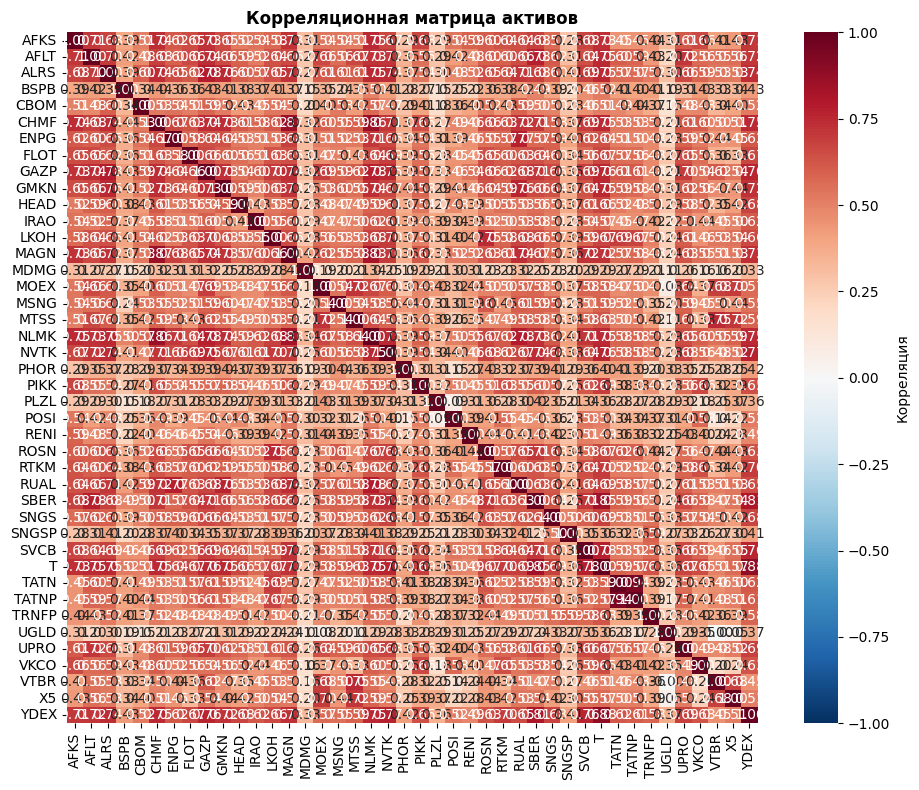

IndexError: index 10 is out of bounds for axis 0 with size 10

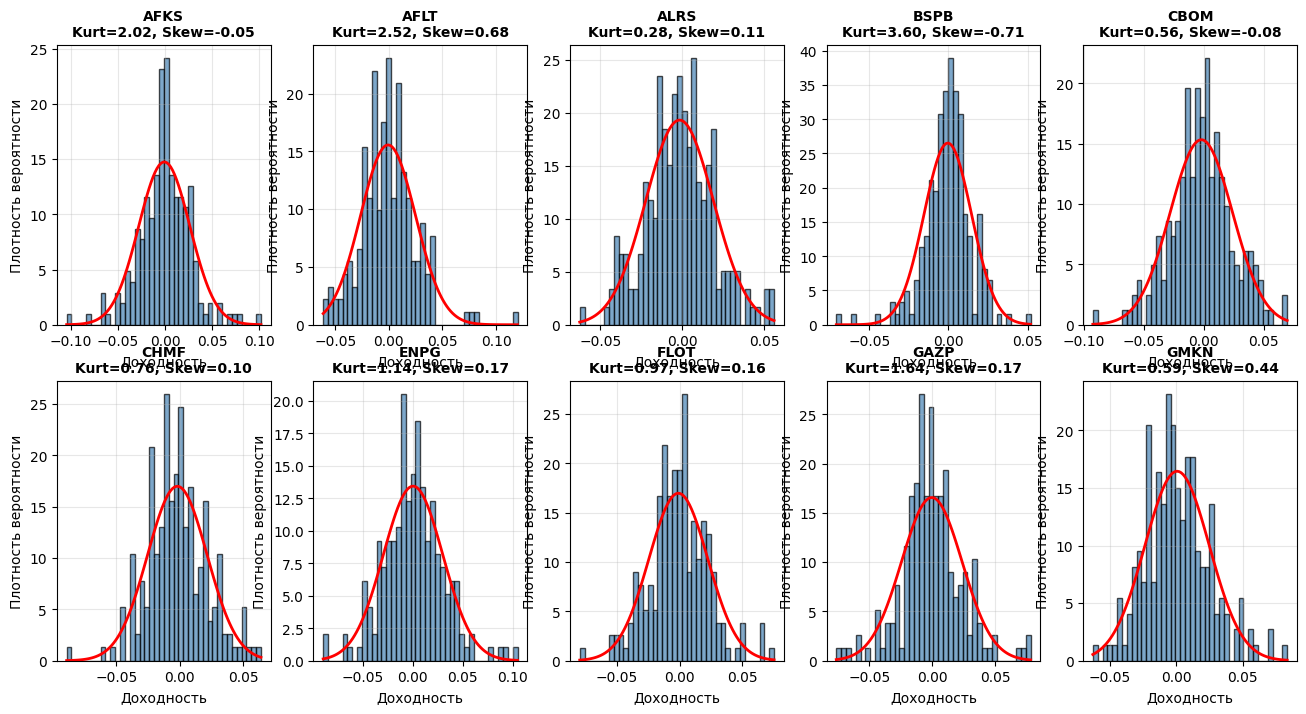

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


# =============================================================================
# БЛОК 2.1.1: ЛОГАРИФМИЧЕСКИЕ ДОХОДНОСТИ С ОБРАБОТКОЙ СПЛИТОВ
# =============================================================================

print_section("РАСЧЁТ ЛОГАРИФМИЧЕСКИХ ДОХОДНОСТЕЙ")

# Логарифмические доходности
returns_raw = np.log(priced_df / priced_df.shift(1)).dropna()

print(f"📊 Исходные доходности: {returns_raw.shape[0]} дней × {returns_raw.shape[1]} активов")

# =============================================================================
# ОБРАБОТКА СПЛИТОВ АКЦИЙ
# =============================================================================

print("\n🔍 Детектор сплитов акций (обнаружение экстремальных доходностей):\n")

returns = returns_raw.copy()
split_threshold = 0.70

splits_detected = {}

for ticker in returns.columns:
    # Находим дни с экстремальными доходностями
    extreme_days = np.abs(returns[ticker]) > split_threshold

    if extreme_days.any():
        extreme_returns = returns.loc[extreme_days, ticker]
        splits_detected[ticker] = extreme_returns

        print(f"⚠️  {ticker}: обнаружены потенциальные сплиты:")
        for date, ret in extreme_returns.items():
            ratio = np.exp(ret)  # Коэффициент сплита
            direction = "обратный" if ret < 0 else "прямой"
            print(f"   {date.date()}: {ret*100:>8.2f}% ({direction} сплит {ratio:.2f}x)")

        returns.loc[extreme_days, ticker] = np.nan

# Вместо полного dropna(), используем ffill() для заполнения пропусков
returns = returns.ffill()  # Forward-fill: берем последнее известное значение
returns = returns.dropna()  # Удаляем только начальные NaN

print(f"\n✅ После обработки: {returns.shape[0]} дней × {returns.shape[1]} активов")

# =============================================================================
# БЛОК 2.1.2: РАСЧЁТ РЕАЛЬНОГО КОЛИЧЕСТВА ТОРГОВЫХ ДНЕЙ
# =============================================================================

print_section("РАСЧЁТ РЕАЛЬНОГО КОЛИЧЕСТВА ТОРГОВЫХ ДНЕЙ")

# Реальное количество торговых дней в выборке
actual_trading_days = len(returns)

# Примерная экстраполяция на 365 дней (для аннуализации)
# Вычисляем среднее количество торговых дней в год на основе имеющихся данных
calendar_days = (priced_df.index[-1] - priced_df.index[0]).days
trading_days_per_year = int(actual_trading_days * 365 / max(calendar_days, 1))

# Для консервативной оценки используем 252 (стандарт), но выводим оба варианта
TRADING_DAYS = 252  # Стандартное значение для финансовых расчётов

print(f"📅 Статистика торговых дней:")
print(f"   Период данных: {priced_df.index[0].date()} → {priced_df.index[-1].date()}")
print(f"   Календарных дней: {calendar_days}")
print(f"   Торговых дней в выборке: {actual_trading_days}")
print(f"   Расчётное среднее торговых дней в год: {trading_days_per_year}")
print(f"   Используется для аннуализации: {TRADING_DAYS} дней (стандарт)")

# =============================================================================
# БЛОК 2.1.3: КОВАРИАЦИОННАЯ МАТРИЦА И ПРОВЕРКА КАЧЕСТВА
# =============================================================================

print_section("КОВАРИАЦИОННАЯ МАТРИЦА И ОЖИДАЕМЫЕ ДОХОДНОСТИ")

# Ковариационная матрица (дневная)
cov_matrix_daily = returns.cov()

# Ковариационная матрица (годовая)
cov_matrix = cov_matrix_daily * TRADING_DAYS

# Корреляционная матрица
correlation_matrix = returns.corr()

# Проверка положительной определённости
eigenvalues = np.linalg.eigvalsh(cov_matrix.values)
min_eig = eigenvalues.min()
max_eig = eigenvalues.max()

print(f"\n📊 Спектр матрицы ковариации:")
print(f"   λ_min (наименьшее собственное значение): {min_eig:.2e}")
print(f"   λ_max (наибольшее собственное значение): {max_eig:.2e}")
print(f"   Число обусловленности (condition number): {max_eig / min_eig:.2e}")

if min_eig > 1e-10:
    print(f"\n✅ Матрица положительно определена")
else:
    print(f"\n⚠️  Матрица близка к вырожденной!")
    print("   Возможные причины:")
    print("   - Недостаточно данных (T < n_assets)")
    print("   - Высокая мультиколлинеарность")
    print("   - Ошибки при расчете ковариации")
    print("\n   ➜ Рекомендация: использовать Ledoit-Wolf shrinkage")

    # Применяем Ledoit-Wolf вместо слепой регуляризации
    try:
        from sklearn.covariance import LedoitWolf
        lw = LedoitWolf()
        cov_matrix_shrunk = lw.fit(returns.values).covariance_
        cov_matrix = pd.DataFrame(
            cov_matrix_shrunk,
            index=cov_matrix.index,
            columns=cov_matrix.columns
        )
        print("\n✅ Применен Ledoit-Wolf shrinkage")

        # Проверяем, стала ли матрица PD
        eigenvalues_shrunk = np.linalg.eigvalsh(cov_matrix.values)
        print(f"   λ_min после shrinkage: {eigenvalues_shrunk.min():.2e}")
    except ImportError:
        print("\n⚠️  sklearn не установлен, применяю базовую регуляризацию")
        cov_matrix = cov_matrix + np.eye(len(cov_matrix)) * abs(min_eig) * 1.1

# Ожидаемые доходности (аннуализированные)
mu = returns.mean() * TRADING_DAYS

# Расчет годовой волатильности
annual_vol = returns.std() * np.sqrt(TRADING_DAYS)

print(f"\n📈 Ожидаемые годовые доходности (после очистки):\n")
for ticker in mu.sort_values(ascending=False).index:
    emoji = "🟢" if mu[ticker] > 0 else "🔴"
    print(f"   {emoji} {ticker:6s}: μ = {mu[ticker]*100:>7.2f}% | σ = {annual_vol[ticker]*100:>7.2f}%")

# Диагностика корреляций
corr_values = correlation_matrix.values
upper_tri = np.triu_indices(len(corr_values), k=1)
high_corr_mask = np.abs(corr_values[upper_tri]) > 0.95

if high_corr_mask.any():
    print(f"\n⚠️  Высокие корреляции (|ρ| > 0.95) — возможна мультиколлинеарность:")
    tickers = correlation_matrix.columns.tolist()
    for idx in np.where(high_corr_mask)[0]:
        i, j = upper_tri[0][idx], upper_tri[1][idx]
        print(f"   {tickers[i]:6s} ↔ {tickers[j]:6s}: ρ = {corr_values[i, j]:.4f}")
else:
    print(f"\n✅ Мультиколлинеарности не обнаружено (все |ρ| < 0.95)")

# =============================================================================
# БЛОК 2.1.4: АНАЛИЗ РАСПРЕДЕЛЕНИЙ (КУРТОЗИС И АСИММЕТРИЯ)
# =============================================================================

print_section("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ДОХОДНОСТЕЙ")

# Расчёт куртозиса (эксцесса) и асимметрии
kurtosis_values = returns.kurtosis()
skewness_values = returns.skew()

print(f"📊 Статистика распределений доходностей:\n")
print(f"   Активы отсортированы по куртозису (убывающий):\n")

for ticker in kurtosis_values.sort_values(ascending=False).index:
    kurt = kurtosis_values[ticker]
    skew = skewness_values[ticker]

    # Интерпретация куртозиса (эксцесс куртозиса для нормального распределения = 3)
    if kurt > 5:
        kurt_level = "очень высокий (тяжёлые хвосты)"
    elif kurt > 3.5:
        kurt_level = "высокий (тяжелее, чем нормальное)"
    elif kurt > 2.5:
        kurt_level = "нормальный"
    else:
        kurt_level = "низкий (лёгкие хвосты)"

    # Интерпретация асимметрии
    if abs(skew) < 0.1:
        skew_level = "симметричное"
    elif skew > 0.5:
        skew_level = "положительный перекос (правый хвост)"
    elif skew < -0.5:
        skew_level = "отрицательный перекос (левый хвост)"
    else:
        skew_level = "слабый перекос"

    print(f"   {ticker:6s}:")
    print(f"      Куртозис (эксцесс): {kurt:>7.3f} — {kurt_level}")
    print(f"      Асимметрия (skew): {skew:>7.3f} — {skew_level}")

# Средние значения
mean_kurtosis = kurtosis_values.mean()
mean_skewness = skewness_values.mean()

print(f"\n   Средние по портфелю:")
print(f"      Средний куртозис: {mean_kurtosis:.3f}")
print(f"      Средняя асимметрия: {mean_skewness:.3f}")

if mean_kurtosis > 3:
    print(f"\n   ⚠️  ВАЖНО: Портфель имеет ТЯЖЁЛЫЕ ХВОСТЫ (куртозис > 3)")
    print(f"      → Риск экстремальных движений выше, чем предсказывает нормальное распределение")
    print(f"      → При оценке VaR и стресс-тестах учитывать вероятность больших убытков")

if abs(mean_skewness) > 0.2:
    if mean_skewness > 0:
        print(f"\n   ⚠️  Портфель имеет положительный ПЕРЕКОС (skew > 0)")
        print(f"      → Больше частых малых убытков и реже большие прибыли")
    else:
        print(f"\n   ⚠️  Портфель имеет отрицательный ПЕРЕКОС (skew < 0)")
        print(f"      → Больше частых малых прибылей и реже большие убытки")

# =============================================================================
# ПРОВЕРКА НА ВЫБРОСЫ
# =============================================================================

print("\n🔍 Диагностика выбросов:\n")
extreme_threshold = 3  # 3 sigma
extreme_days_before = (np.abs(returns_raw) > extreme_threshold * returns_raw.std()).any(axis=1).sum()
extreme_days_after = (np.abs(returns) > extreme_threshold * returns.std()).any(axis=1).sum()

print(f"   До очистки сплитов: {extreme_days_before} дней с доходностями > 3σ")
print(f"   После очистки сплитов: {extreme_days_after} дней с доходностями > 3σ")

# =============================================================================
# ВИЗУАЛИЗАЦИЯ: КОРРЕЛЯЦИОННАЯ МАТРИЦА
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, ax=ax,
            cbar_kws={'label': 'Корреляция'})
ax.set_title('Корреляционная матрица активов', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

# =============================================================================
# ВИЗУАЛИЗАЦИЯ: РАСПРЕДЕЛЕНИЕ ДОХОДНОСТЕЙ (ГИСТОГРАММЫ С КРИВОЙ НОРМАЛЬНОГО РАСПРЕДЕЛЕНИЯ)
# =============================================================================

fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.flatten()

for idx, ticker in enumerate(asset_names):
    ax = axes[idx]

    data = returns[ticker]
    mean_ret = data.mean()
    std_ret = data.std()

    # Гистограмма
    ax.hist(data, bins=40, density=True, alpha=0.7, color='steelblue', edgecolor='black')

    # Нормальная кривая
    x = np.linspace(data.min(), data.max(), 100)
    from scipy.stats import norm
    ax.plot(x, norm.pdf(x, mean_ret, std_ret), 'r-', linewidth=2, label='Normal fit')

    # Статистика
    kurt = data.kurtosis()
    skew = data.skew()
    ax.set_title(f'{ticker}\nKurt={kurt:.2f}, Skew={skew:.2f}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Доходность')
    ax.set_ylabel('Плотность вероятности')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('returns_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

# =============================================================================
# ИТОГ
# =============================================================================

print("\n" + "=" * 100)
print("✅ БЛОК 2.1-2.2 ЗАВЕРШЁН")
print("=" * 100 + "\n")

print(f"💾 Переменные:")
print(f"   returns            : {returns.shape} — лог-доходности (очищенные)")
print(f"   cov_matrix         : {cov_matrix.shape} — годовая ковариация")
print(f"   correlation_matrix : {correlation_matrix.shape} — корреляции")
print(f"   mu                 : ({len(mu)},) — ожидаемые годовые доходности")
print(f"   annual_vol         : ({len(annual_vol)},) — годовая волатильность")
print(f"   asset_names        : {asset_names}")
print(f"\n📊 Статистика:")
print(f"   Средняя доходность: {mu.mean()*100:.2f}%")
print(f"   Средняя волатильность: {annual_vol.mean()*100:.2f}%")
print(f"   Средняя корреляция: {correlation_matrix.values[upper_tri].mean():.4f}")
print(f"   Средний куртозис: {kurtosis_values.mean():.3f}")
print(f"   Средняя асимметрия: {skewness_values.mean():.3f}")

**2.2 Использование GARCH для определения волатильности**

In [ ]:
!pip install arch
import numpy as np
import pandas as pd
import warnings
from arch import arch_model
warnings.filterwarnings('ignore')

# =============================================================================
# БЛОК 2.2: КАЛИБРОВКА GARCH(1,1) И ФИЛЬТРАЦИЯ АКТИВОВ
# =============================================================================
"""
GARCH(1,1): σ²_t = ω + α·ε²_{t-1} + β·σ²_{t-1}

Долгосрочная волатильность: σ_∞ = √(ω / (1 - α - β))
Условие стационарности: α + β < 0.995 (консервативно)
"""

print_section("КАЛИБРОВКА GARCH(1,1)")


ANNUALIZATION_FACTOR = np.sqrt(252)
MIN_OBS = 100  # Минимум наблюдений для надежной калибровки
PERSISTENCE_THRESHOLD = 0.995
ALPHA_MIN_THRESHOLD = 1e-8  #мягкий порог для α (не ноль, но очень маленький)


print(f"📊 Параметры: {returns.shape[1]} активов, {returns.shape[0]} наблюдений\n")


garch_params = {}
long_run_vols = {}
conditional_vols = {}
failed_tickers = []


# =============================================================================
# КАЛИБРОВКА
# =============================================================================


for ticker in returns.columns:
    try:
        # Используем натуральные единицы (decimals, не проценты)
        r = returns[ticker].dropna()


        if len(r) < MIN_OBS:
            failed_tickers.append(ticker)
            long_run_vols[ticker] = np.nan
            conditional_vols[ticker] = np.nan
            print(f"⚠️  {ticker}: недостаточно данных ({len(r)} < {MIN_OBS})")
            continue


        # Используем rescale=False для прямой интерпретации параметров
        # Натуральные единицы + rescale=False = параметры в исходной шкале
        model = arch_model(r, vol='Garch', p=1, q=1, rescale=False)
        fitted = model.fit(disp='off', show_warning=False)


        # Проверка сходимости оптимизации
        if fitted.convergence_flag != 0:
            failed_tickers.append(ticker)
            long_run_vols[ticker] = np.nan
            conditional_vols[ticker] = np.nan
            print(f"❌ {ticker}: оптимизация не сошлась (flag={fitted.convergence_flag})")
            continue


        omega = fitted.params['omega']
        alpha = fitted.params['alpha[1]']
        beta = fitted.params['beta[1]']
        persistence = alpha + beta


        # Мягкая проверка параметров
        # Допускаем очень маленький α (почти ноль), но не отрицательный
        if omega <= 0 or alpha < -1e-10 or beta < -1e-10:
            failed_tickers.append(ticker)
            long_run_vols[ticker] = np.nan
            conditional_vols[ticker] = np.nan
            print(f"❌ {ticker}: отрицательные/некорректные параметры (ω={omega:.2e}, α={alpha:.2e}, β={beta:.2e})")
            continue


        # Если α очень близко к нулю, используем Sample волатильность
        if alpha < ALPHA_MIN_THRESHOLD:
            failed_tickers.append(ticker)
            long_run_vols[ticker] = np.nan
            conditional_vols[ticker] = np.nan
            print(f"⚠️  {ticker}: α практически нулевой ({alpha:.2e}), модель неадекватна")
            continue


        # Проверка стационарности
        is_stationary = (persistence < PERSISTENCE_THRESHOLD)


        if is_stationary:
            # Правильный расчет долгосрочной волатильности
            # Формула: σ_∞ = √(ω / (1 - α - β)) * √252 * 100
            long_run_vol = np.sqrt(omega / (1 - persistence)) * ANNUALIZATION_FACTOR * 100

            # Среднее условной волатильности как альтернатива
            cond_vol_mean = fitted.conditional_volatility.mean() * ANNUALIZATION_FACTOR * 100

            status = "✅"
        else:
            long_run_vol = np.nan
            cond_vol_mean = np.nan
            status = "❌"
            failed_tickers.append(ticker)


        garch_params[ticker] = {
            'omega': omega, 'alpha': alpha, 'beta': beta, 'persistence': persistence
        }
        long_run_vols[ticker] = long_run_vol
        conditional_vols[ticker] = cond_vol_mean


        # Сравнение с выборочной волатильностью
        sample_vol = annual_vol[ticker] * 100

        # Информация о качестве подгонки
        aic = fitted.aic
        bic = fitted.bic

        # Расчет разницы в процентах (более разумно)
        if sample_vol > 0.01:  # Не делим на очень маленькие числа
            ratio = long_run_vol / sample_vol
            ratio_str = f"({ratio:.2f}x)"
        else:
            ratio_str = "(N/A)"


        pers_str = f"α+β={persistence:.4f}"
        vol_str = f"{long_run_vol:.2f}%"
        comp_str = f"Sample={sample_vol:.2f}% {ratio_str}"

        print(f"{status} {ticker}: {pers_str} → σ_∞={vol_str} | {comp_str}")
        print(f"           AIC={aic:.1f}, BIC={bic:.1f} | α={alpha:.2e}, β={beta:.4f}")


    except Exception as e:
        failed_tickers.append(ticker)
        long_run_vols[ticker] = np.nan
        conditional_vols[ticker] = np.nan
        error_msg = str(e)[:60] if str(e) else "Unknown error"
        print(f"❌ {ticker}: {error_msg}")


# =============================================================================
# РЕЗУЛЬТАТЫ И ФИЛЬТРАЦИЯ
# =============================================================================


print_section("ФИЛЬТРАЦИЯ И РЕЗУЛЬТАТЫ")


long_run_vols_series = pd.Series(long_run_vols)
conditional_vols_series = pd.Series(conditional_vols)
valid_vols = long_run_vols_series.dropna()


n_total = len(returns.columns)
n_valid = len(valid_vols)


print(f"📊 Статистика:")
print(f"   Всего активов: {n_total}")
print(f"   Успешно откалибровано GARCH: {n_valid} ({n_valid/n_total*100:.0f}%)")
print(f"   Проблемных/неадекватных: {len(failed_tickers)} ({len(failed_tickers)/n_total*100:.0f}%)")


if len(valid_vols) > 0:
    print(f"\n📈 Долгосрочные волатильности (σ_∞) из GARCH:\n")
    for ticker in valid_vols.sort_values(ascending=False).index:
        sample_vol = annual_vol[ticker] * 100
        garch_vol = valid_vols[ticker]
        ratio = garch_vol / sample_vol if sample_vol > 1.0 else 0
        print(f"   {ticker:6s}: σ_∞={garch_vol:>6.2f}% | Sample={sample_vol:>6.2f}% | Ratio={ratio:>5.2f}x")


# =============================================================================
# Детектор проблемных активов
# =============================================================================


print(f"\n🚨 Диагностика проблемных активов:\n")


if len(garch_params) > 0:
    params_df = pd.DataFrame(garch_params).T

    for ticker in failed_tickers:
        if ticker in params_df.index:
            pers = params_df.loc[ticker, 'persistence']
            omega = params_df.loc[ticker, 'omega']
            alpha = params_df.loc[ticker, 'alpha']
            beta = params_df.loc[ticker, 'beta']

            if pers >= PERSISTENCE_THRESHOLD:
                print(f"   {ticker}: нестационарна (α+β={pers:.4f} ≥ {PERSISTENCE_THRESHOLD})")
            elif alpha < ALPHA_MIN_THRESHOLD:
                print(f"   {ticker}: α практически нулевой ({alpha:.2e}) → ARCH компонента отсутствует")
            elif not (omega > 0):
                print(f"   {ticker}: ω ≤ 0 ({omega:.2e})")
            else:
                print(f"   {ticker}: другая причина")
        else:
            print(f"   {ticker}: недостаточно данных или ошибка оптимизации")
else:
    print("   ⚠️  Нет успешно откалиброванных активов")


# =============================================================================
# ИСПОЛЬЗОВАНИЕ GARCH ВОЛАТИЛЬНОСТЕЙ
# =============================================================================

# Создаем финальный вектор волатильностей
# Стратегия: если GARCH сошелся и адекватен, используем его; иначе используем Sample

print_section("ИТОГОВЫЕ ВОЛАТИЛЬНОСТИ")


volatilities_final = {}
garch_usage = {}

for ticker in returns.columns:
    if not np.isnan(long_run_vols[ticker]):
        # GARCH успешно откалиброван и адекватен
        volatilities_final[ticker] = long_run_vols[ticker]
        garch_usage[ticker] = "GARCH"
    else:
        # Fallback: используем выборочную волатильность
        volatilities_final[ticker] = annual_vol[ticker] * 100
        garch_usage[ticker] = "Sample"


volatilities_final_series = pd.Series(volatilities_final)


print(f"\n📊 Финальные волатильности:\n")
for ticker in volatilities_final_series.sort_values(ascending=False).index:
    source = garch_usage[ticker]
    symbol = "📊" if source == "GARCH" else "📈"
    print(f"   {symbol} {ticker:6s}: {volatilities_final_series[ticker]:>6.2f}% [{source}]")


print(f"\n   Используется GARCH: {sum(1 for x in garch_usage.values() if x == 'GARCH')}/{n_total}")
print(f"   Используется Sample (fallback): {sum(1 for x in garch_usage.values() if x == 'Sample')}/{n_total}")


# =============================================================================
# СОХРАНЕНИЕ
# =============================================================================


print("\n" + "=" * 100)
print("✅ БЛОК 2.3 ЗАВЕРШЁН")
print("=" * 100 + "\n")


garch_results = {
    'params': pd.DataFrame(garch_params).T if len(garch_params) > 0 else pd.DataFrame(),
    'long_run_vols': long_run_vols_series,
    'conditional_vols': conditional_vols_series,
    'volatilities_final': volatilities_final_series,
    'garch_usage': garch_usage,
    'failed_tickers': failed_tickers
}


print(f"💾 Переменные:")
print(f"   garch_results['params']           : параметры GARCH (ω, α, β, persistence)")
print(f"   garch_results['long_run_vols']    : долгосрочные волатильности σ_∞")
print(f"   garch_results['conditional_vols'] : средние условные волатильности")
print(f"   garch_results['volatilities_final'] : финальные волатильности (GARCH + Sample)")
print(f"   garch_results['garch_usage']      : источник каждой волатильности")
print(f"   garch_results['failed_tickers']   : список неудачных активов\n")
print(f"💾 ИТОГО:")
print(f"   ✅ Успешно откалибровано: {n_valid}/{n_total}")
print(f"   ⚠️  Используется Sample fallback: {n_total - n_valid}/{n_total}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.4 MB/s eta 0:00:00

КАЛИБРОВКА GARCH(1,1)

📊 Параметры: 42 активов, 201 наблюдений

✅ AFKS: α+β=0.9714 → σ_∞=44.91% | Sample=42.94% (1.05x)
           AIC=-881.5, BIC=-868.2 | α=5.88e-02, β=0.9125
✅ AFLT: α+β=0.7936 → σ_∞=40.63% | Sample=40.70% (1.00x)
           AIC=-900.5, BIC=-887.3 | α=8.77e-02, β=0.7060
✅ ALRS: α+β=0.9800 → σ_∞=32.66% | Sample=32.77% (1.00x)
           AIC=-984.4, BIC=-971.2 | α=1.00e-02, β=0.9700
⚠️  BSPB: α практически нулевой (0.00e+00), модель неадекватна
✅ CBOM: α+β=0.8893 → σ_∞=42.28% | Sample=41.33% (1.02x)
           AIC=-902.5, BIC=-889.3 | α=1.61e-01, β=0.7280
✅ CHMF: α+β=0.9721 → σ_∞=35.54% | Sample=37.28% (0.95x)
           AIC=-937.8, BIC=-924.5 | α=3.27e-02, β=0.9394
✅ ENPG: α+β=0.7667 → σ_∞=47.03% | Sample=47.15% (1.00x)
           AIC=-839.0, BIC=-825.8 | α=5.96e-02, β=0.7071
✅ FLOT: α+β=0.6875 → σ_∞=37.00% | Sample=37.33% (0.99x)
           AIC=-935.6, BIC=-922.4 | α=1.06e-01, β=0.5816


**2.3 Ограничение выборки по нестабильным активам из расчетов GARCH (1,1), а также ограничение на волатильность**

В этом блоке можно изменять параметры фильтрации активов: максимальную волатильность, минимальное количество наблюдений по каждому активу, а также максималльный уровень корреляции для исключения дубликатов

In [ ]:
import numpy as np
import pandas as pd
import warnings


warnings.filterwarnings('ignore')



# =============================================================================
# БЛОК 2.3: ФИЛЬТРАЦИЯ АКТИВОВ ПОРТФЕЛЯ
# =============================================================================


print_section("ФИЛЬТРАЦИЯ АКТИВОВ ПОРТФЕЛЯ")


# =============================================================================
# ПАРАМЕТРЫ ФИЛЬТРАЦИИ
# =============================================================================


MIN_OBSERVATIONS = 100
MAX_VOLATILITY = 50.0
MAX_CORRELATION = 0.98
MIN_PORTFOLIO_SIZE = 3


print(f"⚙️  Параметры фильтрации:")
print(f"   MIN_OBS={MIN_OBSERVATIONS}, MAX_VOL={MAX_VOLATILITY}%, MAX_CORR={MAX_CORRELATION}\n")


# =============================================================================
# ПОДГОТОВКА ДАННЫХ ИЗ GARCH БЛОКА
# =============================================================================

# Используем финальные волатильности (GARCH + Sample fallback)
volatilities_final = garch_results['volatilities_final']
garch_params = garch_results['params']
garch_usage = garch_results['garch_usage']
failed_tickers = garch_results['failed_tickers']


# Проверка наличия GARCH параметров
n_garch_success = len(garch_params)
print(f"📊 Из блока 2.3:")
print(f"   Успешно GARCH: {n_garch_success}")
print(f"   Sample fallback: {len(returns.columns) - n_garch_success}\n")


# =============================================================================
# ЭТАП 1: БАЗОВАЯ ФИЛЬТРАЦИЯ
# =============================================================================


print("=" * 100)
print("ЭТАП 1: БАЗОВАЯ ФИЛЬТРАЦИЯ")
print("=" * 100 + "\n")


initial_assets = returns.columns.tolist()
assets_to_keep = []
removed = {}


for ticker in initial_assets:
    reasons = []

    # Единственное количество наблюдений для всех (после синхронизации в блоке 1)
    n_obs = len(returns)

    # Проверка 1: Количество наблюдений
    if n_obs < MIN_OBSERVATIONS:
        reasons.append(f"n_obs={n_obs}")

    # Проверка 2: Волатильность доступна
    # Используем финальные волатильности
    if ticker not in volatilities_final.index or pd.isna(volatilities_final[ticker]):
        reasons.append("vol=NaN")
    else:
        vol = volatilities_final[ticker]

        # Проверка 3: GARCH стационарна (если были параметры)
        # Проверка пустоты garch_params
        if len(garch_params) > 0 and ticker in garch_params.index:
            persistence = garch_params.loc[ticker, 'persistence']
            if persistence >= 0.995:
                reasons.append("non-stationary")

        # Проверка 4: Волатильность в пределах
        if vol > MAX_VOLATILITY:
            reasons.append(f"σ={vol:.1f}%")

    # Итог для этого актива
    if reasons:
        removed[ticker] = reasons
        print(f"❌ {ticker}: {' | '.join(reasons)}")
    else:
        assets_to_keep.append(ticker)
        source = garch_usage.get(ticker, "unknown")
        vol = volatilities_final[ticker]
        print(f"✅ {ticker}: σ={vol:>6.2f}% | n={n_obs:>3d} | [{source}]")


print(f"\n📊 Этап 1: {len(assets_to_keep)}/{len(initial_assets)} активов прошли базовую фильтрацию\n")


# Ранняя проверка на достаточность активов
if len(assets_to_keep) < 2:
    print(f"⚠️  Слишком мало активов после базовой фильтрации: {len(assets_to_keep)}")
    print(f"   Попробуйте ослабить критерии: MAX_VOL={MAX_VOLATILITY}, MAX_CORR={MAX_CORRELATION}, MIN_OBS={MIN_OBSERVATIONS}")


# =============================================================================
# ЭТАП 2: УДАЛЕНИЕ ДУБЛИКАТОВ (ВЫСОКАЯ КОРРЕЛЯЦИЯ)
# =============================================================================


print("=" * 100)
print("ЭТАП 2: УДАЛЕНИЕ ДУБЛИКАТОВ")
print("=" * 100 + "\n")


duplicates_removed = []


if len(assets_to_keep) >= 2:
    corr_matrix = returns[assets_to_keep].corr()

    # Поиск пар с высокой корреляцией
    high_corr_found = False

    for i in range(len(assets_to_keep)):
        for j in range(i + 1, len(assets_to_keep)):
            ticker_i = assets_to_keep[i]
            ticker_j = assets_to_keep[j]

            # Пропускаем уже удаленные активы
            if ticker_i in duplicates_removed or ticker_j in duplicates_removed:
                continue

            corr = abs(corr_matrix.loc[ticker_i, ticker_j])

            if corr > MAX_CORRELATION:
                high_corr_found = True

                # Удаляем более волатильный
                vol_i = volatilities_final[ticker_i]
                vol_j = volatilities_final[ticker_j]

                if vol_i > vol_j:
                    removed_ticker = ticker_i
                    kept_ticker = ticker_j
                else:
                    removed_ticker = ticker_j
                    kept_ticker = ticker_i

                duplicates_removed.append(removed_ticker)
                removed[removed_ticker] = [f"dup_{kept_ticker}_ρ={corr:.3f}"]

                print(f"❌ {removed_ticker} ↔ {kept_ticker}: ρ={corr:.3f} (удален {removed_ticker}, σ={volatilities_final[removed_ticker]:.2f}%)")

    # Обновляем список активов
    assets_to_keep = [t for t in assets_to_keep if t not in duplicates_removed]

    if duplicates_removed:
        print(f"\n📊 Удалено дубликатов: {len(duplicates_removed)}\n")
    else:
        print(f"✅ Дубликатов не найдено\n")
else:
    print(f"⚠️  Недостаточно активов для проверки корреляций (найдено {len(assets_to_keep)})\n")


# =============================================================================
# ЭТАП 3: ФИНАЛЬНАЯ ПРОВЕРКА РАЗМЕРА ПОРТФЕЛЯ
# =============================================================================


print("=" * 100)
print("ФИНАЛЬНАЯ ПРОВЕРКА")
print("=" * 100 + "\n")


if len(assets_to_keep) < MIN_PORTFOLIO_SIZE:
    error_msg = (
        f"❌ ОШИБКА: Недостаточно активов для оптимизации!\n"
        f"   Требуется минимум: {MIN_PORTFOLIO_SIZE}\n"
        f"   Найдено: {len(assets_to_keep)}\n\n"
        f"   Ослабьте критерии фильтрации:\n"
        f"   - MAX_VOLATILITY: {MAX_VOLATILITY}% → увеличить\n"
        f"   - MAX_CORRELATION: {MAX_CORRELATION} → увеличить\n"
        f"   - MIN_OBSERVATIONS: {MIN_OBSERVATIONS} → уменьшить"
    )
    raise ValueError(error_msg)


print(f"✅ Размер портфеля адекватен: {len(assets_to_keep)} активов (требуется {MIN_PORTFOLIO_SIZE})\n")


# =============================================================================
# ЭТАП 4: ФОРМИРОВАНИЕ ИТОГОВЫХ ДАННЫХ
# =============================================================================


print("=" * 100)
print("ФИНАЛЬНЫЙ ПОРТФЕЛЬ")
print("=" * 100 + "\n")


# Отфильтрованные данные
filtered_returns = returns[assets_to_keep].copy()
filtered_cov = cov_matrix.loc[assets_to_keep, assets_to_keep].copy()
filtered_mu = mu[assets_to_keep].copy()
filtered_annual_vol = annual_vol[assets_to_keep].copy()
filtered_garch_vols = volatilities_final[assets_to_keep].copy()
filtered_names = assets_to_keep


# Валидация размера данных
print(f"📊 Размер данных:")
print(f"   Возвращаемость: {filtered_returns.shape}")
print(f"   Ковариация: {filtered_cov.shape}")
print(f"   Активов: {len(filtered_names)}\n")


# Валидация ковариационной матрицы
eigenvalues = np.linalg.eigvalsh(filtered_cov.values)
min_eig = eigenvalues.min()
max_eig = eigenvalues.max()
condition_number = max_eig / min_eig if min_eig > 0 else np.inf


status = "✅" if min_eig > 1e-10 else "⚠️ "
print(f"{status} Ковариационная матрица:")
print(f"   λ_min = {min_eig:.2e}")
print(f"   λ_max = {max_eig:.2e}")
print(f"   Condition number = {condition_number:.2e}\n")


# Статистика активов в портфеле
print(f"📊 Активы в портфеле ({len(filtered_names)}):\n")

for ticker in filtered_garch_vols.sort_values(ascending=False).index:
    vol_garch = filtered_garch_vols[ticker]
    vol_sample = filtered_annual_vol[ticker]
    ret = filtered_mu[ticker]
    source = garch_usage.get(ticker, "unknown")

    # Определяем emoji для доходности
    emoji_ret = "🟢" if ret > 0 else "🔴"
    # Определяем emoji для источника волатильности
    emoji_src = "📊" if source == "GARCH" else "📈"

    print(f"   {emoji_ret} {emoji_src} {ticker:6s}: σ={vol_garch:>6.2f}% (Sample: {vol_sample:>6.2f}%), μ={ret*100:>7.2f}% [{source}]")


print(f"\n📈 Статистика волатильностей:")
print(f"   Min:    {filtered_garch_vols.min():>6.2f}%")
print(f"   Median: {filtered_garch_vols.median():>6.2f}%")
print(f"   Mean:   {filtered_garch_vols.mean():>6.2f}%")
print(f"   Max:    {filtered_garch_vols.max():>6.2f}%")


print(f"\n📈 Статистика доходностей:")
print(f"   Min:    {filtered_mu.min()*100:>7.2f}%")
print(f"   Mean:   {filtered_mu.mean()*100:>7.2f}%")
print(f"   Max:    {filtered_mu.max()*100:>7.2f}%")


# Финальный отчет об удаленных активах
if removed:
    print(f"\n❌ Удалено активов: {len(removed)}")
    print(f"   Причины удаления:")

    for ticker in sorted(removed.keys()):
        reasons = removed[ticker]
        reasons_str = " | ".join(reasons)
        print(f"   - {ticker}: {reasons_str}")


# Статистика источников волатильностей
n_garch = sum(1 for x in filtered_garch_vols.index if garch_usage.get(x) == "GARCH")
n_sample = len(filtered_names) - n_garch

print(f"\n📊 Источники волатильностей в итоговом портфеле:")
print(f"   GARCH: {n_garch}/{len(filtered_names)}")
print(f"   Sample (fallback): {n_sample}/{len(filtered_names)}")


# =============================================================================
# СОХРАНЕНИЕ
# =============================================================================


print("\n" + "=" * 100)
print("✅ БЛОК 2.4 ЗАВЕРШЁН")
print("=" * 100 + "\n")


print(f"💾 Переменные:")
print(f"   filtered_returns     : {filtered_returns.shape} — лог-доходности")
print(f"   filtered_cov         : {filtered_cov.shape} — ковариационная матрица (годовая)")
print(f"   filtered_mu          : ({len(filtered_mu)},) — ожидаемые доходности")
print(f"   filtered_annual_vol  : ({len(filtered_annual_vol)},) — Sample волатильности")
print(f"   filtered_garch_vols  : ({len(filtered_garch_vols)},) — финальные волатильности (GARCH + Sample)")
print(f"   filtered_names       : {filtered_names}")
print(f"\n💾 Итого:")
print(f"   Активов в портфеле: {len(filtered_names)}/{len(initial_assets)}")
print(f"   Активов удалено: {len(removed)}")


ФИЛЬТРАЦИЯ АКТИВОВ ПОРТФЕЛЯ

⚙️  Параметры фильтрации:
   MIN_OBS=100, MAX_VOL=50.0%, MAX_CORR=0.98

📊 Из блока 2.3:
   Успешно GARCH: 38
   Sample fallback: 4

ЭТАП 1: БАЗОВАЯ ФИЛЬТРАЦИЯ

✅ AFKS: σ= 44.91% | n=201 | [GARCH]
✅ AFLT: σ= 40.63% | n=201 | [GARCH]
✅ ALRS: σ= 32.66% | n=201 | [GARCH]
✅ BSPB: σ= 23.87% | n=201 | [Sample]
✅ CBOM: σ= 42.28% | n=201 | [GARCH]
✅ CHMF: σ= 35.54% | n=201 | [GARCH]
✅ ENPG: σ= 47.03% | n=201 | [GARCH]
✅ FLOT: σ= 37.00% | n=201 | [GARCH]
✅ GAZP: σ= 37.63% | n=201 | [GARCH]
✅ GMKN: σ= 38.53% | n=201 | [GARCH]
✅ HEAD: σ= 32.21% | n=201 | [GARCH]
✅ IRAO: σ= 24.00% | n=201 | [GARCH]
✅ LKOH: σ= 28.10% | n=201 | [GARCH]
✅ MAGN: σ= 36.95% | n=201 | [GARCH]
✅ MDMG: σ= 28.04% | n=201 | [GARCH]
✅ MOEX: σ= 30.37% | n=201 | [Sample]
✅ MSNG: σ= 31.68% | n=201 | [GARCH]
❌ MTSS: σ=73.2%
✅ NLMK: σ= 36.28% | n=201 | [GARCH]
✅ NVTK: σ= 41.78% | n=201 | [GARCH]
✅ PHOR: σ= 23.81% | n=201 | [GARCH]
❌ PIKK: σ=72.4%
✅ PLZL: σ= 30.69% | n=201 | [GARCH]
✅ POSI: σ= 42.30% | 

**2.4 Расчеты дивидендной доходности**

В этом блоке можно установить необходимые Вам даты сплитов акций (для корректного учета дивидендов), саму ставку дивидендной доходности (если текущая неадекватна или не подгрузилась), а также горизонт, за который считаются дивиденды (default: 3 года, можно увеличить или уменьшить)

In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime

warnings.filterwarnings('ignore')


# =============================================================================
# БЛОК 2.4: РАСЧЁТ ДИВИДЕНДНОЙ ДОХОДНОСТИ
# =============================================================================
"""
Корректировка ожидаемых доходностей с учётом дивидендов.

ФОРМУЛА:
  μ_total = μ_capital_gains + μ_dividends

  где:
  - μ_capital_gains: доходность от изменения цен (из returns)
  - μ_dividends: дивидендная доходность (от API MOEX)

УЧЁТ СПЛИТОВ:
  Для акций со сплитами используются только дивиденды ПОСЛЕ сплита,
  чтобы избежать искажения из-за изменения номинала.

ВХОДНЫЕ ДАННЫЕ:
  - filtered_returns: отфильтрованные доходности
  - filtered_names: список активов
  - prices_df: исходные цены (для расчёта avg price)

ВЫХОДНЫЕ ДАННЫЕ:
  - mu_with_dividends: итоговые ожидаемые доходности
  - dividend_yields_series: дивидендные доходности по активам
  - capital_gains: доходности от изменения цен
"""
print_section("РАСЧЁТ ДИВИДЕНДНОЙ ДОХОДНОСТИ")

# =============================================================================
# КОНФИГУРАЦИЯ
# =============================================================================

# Известные сплиты акций (тикер: дата сплита)
# ВАЖНО: Дивиденды до сплита исключаются из расчёта
STOCK_SPLITS = {
    'PLZL': pd.Timestamp('2025-03-26'),
    #'MOEX': pd.Timestamp('2021-08-01'),  # Московская биржа
}

# Ручные настройки дивидендной доходности (% годовых)
# Используются когда API не возвращает данные или они некорректны
MANUAL_DIVIDEND_YIELDS = {
    'TRNFP': 11.3, 'GMKN': 5.3, 'MDMG': 8.03, 'CHMF': 9.8, 'X5': 15.6
}

# Период для расчёта дивидендов (0 = вся доступная история)
YEARS_LOOKBACK = 3

print(f"⚙️  Параметры: YEARS={YEARS_LOOKBACK}, РУЧНЫХ={len(MANUAL_DIVIDEND_YIELDS)}, СПЛИТОВ={len(STOCK_SPLITS)}\n")

# =============================================================================
# ШАГ 1: CAPITAL GAINS
# =============================================================================

print("=" * 100)
print("ЦЕНОВАЯ ДОХОДНОСТЬ (CAPITAL GAINS)")
print("=" * 100 + "\n")

capital_gains = filtered_returns.mean() * 252

print("Capital Gains (годовые, %):\n")
for ticker in capital_gains.sort_values(ascending=False).index:
    cg = capital_gains[ticker]
    emoji = "🟢" if cg > 0 else "🔴"
    print(f"   {emoji} {ticker:6s}: {cg*100:>7.2f}%")

# =============================================================================
# ШАГ 2: ЗАГРУЗКА ДИВИДЕНДОВ
# =============================================================================

def get_dividends_yield(ticker, avg_price, end_date, years_back=3):
    """Расчёт годовой дивидендной доходности с MOEX API."""

    # Ручная настройка
    if ticker in MANUAL_DIVIDEND_YIELDS:
        return MANUAL_DIVIDEND_YIELDS[ticker] / 100

    try:
        url = f"http://iss.moex.com/iss/securities/{ticker}/dividends.json"
        response = requests.get(url, timeout=10)
        response.raise_for_status()

        data = response.json()

        if 'dividends' not in data or not data['dividends']['data']:
            return 0.0

        # Парсинг
        df = pd.DataFrame(data['dividends']['data'], columns=data['dividends']['columns'])
        df['registryclosedate'] = pd.to_datetime(df['registryclosedate'], errors='coerce')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df = df.dropna(subset=['registryclosedate', 'value'])
        df = df[df['value'] > 0]

        if df.empty:
            return 0.0

        # Период
        if years_back > 0:
            start_date = end_date - pd.DateOffset(years=years_back)
            df = df[(df['registryclosedate'] >= start_date) & (df['registryclosedate'] <= end_date)]

        if df.empty:
            return 0.0

        # Учёт сплитов
        if ticker in STOCK_SPLITS:
            split_date = STOCK_SPLITS[ticker]
            df_after = df[df['registryclosedate'] >= split_date]
            if not df_after.empty:
                df = df_after

        # Расчёт
        total_divs = df['value'].sum()
        if avg_price <= 0:
            return 0.0

        date_range = (df['registryclosedate'].max() - df['registryclosedate'].min()).days / 365.25
        if date_range < 0.1:
            date_range = 1.0

        return (total_divs / avg_price) / date_range

    except:
        return 0.0

# =============================================================================
# ШАГ 3: РАСЧЁТ ДИВИДЕНДОВ ДЛЯ ПОРТФЕЛЯ
# =============================================================================

print("\n" + "=" * 100)
print("ДИВИДЕНДНАЯ ДОХОДНОСТЬ")
print("=" * 100 + "\n")

dividend_yields = {}

for ticker in filtered_names:
    avg_price = priced_df[ticker].mean()
    div_yield = get_dividends_yield(ticker, avg_price, filtered_returns.index.max(), YEARS_LOOKBACK)
    dividend_yields[ticker] = div_yield

    source = "⚙️  РУЧНАЯ" if ticker in MANUAL_DIVIDEND_YIELDS else ("✅ API" if div_yield > 0 else "⚠️  НЕТ")
    print(f"   {source} {ticker:6s}: {div_yield*100:>6.2f}%")

dividend_yields_series = pd.Series(dividend_yields)

# =============================================================================
# ШАГ 4: ИТОГОВЫЕ ОЖИДАЕМЫЕ ДОХОДНОСТИ
# =============================================================================

print_section("ИТОГОВЫЕ ДОХОДНОСТИ (μ)")

mu_with_dividends = capital_gains + dividend_yields_series

# Таблица
results_df = pd.DataFrame({
    'CG (%)': capital_gains * 100,
    'DIV (%)': dividend_yields_series * 100,
    'μ (%)': mu_with_dividends * 100
}).sort_values('μ (%)', ascending=False)

print(results_df.to_string(float_format='%.2f'))

# Статистика
print(f"\n📊 Статистика:")
print(f"   CG средний:      {capital_gains.mean()*100:>7.2f}%")
print(f"   DIV средний:     {dividend_yields_series.mean()*100:>7.2f}%")
print(f"   μ средний:       {mu_with_dividends.mean()*100:>7.2f}%")
print(f"   Активов с див:   {(dividend_yields_series > 0).sum()}/{len(filtered_names)}")

# Высокодивидендные
high_div = dividend_yields_series[dividend_yields_series > 0.05].sort_values(ascending=False)
if not high_div.empty:
    print(f"\n   🎯 Высокодивидендные (>5%):")
    for ticker in high_div.index:
        print(f"      {ticker}: {high_div[ticker]*100:.2f}%")

# =============================================================================
# Проверка на экстремальные доходности
# =============================================================================

print(f"\n🔍 Проверка на аномалии:")

extreme_mu = mu_with_dividends[mu_with_dividends > mu_with_dividends.mean() + 2 * mu_with_dividends.std()]
if not extreme_mu.empty:
    print(f"   ⚠️  Экстремальные доходности (μ > mean+2σ):")
    for ticker in extreme_mu.index:
        print(f"      {ticker}: {extreme_mu[ticker]*100:.2f}%")
else:
    print(f"   ✅ Аномалий не обнаружено")

# =============================================================================
# Корректировка консервативной оценки
# =============================================================================

print(f"\n💡 Рекомендация для консервативной оценки:")

mu_conservative = mu_with_dividends * 0.8  # 20% скидка на будущее
print(f"   Консервативные μ (80% от текущих):")
for ticker in mu_conservative.sort_values(ascending=False).head(5).index:
    print(f"      {ticker}: {mu_conservative[ticker]*100:.2f}%")

# =============================================================================
# СОХРАНЕНИЕ
# =============================================================================

print("\n" + "=" * 100)
print("✅ БЛОК 2.4 ЗАВЕРШЁН")
print("=" * 100 + "\n")

print(f"💾 Переменные:")
print(f"   mu_with_dividends      : ({len(mu_with_dividends)},) — итоговые доходности")
print(f"   dividend_yields_series : ({len(dividend_yields_series)},) — дивидендные доходности")
print(f"   capital_gains          : ({len(capital_gains)},) — ценовые доходности")
print(f"   mu_conservative        : ({len(mu_conservative)},) — консервативные доходности\n")


РАСЧЁТ ДИВИДЕНДНОЙ ДОХОДНОСТИ

⚙️  Параметры: YEARS=3, РУЧНЫХ=5, СПЛИТОВ=1

ЦЕНОВАЯ ДОХОДНОСТЬ (CAPITAL GAINS)

Capital Gains (годовые, %):

   🟢 PLZL  :   45.98%
   🟢 MDMG  :   37.97%
   🟢 NVTK  :   14.49%
   🟢 GMKN  :   14.11%
   🟢 ENPG  :    9.87%
   🟢 SBER  :    9.72%
   🟢 TRNFP :    9.68%
   🟢 T     :    9.26%
   🟢 YDEX  :    6.30%
   🟢 PHOR  :    3.67%
   🔴 RTKM  :   -6.03%
   🔴 GAZP  :   -8.16%
   🔴 BSPB  :   -9.62%
   🔴 RENI  :  -11.39%
   🔴 X5    :  -14.24%
   🔴 SVCB  :  -16.68%
   🔴 VKCO  :  -17.07%
   🔴 RUAL  :  -18.07%
   🔴 AFLT  :  -18.44%
   🔴 TATN  :  -20.71%
   🔴 AFKS  :  -20.74%
   🔴 MOEX  :  -21.98%
   🔴 SNGS  :  -23.32%
   🔴 FLOT  :  -23.89%
   🔴 TATNP :  -25.62%
   🔴 MSNG  :  -27.49%
   🔴 HEAD  :  -28.07%
   🔴 LKOH  :  -29.86%
   🔴 UPRO  :  -30.91%
   🔴 IRAO  :  -38.40%
   🔴 ALRS  :  -41.59%
   🔴 CHMF  :  -45.36%
   🔴 NLMK  :  -46.57%
   🔴 ROSN  :  -50.31%
   🔴 CBOM  :  -50.48%
   🔴 MAGN  :  -53.68%
   🔴 SNGSP :  -53.88%
   🔴 UGLD  :  -58.59%
   🔴 POSI  :  -73.90%


**3. Основные расчеты**

**3.1 Определение HJB-стратегии**

**В данной части кода необходимо ввести значение безрисковой ставки на дату оценки. В качестве безрисковой ставки принимаем значение КБД Мосбиржи на оцениваемый период.**

In [ ]:
import numpy as np

# =============================================================================
# БЛОК 3.1: HJB-СТРАТЕГИЯ УПРАВЛЕНИЯ ПОРТФЕЛЕМ (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# =============================================================================
"""
Реализация оптимальной стратегии управления портфелем на основе
Hamilton-Jacobi-Bellman уравнения для задачи Мертона с CRRA utility.

МАТЕМАТИЧЕСКАЯ МОДЕЛЬ:
  Задача Мертона с бесконечным горизонтом:


  max E[∫₀^∞ e^(-ρt) U(C_t) dt]


  где U(C) = C^(1-γ)/(1-γ) — CRRA utility


  HJB уравнение:
  ρV = max_π [π'(μ-r_f·1)V' + (1/2)π'Σπ V'' + r_f·X·V']


  Решение (оптимальные веса) — ИСПРАВЛЕННАЯ ФОРМУЛА:
  π* = (1/γ) Σ^(-1) (μ - r_f·1)  ← КРИТИЧНОЕ ИСПРАВЛЕНИЕ


  где γ — коэффициент относительного неприятия риска
      r_f — безрисковая ставка (КБД Мосбиржи)
      (μ - r_f·1) — вектор ИЗБЫТОЧНЫХ доходностей


ОГРАНИЧЕНИЯ:
  - Запрет коротких продаж: π_i ≥ 0
  - Максимальный leverage: Σπ_i ≤ X_t (нет заёмных средств)
  - При normalize_weights=True: веса нормируются на 1
  - При normalize_weights=False: веса масштабируются так, чтобы Σw_i ≤ max_leverage


ВЛИЯНИЕ γ НА ПОРТФЕЛЬ:
  - При normalize_weights=True: γ НЕ влияет на итоговые веса (они всегда Σ=1)
  - При normalize_weights=False: γ влияет на leverage (Σw_i = f(γ))
    - Высокий γ → низкий leverage → консервативный портфель
    - Низкий γ → высокий leverage → агрессивный портфель


ВХОДНЫЕ ДАННЫЕ:
  - mu: вектор ожидаемых доходностей (СКОРРЕКТИРОВАННЫЙ НА ДИВИДЕНДЫ из блока 2.4)
  - cov_matrix: ковариационная матрица доходностей
  - risk_free_rate: безрисковая ставка (КБД Мосбиржи, ОБЯЗАТЕЛЬНА)
  - gamma: коэффициент риск-аверсии


ВЫХОДНЫЕ ДАННЫЕ:
  - pi_t: оптимальные денежные инвестиции в каждый актив (в рублях)

"""

print_section("УСТАНОВКА ПАРАМЕТРОВ HJB-СТРАТЕГИИ")

# =============================================================================
# РУЧНОЙ ВВОД БЕЗРИСКОВОЙ СТАВКИ (КБД МОСБИРЖИ)
# =============================================================================

print("=" * 100)
print("УСТАНОВКА БЕЗРИСКОВОЙ СТАВКИ (КБД МОСБИРЖИ)".center(100))
print("=" * 100 + "\n")

# Безрисковая ставка (КБД Мосбиржи на дату начала симуляции)
# На 27.11.2025: текущее значение КБД
rf_manual = 13.94  # КБД Мосбиржи в процентах годовых (на 27.11.2025)


print(f"📊 Безрисковая ставка (r_f) для HJB-стратегии:\n")
print(f"   КБД Мосбиржи: {rf_manual}% годовых")
print(f"   (Установите актуальное значение на дату начала симуляции)")


rf_hjb = rf_manual / 100  # Конвертируем в доли (0.1394)



print(f" Используется r_f = {rf_hjb:.4f} ({rf_manual}%) для расчёта избыточных доходностей\n")

# =============================================================================
# HJB-СТРАТЕГИЯ УПРАВЛЕНИЯ ПОРТФЕЛЕМ
# =============================================================================

class HJBStrategy:
    """
    Стратегия оптимального управления портфелем на основе HJB-уравнения.


    Параметры:
    ----------
    mu : np.ndarray
        Вектор ожидаемых годовых доходностей (с дивидендами)
    cov_matrix : np.ndarray
        Ковариационная матрица доходностей
    risk_free_rate : float, default=0.0
        Безрисковая ставка (КБД Мосбиржи, в долях)
        Коэффициент относительного неприятия риска (γ > 0)
        γ = 1: логарифмическая полезность
        γ > 1: увеличение консерватизма
    asset_names : list, optional
        Названия активов для отчётности
    short_sales_allowed : bool, default=False
        Разрешены ли короткие продажи
    max_leverage : float, default=1.0
        Максимальное плечо (1.0 = без плеча, полное инвестирование)
    min_weight : float, default=0.0
        Минимальный вес актива (для избежания микропозиций)
    normalize_weights : bool, default=True
        Если True: веса нормируются так, чтобы Σw_i = 1 (γ НЕ влияет на leverage)
        Если False: веса масштабируются до max_leverage (γ ВЛИЯЕТ на leverage)


    Методы:
    -------
    update(t, state)
        Вычисляет оптимальные инвестиции для текущего состояния
    """


    def __init__(self, mu, cov_matrix, risk_free_rate, gamma, asset_names=None,
                 short_sales_allowed=False, max_leverage=1.0, min_weight=0.0,
                 normalize_weights=True):


        # Валидация входных данных
        self.mu = np.asarray(mu).flatten()
        self.cov_matrix = np.asarray(cov_matrix)
        self.risk_free_rate = float(risk_free_rate)
        self.gamma = float(gamma)
        self.n_assets = len(self.mu)
        self.asset_names = asset_names if asset_names is not None else \
                          [f"Asset_{i+1}" for i in range(self.n_assets)]


        # Ограничения
        self.short_sales_allowed = short_sales_allowed
        self.max_leverage = max_leverage
        self.min_weight = min_weight
        self.normalize_weights = normalize_weights


        # Проверки
        if self.gamma <= 0:
            raise ValueError(f"γ должен быть > 0, получено {self.gamma}")


        if self.cov_matrix.shape != (self.n_assets, self.n_assets):
            raise ValueError(
                f"Размерность ковариационной матрицы {self.cov_matrix.shape} "
                f"не соответствует количеству активов {self.n_assets}"
            )


        if self.max_leverage <= 0:
            raise ValueError(f"max_leverage должен быть > 0, получено {self.max_leverage}")


        # Вычисляем избыточные доходности
        # Это КРИТИЧНО для правильного решения Мертона
        self.excess_mu = self.mu - self.risk_free_rate


        # Обратная матрица ковариации
        try:
            self.inv_cov_matrix = np.linalg.inv(self.cov_matrix)
        except np.linalg.LinAlgError:
            print("⚠️  Матрица вырождена, применяется псевдообратная")
            self.inv_cov_matrix = np.linalg.pinv(self.cov_matrix)


        # Используем excess_mu вместо просто mu
        # Формула Мертона: w_base = Σ^(-1) (μ - r_f·1)
        # Раньше было: self._weights_base = np.dot(self.inv_cov_matrix, self.mu)  ❌ НЕВЕРНО
        # Теперь:
        self._weights_base = np.dot(self.inv_cov_matrix, self.excess_mu)  # ✅ ПРАВИЛЬНО


        print(f"✅ HJBStrategy инициализирована (ИСПРАВЛЕННАЯ ВЕРСИЯ):")
        print(f"   Активов:              {self.n_assets}")
        print(f"   γ (риск-аверсия):     {self.gamma}")
        print(f"   r_f (безрисковая):    {self.risk_free_rate*100:.2f}% (КБД Мосбиржи)")
        print(f"   Короткие продажи:     {'Разрешены' if self.short_sales_allowed else 'Запрещены'}")
        print(f"   Макс. плечо:          {self.max_leverage}")
        print(f"   Мин. вес актива:      {self.min_weight*100:.2f}%")
        print(f"   Нормировка весов:     {'Да (Σw=1)' if self.normalize_weights else 'Нет (γ влияет на leverage)'}")

        print(f"\n📊 Проверка избыточных доходностей (μ - r_f):")
        for i, ticker in enumerate(self.asset_names):
            excess = self.excess_mu[i]
            emoji = "🟢" if excess > 0 else "🔴"
            print(f"   {emoji} {ticker:5s}: {excess*100:>7.2f}%")

        print(f"\n   Средняя избыточная доходность: {np.mean(self.excess_mu)*100:>7.2f}%")


    def get_optimal_weights(self):
        """
        Возвращает оптимальные веса портфеля (без привязки к капиталу).
        Возвращает:
        -----------
        np.ndarray
            Вектор оптимальных весов (Σw_i ≤ max_leverage)
        """
        # =====================================================================
        # ШАГ 1: РЕШЕНИЕ МЕРТОНА
        # ИСПРАВЛЕННАЯ ФОРМУЛА:
        # w* = (1/γ) Σ^(-1) (μ - r_f·1)
        # (раньше было просто Σ^(-1) μ, что неверно)
        # =====================================================================
        weights_raw = (1.0 / self.gamma) * self._weights_base


        # =====================================================================
        # ШАГ 2: ОГРАНИЧЕНИЕ НА КОРОТКИЕ ПРОДАЖИ
        # =====================================================================
        if not self.short_sales_allowed:
            weights_clipped = np.clip(weights_raw, 0, None)
        else:
            weights_clipped = weights_raw.copy()


        # =====================================================================
        # ШАГ 3: ОБРАБОТКА ВЕСОВ В ЗАВИСИМОСТИ ОТ РЕЖИМА
        # =====================================================================
        sum_weights = np.sum(np.abs(weights_clipped))


        if sum_weights < 1e-10:
            # Все веса нулевые или отрицательные → равномерное распределение
            print(f"⚠️  Все веса ≤ 0, применяется равномерное распределение")
            return np.ones(self.n_assets) / self.n_assets


        if self.normalize_weights:
            # -----------------------------------------------------------------
            # РЕЖИМ 1: Нормировка на 1 (стандартный)
            # Веса всегда суммируются в 1, γ НЕ влияет на итоговые веса
            # -----------------------------------------------------------------
            weights_final = weights_clipped / np.sum(weights_clipped)
        else:
            # -----------------------------------------------------------------
            # РЕЖИМ 2: Leverage зависит от γ
            # Веса НЕ нормируются на 1, но ограничиваются max_leverage
            # -----------------------------------------------------------------
            current_leverage = np.sum(weights_clipped)


            if current_leverage > self.max_leverage:
                # Масштабируем до max_leverage
                weights_final = weights_clipped * (self.max_leverage / current_leverage)
            else:
                # Оставляем как есть (leverage < max_leverage)
                weights_final = weights_clipped


        # =====================================================================
        # ШАГ 4: ПРИМЕНЕНИЕ МИНИМАЛЬНОГО ВЕСА
        # =====================================================================
        if self.min_weight > 0:
            weights_final[weights_final < self.min_weight] = 0.0


            # Ренормировка после удаления микропозиций
            if self.normalize_weights:
                sum_w = np.sum(weights_final)
                if sum_w > 1e-10:
                    weights_final = weights_final / sum_w


        return weights_final



    def update(self, t, state):
        """
        Вычисление оптимальных инвестиций для текущего состояния портфеля.
        Параметры:
        ----------
        t : float
            Текущее время (не используется в Merton solution, но нужно для интерфейса)
        state : dict
            Состояние портфеля с ключами:
            - 'capital': текущий капитал X_t (в рублях)
        Возвращает:
        -----------
        np.ndarray
            Вектор оптимальных денежных инвестиций π_t (в рублях)
            Размерность: (n_assets,)
        """
        X_t = state['capital']


        if X_t <= 1e-6:
            # Банкротство: нулевые инвестиции
            return np.zeros(self.n_assets)


        # Получаем оптимальные веса
        weights = self.get_optimal_weights()


        # Конвертация в денежные инвестиции
        pi_t = weights * X_t


        return pi_t

    def get_portfolio_stats(self):
        """
        Возвращает статистику портфеля для текущих параметров.


        Возвращает:
        -----------
        dict с ключами:
            - weights: оптимальные веса
            - leverage: текущий leverage (Σ|w_i|)
            - expected_return: ожидаемая доходность портфеля
            - volatility: волатильность портфеля
            - sharpe_ratio: коэффициент Шарпа (с учётом rf)
        """
        weights = self.get_optimal_weights()
        leverage = np.sum(np.abs(weights))


        # Ожидаемая доходность портфеля
        expected_return = np.dot(weights, self.mu)


        # Волатильность портфеля
        portfolio_variance = np.dot(weights, np.dot(self.cov_matrix, weights))
        volatility = np.sqrt(portfolio_variance)


        # Sharpe Ratio теперь использует rf
        sharpe_ratio = (expected_return - self.risk_free_rate) / volatility if volatility > 1e-10 else 0.0


        return {
            'weights': weights,
            'leverage': leverage,
            'expected_return': expected_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio
        }


    def print_weights(self):
        """
        Выводит оптимальные веса портфеля в удобном формате.
        """
        weights = self.get_optimal_weights()
        leverage = np.sum(weights)


        print(f"\n📊 Оптимальные веса портфеля (γ = {self.gamma}, r_f = {self.risk_free_rate*100:.2f}%):\n")


        # Сортируем по весу (от большего к меньшему)
        sorted_indices = np.argsort(weights)[::-1]


        for idx in sorted_indices:
            weight = weights[idx]
            if weight > 0.001:  # Показываем только значимые веса
                bar = "█" * int(weight * 50)
                print(f"   {self.asset_names[idx]:6s}: {weight*100:>6.2f}% {bar}")


        print(f"\n   Σ весов (leverage): {leverage:.4f}")
        print(f"   Активных позиций:   {np.sum(weights > 0.001)}")



print("✅ Класс HJBStrategy определён (ИСПРАВЛЕННАЯ ВЕРСИЯ)\n")


print_section("БЛОК 3.1 ЗАВЕРШЁН (ИСПРАВЛЕНО)")


print("💾 Итоговые переменные:\n")
print(f"   rf_hjb               : {rf_hjb:.4f} ({rf_manual}%) — безрисковая ставка (КБД Мосбиржи)")
print(f"   HJBStrategy          : класс оптимальной стратегии управления портфелем")
print(f"   Параметры:")
print(f"     - normalize_weights=True  → веса Σ=1, γ не влияет на leverage")
print(f"     - normalize_weights=False → γ влияет на leverage (Σw ≤ max_leverage)\n")


УСТАНОВКА ПАРАМЕТРОВ HJB-СТРАТЕГИИ

                            УСТАНОВКА БЕЗРИСКОВОЙ СТАВКИ (КБД МОСБИРЖИ)                             

📊 Безрисковая ставка (r_f) для HJB-стратегии:

   КБД Мосбиржи: 13.94% годовых
   (Установите актуальное значение на дату начала симуляции)
 Используется r_f = 0.1394 (13.94%) для расчёта избыточных доходностей

✅ Класс HJBStrategy определён (ИСПРАВЛЕННАЯ ВЕРСИЯ)


БЛОК 3.1 ЗАВЕРШЁН (ИСПРАВЛЕНО)

💾 Итоговые переменные:

   rf_hjb               : 0.1394 (13.94%) — безрисковая ставка (КБД Мосбиржи)
   HJBStrategy          : класс оптимальной стратегии управления портфелем
   Параметры:
     - normalize_weights=True  → веса Σ=1, γ не влияет на leverage
     - normalize_weights=False → γ влияет на leverage (Σw ≤ max_leverage)



**3.2 Симуляция портфеля**

In [ ]:
import numpy as np

# =============================================================================
# БЛОК 3.2: МОНТЕ-КАРЛО СИМУЛЯЦИЯ ПОРТФЕЛЯ (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# =============================================================================
"""
Симуляция эволюции портфеля во времени с использованием HJB-стратегии.

СТОХАСТИЧЕСКАЯ МОДЕЛЬ (ИСПРАВЛЕННАЯ):
  dX_t = π_t' * μ * dt + π_t' * σ * dW_t

  где доходности активов моделируются как геометрическое броуновское движение (GBM):
  dS_i = S_i * (μ_i dt + σ_i dW_i)

  В дискретной форме (Euler scheme):
  S_{t+dt} = S_t * exp(log_returns)

  где log_returns = (μ - σ²/2) * dt + σ * dW_t  ← ЛОГАРИФМИЧЕСКИЕ доходности

АЛГОРИТМ (ПАССИВНЫЕ ВЕСА):
  1. В начале устанавливаем оптимальные веса через HJBStrategy один раз
  2. На каждом шаге веса эволюционируют ПАССИВНО (дрейфуют)
  3. Активные инвестиции в каждый актив: π_i,t = w_i,t * X_t
  4. Вычисляем стохастическое обновление капитала
  5. Сохраняем траектории капитала и истории весов (естественная эволюция)

ПАССИВНАЯ РЕБАЛАНСИРОВКА:
  - Веса устанавливаются один раз в начале (t=0)
  - Затем веса дрейфуют естественным образом
  - Если актив A растет быстрее, его вес увеличивается (buy high)
  - Если актив B падает, его вес уменьшается (sell low)
  - Это моделирует портфель БЕЗ активной ребалансировки
  - Полезно для анализа "buy and hold" стратегии

ВХОДНЫЕ ДАННЫЕ:
  - mu_with_dividends: ожидаемые доходности (блок 2.4)
  - filtered_cov: ковариационная матрица (блок 2.3)
  - hjb_strategy: HJB-стратегия с risk_free_rate (блок 3.1)
  - filtered_names: список активов (блок 2.3)

ВЫХОДНЫЕ ДАННЫЕ:
  - X_paths: траектории капитала (n_paths × num_steps)
  - weights_history: история весов (пассивная эволюция) (n_paths × num_steps × n_assets)
  - t_grid: временная сетка
"""

print_section("МОНТЕ-КАРЛО СИМУЛЯЦИЯ ПОРТФЕЛЯ (ИСПРАВЛЕННАЯ)")


def simulate_portfolio_passive(mu, sigma_cholesky, X_0, strategy, asset_names, t_grid,
                               n_paths=5000, random_seed=None):
    """
    Симуляция портфеля методом Монте-Карло с пассивной эволюцией весов.

    Правильная обработка логарифмических доходностей

    Параметры:
    ----------
    mu : np.ndarray
        Вектор годовых доходностей (drift)
    sigma_cholesky : np.ndarray
        Cholesky-разложение ковариационной матрицы (L: Σ = L @ L.T)
    X_0 : float
        Начальный капитал (в рублях)
    strategy : HJBStrategy
        Стратегия управления портфелем (используется только для初始化)
    asset_names : list
        Названия активов для диагностики
    t_grid : np.ndarray
        Временная сетка [0, dt, 2*dt, ..., T]
    n_paths : int, default=5000
        Количество симулируемых траекторий
    random_seed : int, optional
        Seed для генератора случайных чисел (для воспроизводимости)
        Если None, используется случайный seed

    Возвращает:
    -----------
    X_paths : np.ndarray
        Траектории капитала, размерность (n_paths, num_steps)
    weights_history : np.ndarray
        История весов (пассивная эволюция), размерность (n_paths, num_steps, n_assets)
        Веса эволюционируют естественным образом под влиянием доходностей активов
        БЕЗ ребалансировки
    t_grid : np.ndarray
        Временная сетка (копия входного массива)
    """
    # Добавлена поддержка random_seed ---
    if random_seed is not None:
        np.random.seed(random_seed)
        print(f"🔐 Установлен random_seed = {random_seed} для воспроизводимости\n")


    # --- Валидация входных данных ---
    mu = np.asarray(mu).flatten()
    sigma_cholesky = np.asarray(sigma_cholesky)
    n_assets = len(mu)


    if sigma_cholesky.shape[0] != n_assets:
        raise ValueError(f"Размерность sigma_cholesky {sigma_cholesky.shape} не совпадает с mu {n_assets}")


    if len(t_grid) < 2:
        raise ValueError(f"t_grid должна иметь минимум 2 элемента, получено {len(t_grid)}")


    # --- Параметры ---
    dt = t_grid[1] - t_grid[0]
    num_steps = len(t_grid)
    BANKRUPTCY_THRESHOLD = 1e-6


    print(f"⚙️  Параметры симуляции:")
    print(f"   n_paths:        {n_paths:,}")
    print(f"   num_steps:      {num_steps}")
    print(f"   dt (шаг):       {dt:.4f} лет")
    print(f"   T (горизонт):   {t_grid[-1] - t_grid[0]:.2f} лет")
    print(f"   random_seed:    {random_seed if random_seed is not None else 'None (случайный)'}\n")


    # --- Инициализация ---
    X_paths = np.zeros((n_paths, num_steps))
    X_paths[:, 0] = X_0


    weights_history = np.zeros((n_paths, num_steps, n_assets))


    # --- 1. Начальное распределение (один раз) ---
    initial_weights = strategy.get_optimal_weights()


    # Проверка на нормировку начальных весов
    initial_sum = np.sum(initial_weights)
    if initial_sum < 0.99:
        print(f"⚠️  Внимание: Начальные веса суммируются в {initial_sum:.4f}.")
        if strategy.normalize_weights:
            print(f"   (Это нормально: остаток инвестируется в risk-free asset)")
        print()


    # Сохраняем начальные веса
    weights_history[:, 0, :] = initial_weights[np.newaxis, :]


    # Текущие денежные позиции (n_paths x n_assets)
    # В начале у всех траекторий одинаковые позиции
    current_positions = np.tile(initial_weights * X_0, (n_paths, 1))


    # --- Генерация случайности ---
    # dW ~ N(0, √dt) — независимые стандартные нормальные случайные величины
    dW = np.random.normal(0, np.sqrt(dt), (n_paths, n_assets, num_steps - 1))


    # Расчёт дисперсии активов (для поправки -σ²/2) ---
    # Диагональные элементы Σ — это дисперсии активов
    variances = np.diag(sigma_cholesky @ sigma_cholesky.T)
    variance_correction = 0.5 * variances  # -σ²/2 в логарифмических доходностях


    # --- 2. Основной цикл ---
    for step in range(num_steps - 1):


        # --- А. Расчет ЛОГАРИФМИЧЕСКИХ доходностей активов (ИСПРАВЛЕННО) ---

        # Drift (детерминированный рост с поправкой на выпуклость):
        # μ dt - σ²/2 dt = (μ - σ²/2) dt
        asset_drifts = (mu - variance_correction) * dt


        # Diffusion (случайный рост с корреляциями):
        # Нужно преобразовать dW через Cholesky
        # dW имеет размер (n_paths, n_assets).
        # Правильно: (L @ dW.T).T = dW @ L.T
        asset_diffusions = np.dot(dW[:, :, step], sigma_cholesky.T)


        # Полные логарифмические доходности каждого актива за шаг
        # log_returns = (μ - σ²/2) dt + σ dW
        # Размер: (n_paths, n_assets)
        log_returns = asset_drifts + asset_diffusions


        # --- Б. Обновление позиций через экспоненциальное преобразование ---
        # Используем np.exp() для преобразования лог-доходностей
        current_positions = current_positions * np.exp(log_returns)


        # Защита от отрицательных позиций (из-за числовых ошибок, маловероятна для GBM)
        # Это не должно происходить с GBM, но оставляем страховку
        current_positions = np.maximum(current_positions, 0)


        # --- В. Обновление капитала ---
        # Капитал = сумма всех позиций
        X_new = np.sum(current_positions, axis=1)


        # Проверка на банкротство (весь портфель упал ниже порога)
        bankrupt_mask = X_new < BANKRUPTCY_THRESHOLD
        X_new[bankrupt_mask] = BANKRUPTCY_THRESHOLD
        current_positions[bankrupt_mask, :] = 0  # Обнуляем позиции банкротов


        # Сохраняем капитал
        X_paths[:, step + 1] = X_new


        # --- Г. Обновление весов ---
        # w_i = Pos_i / Total_X
        # Используем safe division
        with np.errstate(divide='ignore', invalid='ignore'):
            new_weights = current_positions / X_new[:, np.newaxis]
            new_weights[bankrupt_mask, :] = 0  # Веса банкротов = 0


        weights_history[:, step + 1, :] = new_weights


    # --- Диагностика ---
    final_weights_mean = np.mean(weights_history[:, -1, :], axis=0)
    final_weights_std = np.std(weights_history[:, -1, :], axis=0, ddof=1)
    sum_weights = np.sum(final_weights_mean)


    # Количество банкротств
    final_capitals = X_paths[:, -1]
    bankruptcy_count = np.sum(final_capitals < BANKRUPTCY_THRESHOLD * 10)


    print(f"✅ Симуляция завершена\n")
    print(f"   Траекторий:       {n_paths:,}")
    print(f"   Шаг времени:      {dt:.4f} лет")

    if bankruptcy_count > 0:
        print(f"   ⚠️  Банкротств:     {bankruptcy_count:,} ({bankruptcy_count/n_paths*100:.2f}%)")
    else:
        print(f"   ✅ Банкротств:     0")


    print(f"\n📊 Средние веса в конце (Σ = {sum_weights:.4f}):")
    for i, name in enumerate(asset_names):
        emoji = "🟢" if final_weights_mean[i] > 0.01 else "⚪"
        print(f"   {emoji} {name:5s}: {final_weights_mean[i]*100:>6.2f}% ± {final_weights_std[i]*100:>5.2f}%")


    return X_paths, weights_history, t_grid


print("✅ Функция simulate_portfolio_passive переопределена (ИСПРАВЛЕННАЯ ВЕРСИЯ)")

print_section("БЛОК 3.2 ЗАВЕРШЁН (ИСПРАВЛЕНО)")

print(f"💾 Переменные:\n")
print(f"   simulate_portfolio_passive : функция симуляции портфеля")


МОНТЕ-КАРЛО СИМУЛЯЦИЯ ПОРТФЕЛЯ (ИСПРАВЛЕННАЯ)

✅ Функция simulate_portfolio_passive переопределена (ИСПРАВЛЕННАЯ ВЕРСИЯ)

БЛОК 3.2 ЗАВЕРШЁН (ИСПРАВЛЕНО)

💾 Переменные:

   simulate_portfolio_passive : функция симуляции портфеля


**3.3 Анализ результатов**

In [ ]:
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# БЛОК 3.3: АНАЛИЗ РЕЗУЛЬТАТОВ СИМУЛЯЦИИ (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# =============================================================================
"""
Расчёт метрик риска и доходности на основе Монте-Карло симуляции.

МЕТРИКИ РИСКА:
  - VaR (95% confidence): капитал, ниже которого находятся худшие 5% сценариев
  - VaR (99% confidence): капитал, ниже которого находятся худшие 1% сценариев
  - CVaR (95% confidence): среднее значение потерь в худших 5% сценариях
  - CVaR (99% confidence): среднее значение потерь в худших 1% сценариях
  - Maximum Drawdown: максимальная просадка от пика

МЕТРИКИ ДОХОДНОСТИ:
  - Средняя годовая доходность
  - Sharpe Ratio: (μ - r_f) / σ, где r_f — безрисковая ставка из блока 3.1

ФОРМУЛЫ VaR:
  VaR(α) = X_0 - capital_{α-th percentile}
  Пример: VaR(95%) = X_0 - 5-th percentile

  CVaR(α) = средние потери в хвосте (capital ≤ VaR)
"""

print_section("АНАЛИЗ РЕЗУЛЬТАТОВ СИМУЛЯЦИИ (ИСПРАВЛЕННАЯ)")

# =============================================================================
# ФУНКЦИЯ АНАЛИЗА РЕЗУЛЬТАТОВ
# =============================================================================

def analyze_portfolio_results(X_paths, weights_history, t_grid, asset_names, X_0,
                              rf, var_level_95=0.05, var_level_99=0.01):
    """
    Комплексный анализ результатов Монте-Карло симуляции.

    Параметры:
    ----------
    X_paths : np.ndarray
        Траектории капитала (n_paths, num_steps)
    weights_history : np.ndarray
        История весов (n_paths, num_steps, n_assets)
    t_grid : np.ndarray
        Временная сетка
    asset_names : list
        Названия активов
    X_0 : float
        Начальный капитал
    rf : float
        Безрисковая ставка КБД Мосбиржи (в долях, например 0.1394)
        должна совпадать с rf из блока 3.1!
    var_level_95 : float
        Уровень VaR для 95% доверительного интервала (default=0.05, т.е. 5-й процентиль)
    var_level_99 : float
        Уровень VaR для 99% доверительного интервала (default=0.01, т.е. 1-й процентиль)

    Возвращает:
    -----------
    dict
        Метрики портфеля
    """

    if len(X_paths) == 0:
        raise ValueError("X_paths пуст")

    if X_0 <= 0:
        raise ValueError(f"X_0 должен быть > 0, получено {X_0}")


    if rf < 0 or rf > 0.5:
        print(f"⚠️  ВНИМАНИЕ: Значение rf = {rf:.4f} выглядит необычно")
        print(f"   rf должна быть в долях (например, 0.1394 для 13.94%)")
        print(f"   Убедитесь, что она совпадает с rf_hjb из блока 3.1\n")


    # Базовые статистики
    final_capitals = X_paths[:, -1]
    T_years = t_grid[-1] - t_grid[0]
    n_paths = len(X_paths)

    mean_final = np.mean(final_capitals)
    median_final = np.median(final_capitals)
    std_final = np.std(final_capitals, ddof=1)
    min_final = np.min(final_capitals)
    max_final = np.max(final_capitals)


    # =========================================================================
    # VaR И CVaR С 95% ДОВЕРИТЕЛЬНЫМ ИНТЕРВАЛОМ (5-й ПРОЦЕНТИЛЬ)
    # =========================================================================
    confidence_level_95 = int((1 - var_level_95) * 100)  # 95
    var_capital_95 = np.quantile(final_capitals, var_level_95)
    loss_var_95 = X_0 - var_capital_95  # Потери в рублях при VaR
    loss_var_percent_95 = (loss_var_95 / X_0) * 100  # Потери в процентах


    # CVaR (95%) = E[losses | losses ≥ VaR_loss]
    # = E[X_0 - capital | capital ≤ var_capital]
    tail_capitals_95 = final_capitals[final_capitals <= var_capital_95]


    if len(tail_capitals_95) > 0:
        tail_losses_95 = X_0 - tail_capitals_95  # Потери в рублях
        loss_cvar_95 = np.mean(tail_losses_95)   # Средние потери в хвосте
        cvar_capital_95 = X_0 - loss_cvar_95     # Эквивалентный капитал при CVaR
        loss_cvar_percent_95 = (loss_cvar_95 / X_0) * 100
    else:
        # Все капиталы выше VaR (редко, но возможно)
        loss_cvar_95 = 0
        cvar_capital_95 = X_0
        loss_cvar_percent_95 = 0

    # =========================================================================
    # VaR И CVaR С 99% ДОВЕРИТЕЛЬНЫМ ИНТЕРВАЛОМ (1-й ПРОЦЕНТИЛЬ)
    # =========================================================================
    confidence_level_99 = int((1 - var_level_99) * 100)  # 99
    var_capital_99 = np.quantile(final_capitals, var_level_99)
    loss_var_99 = X_0 - var_capital_99  # Потери в рублях при VaR
    loss_var_percent_99 = (loss_var_99 / X_0) * 100  # Потери в процентах


    # CVaR (99%) = E[losses | losses ≥ VaR_loss]
    # = E[X_0 - capital | capital ≤ var_capital]
    tail_capitals_99 = final_capitals[final_capitals <= var_capital_99]


    if len(tail_capitals_99) > 0:
        tail_losses_99 = X_0 - tail_capitals_99  # Потери в рублях
        loss_cvar_99 = np.mean(tail_losses_99)   # Средние потери в хвосте
        cvar_capital_99 = X_0 - loss_cvar_99     # Эквивалентный капитал при CVaR
        loss_cvar_percent_99 = (loss_cvar_99 / X_0) * 100
    else:
        # Все капиталы выше VaR (очень редко)
        loss_cvar_99 = 0
        cvar_capital_99 = X_0
        loss_cvar_percent_99 = 0

    # =========================================================================
    # MAXIMUM DRAWDOWN
    # =========================================================================
    def compute_max_drawdown(path):
        running_max = np.maximum.accumulate(path)
        # Избегаем деления на очень малые числа
        valid_mask = running_max > 1e-6

        if not np.any(valid_mask):
            return 1.0  # 100% потеря

        drawdown = np.zeros_like(path)
        drawdown[valid_mask] = (running_max[valid_mask] - path[valid_mask]) / running_max[valid_mask]

        return np.max(drawdown)

    max_drawdowns = np.array([compute_max_drawdown(path) for path in X_paths])
    mean_max_drawdown = np.mean(max_drawdowns)
    worst_drawdown = np.max(max_drawdowns)

    # =========================================================================
    # ДОХОДНОСТИ
    # =========================================================================
    # Более надежный расчет возвратов с явной проверкой
    returns = np.zeros(len(final_capitals))


    if T_years <= 0:
        raise ValueError(f"T_years должен быть > 0, получено {T_years}")


    for i, cap in enumerate(final_capitals):
        if cap > 1e-10:  # Явный порог (вместо условия > 0)
            returns[i] = (cap / X_0) ** (1 / T_years) - 1
        else:
            # Банкротство: возврат = -100%
            returns[i] = -1.0

    mean_return = np.mean(returns)
    median_return = np.median(returns)
    std_return = np.std(returns, ddof=1)

    # Sharpe Ratio теперь вычитает rf
    if std_return > 1e-10:  # Явный числовой порог
        sharpe = (mean_return - rf) / std_return  # ✅ ПРАВИЛЬНО: вычитаем rf
    else:
        # Все траектории дают одинаковый возврат (детерминированный портфель)
        sharpe = np.nan
        print(f"⚠️  Волатильность близка к нулю, Sharpe Ratio не определен")



    # Вероятности потерь
    prob_loss_10 = np.sum(final_capitals < 0.9 * X_0) / n_paths
    prob_loss_50 = np.sum(final_capitals < 0.5 * X_0) / n_paths

    # Веса
    mean_weights_final = np.mean(weights_history[:, -1, :], axis=0)
    std_weights_final = np.std(weights_history[:, -1, :], axis=0, ddof=1)
    median_weights_final = np.median(weights_history[:, -1, :], axis=0)

    # =========================================================================
    # ВЫВОД РЕЗУЛЬТАТОВ
    # =========================================================================
    print("=" * 100)
    print("РЕЗУЛЬТАТЫ АНАЛИЗА ПОРТФЕЛЯ")
    print("=" * 100)

    print(f"\n📊 ФИНАЛЬНЫЙ КАПИТАЛ (T = {T_years:.2f} лет):\n")
    print(f"   Начальный:            {X_0:>15,.0f} ₽")
    print(f"   Среднее:              {mean_final:>15,.0f} ₽  ({(mean_final/X_0 - 1)*100:>7.2f}%)")
    print(f"   Медиана:              {median_final:>15,.0f} ₽  ({(median_final/X_0 - 1)*100:>7.2f}%)")
    print(f"   Минимум:              {min_final:>15,.0f} ₽  ({(min_final/X_0 - 1)*100:>7.2f}%)")
    print(f"   Максимум:             {max_final:>15,.0f} ₽  ({(max_final/X_0 - 1)*100:>7.2f}%)")

    # =========================================================================
    # МЕТРИКИ РИСКА (95% И 99%)
    # =========================================================================
    print(f"\n📉 МЕТРИКИ РИСКА:\n")

    # --- VaR и CVaR с 95% доверительным интервалом ---
    print(f"   VaR ({confidence_level_95}% confidence level):")
    print(f"     • Капитал:          {var_capital_95:>15,.0f} ₽  (5-й процентиль)")
    print(f"     • Потери (абс):     {loss_var_95:>15,.0f} ₽")
    print(f"     • Потери (%):       {loss_var_percent_95:>15.2f}%")
    print(f"\n   CVaR ({confidence_level_95}% confidence level):")
    print(f"     • Среднее потери:   {loss_cvar_95:>15,.0f} ₽  (средние в хвосте)")
    print(f"     • Потери (%):       {loss_cvar_percent_95:>15.2f}%")
    print(f"     • Эквив. капитал:   {cvar_capital_95:>15,.0f} ₽")

    # --- 🔴 НОВОЕ: VaR и CVaR с 99% доверительным интервалом ---
    print(f"\n   VaR ({confidence_level_99}% confidence level):")
    print(f"     • Капитал:          {var_capital_99:>15,.0f} ₽  (1-й процентиль)")
    print(f"     • Потери (абс):     {loss_var_99:>15,.0f} ₽")
    print(f"     • Потери (%):       {loss_var_percent_99:>15.2f}%")
    print(f"\n   CVaR ({confidence_level_99}% confidence level):")
    print(f"     • Среднее потери:   {loss_cvar_99:>15,.0f} ₽  (средние в хвосте)")
    print(f"     • Потери (%):       {loss_cvar_percent_99:>15.2f}%")
    print(f"     • Эквив. капитал:   {cvar_capital_99:>15,.0f} ₽")

    print(f"\n   Maximum Drawdown:")
    print(f"     • Средний:          {mean_max_drawdown:>15.2%}")
    print(f"     • Худший:           {worst_drawdown:>15.2%}")



    print(f"\n📈 МЕТРИКИ ДОХОДНОСТИ (r_f = {rf*100:.2f}%, из блока 3.1):\n")
    print(f"   Средняя годовая:       {mean_return:>15.2%}")
    print(f"   Медианная годовая:     {median_return:>15.2%}")
    print(f"   Волатильность:         {std_return:>15.2%}")

    if not np.isnan(sharpe):
        status = "✅" if sharpe > 0 else "⚠️"
        print(f"   {status} Sharpe Ratio (r_f учтена): {sharpe:>15.4f}")
        if sharpe < 0:
            print(f"      (отрицательный — средняя доходность ниже r_f)")
    else:
        print(f"   Sharpe Ratio:          {sharpe:>15}  (не определен)")

    print(f"   P(потеря > 10%):       {prob_loss_10:>15.2%}")
    print(f"   P(потеря > 50%):       {prob_loss_50:>15.2%}")



    print(f"\n💼 ОПТИМАЛЬНЫЕ ВЕСА (в конце периода, пассивная эволюция):\n")
    for name, w_mean, w_median, w_std in zip(asset_names, mean_weights_final,
                                              median_weights_final, std_weights_final):
        emoji = "🟢" if w_mean > 0.01 else "⚪"
        print(f"   {emoji} {name:5s}: μ={w_mean*100:>6.2f}% | median={w_median*100:>6.2f}% | σ={w_std*100:>5.2f}%")

    print("\n" + "=" * 100 + "\n")

    # =========================================================================
    # ВОЗВРАТ ВСЕХ МЕТРИК
    # =========================================================================
    return {
        # Финальный капитал
        'mean_final': mean_final,
        'median_final': median_final,
        'min_final': min_final,
        'max_final': max_final,
        'std_final': std_final,

        # VaR и CVaR с 95% доверительным интервалом
        'var_capital_95': var_capital_95,
        'loss_var_95': loss_var_95,
        'loss_var_percent_95': loss_var_percent_95,
        'cvar_capital_95': cvar_capital_95,
        'loss_cvar_95': loss_cvar_95,
        'loss_cvar_percent_95': loss_cvar_percent_95,

        # VaR и CVaR с 99% доверительным интервалом
        'var_capital_99': var_capital_99,
        'loss_var_99': loss_var_99,
        'loss_var_percent_99': loss_var_percent_99,
        'cvar_capital_99': cvar_capital_99,
        'loss_cvar_99': loss_cvar_99,
        'loss_cvar_percent_99': loss_cvar_percent_99,

        # Maximum Drawdown
        'mean_max_drawdown': mean_max_drawdown,
        'worst_drawdown': worst_drawdown,

        # Доходность
        'mean_return': mean_return,
        'median_return': median_return,
        'std_return': std_return,
        'sharpe': sharpe,

        # Вероятности потерь
        'prob_loss_10': prob_loss_10,
        'prob_loss_50': prob_loss_50,

        # Веса
        'optimal_weights': mean_weights_final,
        'weights_median': median_weights_final,
        'weights_std': std_weights_final,

        # Параметры
        'rf': rf,
        'T_years': T_years,
        'n_paths': n_paths
    }

print("✅ Функция analyze_portfolio_results переопределена (ИСПРАВЛЕННАЯ ВЕРСИЯ)\n")

print_section("БЛОК 3.3 ЗАВЕРШЁН (ИСПРАВЛЕНО)")

print(f"💾 Переменные:")
print(f"   analyze_portfolio_results : функция анализа результатов")


АНАЛИЗ РЕЗУЛЬТАТОВ СИМУЛЯЦИИ (ИСПРАВЛЕННАЯ)

✅ Функция analyze_portfolio_results переопределена (ИСПРАВЛЕННАЯ ВЕРСИЯ)


БЛОК 3.3 ЗАВЕРШЁН (ИСПРАВЛЕНО)

💾 Переменные:
   analyze_portfolio_results : функция анализа результатов


**3.4 Визуализация результатов**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# =============================================================================
# БЛОК 3.4: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# =============================================================================
"""
Визуализация результатов Монте-Карло симуляции портфеля.

ГРАФИКИ:
  1. Распределение финальных капиталов (гистограмма с референсными линиями)
  2. Средняя траектория капитала с доверительными интервалами
  3. Примеры отдельных траекторий (фильтрация выбросов)
  4. Эволюция весов портфеля во времени

ВХОДНЫЕ ДАННЫЕ:
  - X_paths: траектории капитала из блока 3.2
  - weights_history: история весов из блока 3.2
  - t_grid: временная сетка из блока 3.2
  - asset_names: названия активов
  - X_0: начальный капитал
"""

print_section("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")


def visualize_results(X_paths, weights_history, t_grid, asset_names, X_0, var_level=0.05):
    """
    Комплексная визуализация результатов симуляции портфеля.

    Параметры:
    ----------
    X_paths : np.ndarray
        Траектории капитала, размерность (n_paths, num_steps)
    weights_history : np.ndarray
        История весов активов, размерность (n_paths, num_steps, n_assets)
    t_grid : np.ndarray
        Временная сетка симуляции
    asset_names : list
        Названия активов для легенды
    X_0 : float
        Начальный капитал (в рублях)
    var_level : float, default=0.05
        Уровень значимости для VaR (0.05 → 95% confidence)

    Raises:
    -------
    ValueError
        Если входные данные некорректны
    """

    # --- Валидация ---
    if len(X_paths) == 0:
        raise ValueError("X_paths пуст — нет данных для визуализации")

    if X_0 <= 0:
        raise ValueError(f"Начальный капитал должен быть положительным (X_0={X_0})")

    # --- Предрасчёт статистик ---
    final_capitals = X_paths[:, -1]
    var_threshold = np.quantile(final_capitals, var_level)
    median_final = np.median(final_capitals)
    mean_final = np.mean(final_capitals)
    mean_path = np.mean(X_paths, axis=0)
    std_path = np.std(X_paths, axis=0)

    # Квантили для доверительных интервалов
    q05_path = np.quantile(X_paths, 0.05, axis=0)
    q25_path = np.quantile(X_paths, 0.25, axis=0)
    q75_path = np.quantile(X_paths, 0.75, axis=0)
    q95_path = np.quantile(X_paths, 0.95, axis=0)

    # =========================================================================
    # ГРАФИК 1: РАСПРЕДЕЛЕНИЕ ФИНАЛЬНЫХ КАПИТАЛОВ
    # =========================================================================

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.hist(final_capitals, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

    # Референсные линии
    ax.axvline(X_0, color='green', linestyle=':', linewidth=2.5, label=f'Начальный капитал ({X_0:,.0f} ₽)')
    ax.axvline(median_final, color='red', linestyle='--', linewidth=2, label=f'Медиана ({median_final:,.0f} ₽)')
    ax.axvline(mean_final, color='orange', linestyle='--', linewidth=2, label=f'Среднее ({mean_final:,.0f} ₽)')
    ax.axvline(var_threshold, color='purple', linestyle='--', linewidth=2,
               label=f'VaR {int((1-var_level)*100)}% ({var_threshold:,.0f} ₽)')

    ax.set_xlabel('Финальный капитал (₽)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Число симуляций', fontsize=12, fontweight='bold')
    ax.set_title('Распределение финальных капиталов портфеля', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    print("✅ График 1/4: Распределение финальных капиталов")

    # =========================================================================
    # ГРАФИК 2: СРЕДНЯЯ ТРАЕКТОРИЯ С ДОВЕРИТЕЛЬНЫМИ ИНТЕРВАЛАМИ
    # =========================================================================

    fig, ax = plt.subplots(figsize=(12, 6))

    # Доверительные интервалы (квантили)
    ax.fill_between(t_grid, q05_path, q95_path, alpha=0.2, color='lightblue', label='90% интервал (5%-95%)')
    ax.fill_between(t_grid, q25_path, q75_path, alpha=0.3, color='steelblue', label='50% интервал (25%-75%)')

    # Альтернативно: интервал ±1σ (раскомментируйте если предпочитаете)
    # ax.fill_between(t_grid, mean_path - std_path, mean_path + std_path,
    #                  alpha=0.3, color='blue', label='±1σ')

    # Средняя и медианная траектории
    median_path = np.median(X_paths, axis=0)
    ax.plot(t_grid, mean_path, color='darkblue', linewidth=2.5, label='Среднее', zorder=5)
    ax.plot(t_grid, median_path, color='red', linewidth=2, linestyle='--', label='Медиана', zorder=5)

    # Начальный капитал
    ax.axhline(X_0, color='green', linestyle=':', linewidth=2, label=f'Начальный капитал ({X_0:,.0f} ₽)', zorder=3)

    ax.set_xlabel('Время (годы)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Капитал (₽)', fontsize=12, fontweight='bold')
    ax.set_title('Эволюция капитала портфеля во времени', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    print("✅ График 2/4: Средняя траектория с доверительными интервалами")

    # =========================================================================
    # ГРАФИК 3: ПРИМЕРЫ ТРАЕКТОРИЙ (БЕЗ ВЫБРОСОВ)
    # =========================================================================

    fig, ax = plt.subplots(figsize=(12, 6))

    # Фильтрация выбросов: оставляем траектории до 95-го перцентиля финального капитала
    perc_95 = np.percentile(final_capitals, 95)
    filtered_indices = final_capitals <= perc_95
    filtered_paths = X_paths[filtered_indices]

    # Отображаем до 50 случайных траекторий
    n_paths_to_plot = min(50, filtered_paths.shape[0])
    sample_indices = np.random.choice(filtered_paths.shape[0], n_paths_to_plot, replace=False)

    for idx in sample_indices:
        ax.plot(t_grid, filtered_paths[idx], alpha=0.3, linewidth=0.7, color='gray')

    # Средняя траектория для ориентира
    ax.plot(t_grid, mean_path, color='darkblue', linewidth=3, label='Среднее', zorder=10)
    ax.axhline(X_0, color='green', linestyle=':', linewidth=2, label=f'Начальный капитал', zorder=5)

    ax.set_xlabel('Время (годы)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Капитал (₽)', fontsize=12, fontweight='bold')
    ax.set_title(f'Примеры траекторий портфеля (до 95% перцентиля, n={n_paths_to_plot})',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    print("✅ График 3/4: Примеры отдельных траекторий")

    # =========================================================================
    # ГРАФИК 4: ЭВОЛЮЦИЯ ВЕСОВ ПОРТФЕЛЯ ВО ВРЕМЕНИ
    # =========================================================================

    fig, ax = plt.subplots(figsize=(12, 6))

    # Средние веса по траекториям для каждого момента времени
    mean_weights_over_time = np.mean(weights_history, axis=0)  # (num_steps, n_assets)

    # Stacked area chart для визуализации весов
    ax.stackplot(t_grid, mean_weights_over_time.T, labels=asset_names, alpha=0.8)

    ax.set_xlabel('Время (годы)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Вес в портфеле', fontsize=12, fontweight='bold')
    ax.set_title('Эволюция весов активов во времени (средние по траекториям)', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    ax.grid(alpha=0.3, linestyle='--', axis='y')
    plt.tight_layout()
    plt.show()

    print("✅ График 4/4: Эволюция весов портфеля во времени")

    print(f"\n✅ Визуализация завершена: 4 графика построены\n")


print("✅ Функция visualize_results определена\n")

print_section("БЛОК 3.4 ЗАВЕРШЁН")

print("💾 Итоговые переменные:\n")
print(f"   visualize_results : функция визуализации результатов симуляции\n")


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

✅ Функция visualize_results определена


БЛОК 3.4 ЗАВЕРШЁН

💾 Итоговые переменные:

   visualize_results : функция визуализации результатов симуляции



**3.5 Прогон по данным**


ГЛАВНЫЙ ЗАПУСК HJB-СТРАТЕГИИ (ИСПРАВЛЕННАЯ ВЕРСИЯ)

                                  3.5.1: ПОДГОТОВКА ВХОДНЫХ ДАННЫХ                                  

✅ Обнаружена безрисковая ставка из блока 3.1:
   rf_hjb = 0.1394 (13.94%)

✅ Входные данные валидированы:

   Активов:         39
   Размерность μ:   (39,)
   Размерность Σ:   (39, 39)
   r_f (из блока 3.1): 13.94%

📈 Ожидаемые годовые доходности (μ = capital gains + dividends):

   🔴 AFKS :  -14.69%
   🔴 AFLT :  -10.23%
   🔴 ALRS :  -24.96%
   🟢 BSPB :    6.54%
   🔴 CBOM :  -50.48%
   🔴 CHMF :  -35.56%
   🟢 ENPG :    9.87%
   🟢 FLOT :    0.81%
   🔴 GAZP :   -8.16%
   🟢 GMKN :   19.41%
   🔴 HEAD :   -1.01%
   🔴 IRAO :  -24.34%
   🔴 LKOH :  -11.38%
   🔴 MAGN :   -9.00%
   🟢 MDMG :   46.00%
   🔴 MOEX :   -9.12%
   🔴 MSNG :  -14.81%
   🔴 NLMK :  -30.40%
   🟢 NVTK :   24.25%
   🟢 PHOR :   17.95%
   🟢 PLZL :   47.18%
   🔴 POSI :  -65.64%
   🔴 RENI :   -1.76%
   🔴 ROSN :  -37.56%
   🟢 RTKM :    7.16%
   🔴 RUAL :  -18.07%
   🟢 SBER :   23.7

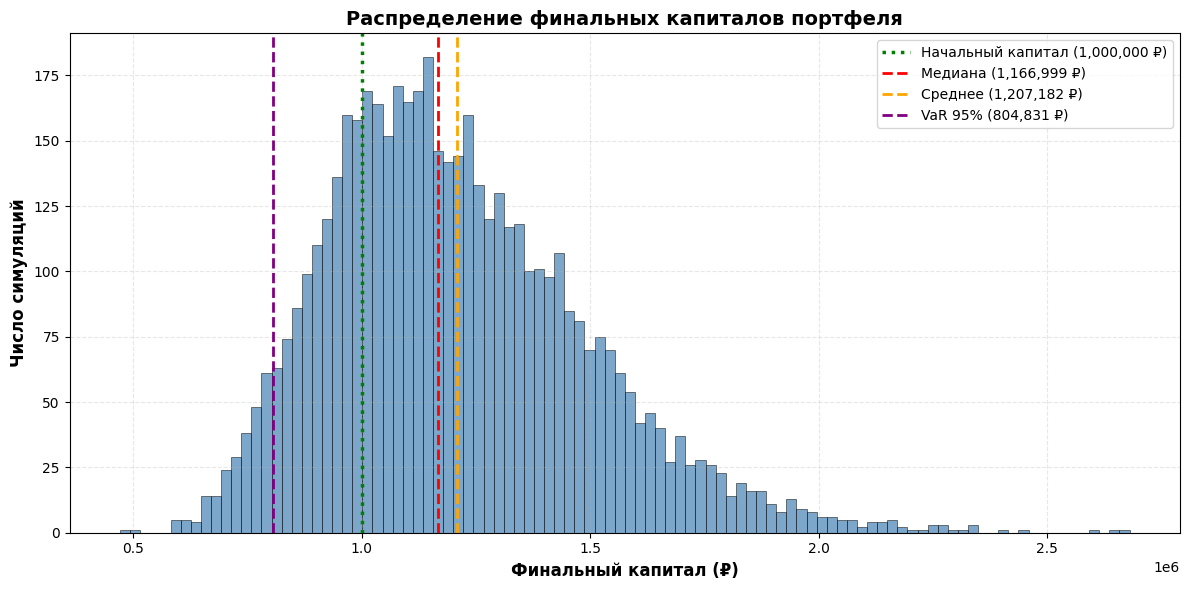

✅ График 1/4: Распределение финальных капиталов


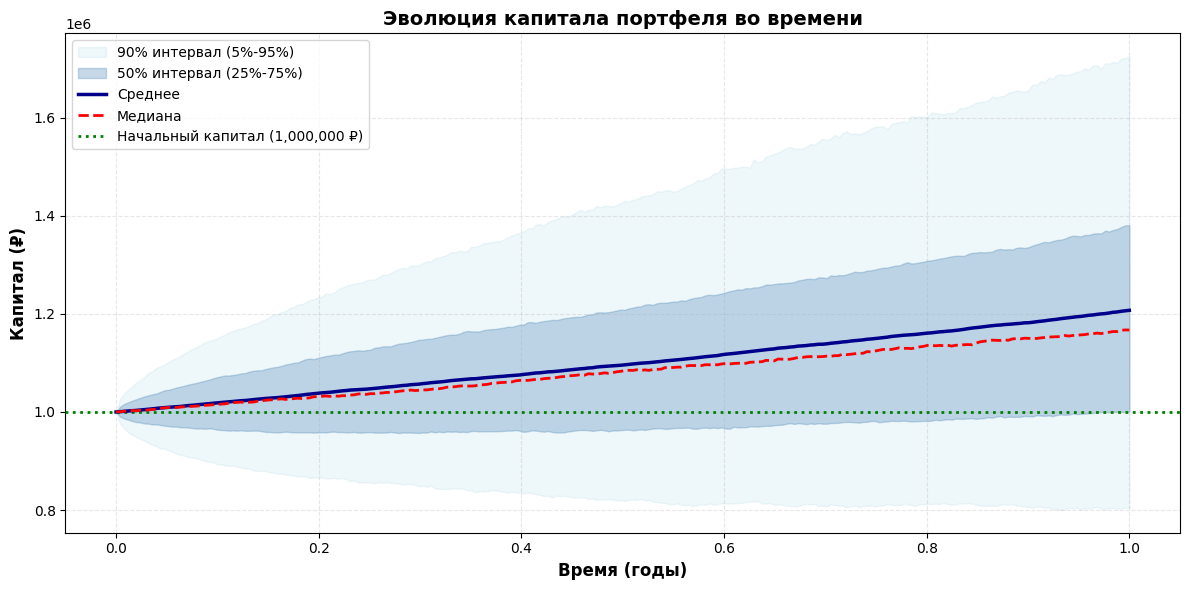

✅ График 2/4: Средняя траектория с доверительными интервалами


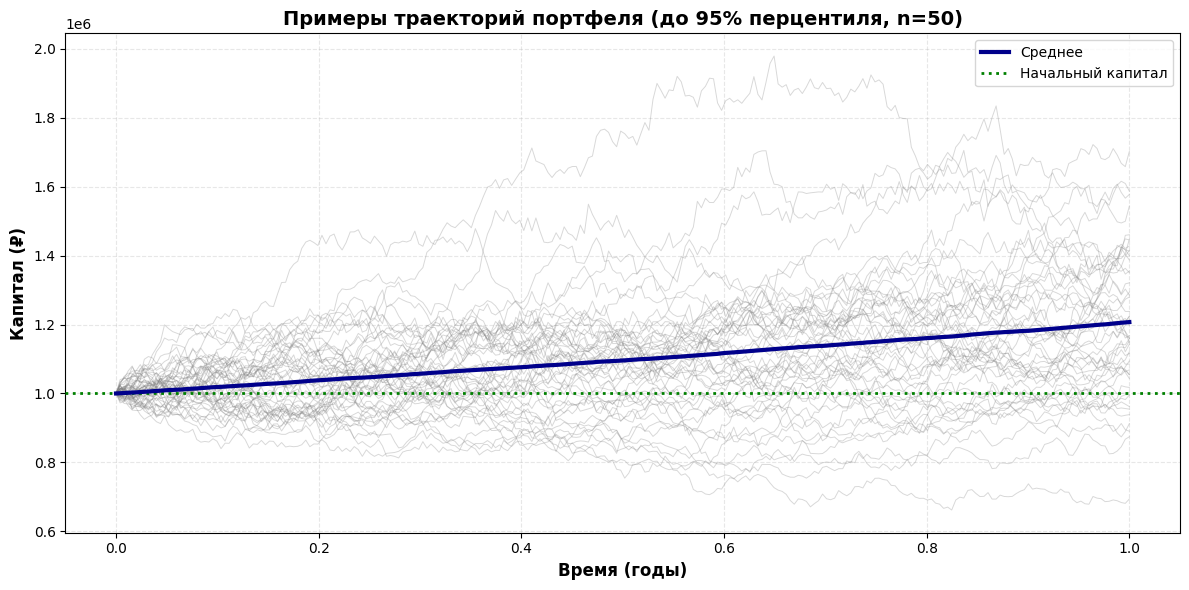

✅ График 3/4: Примеры отдельных траекторий


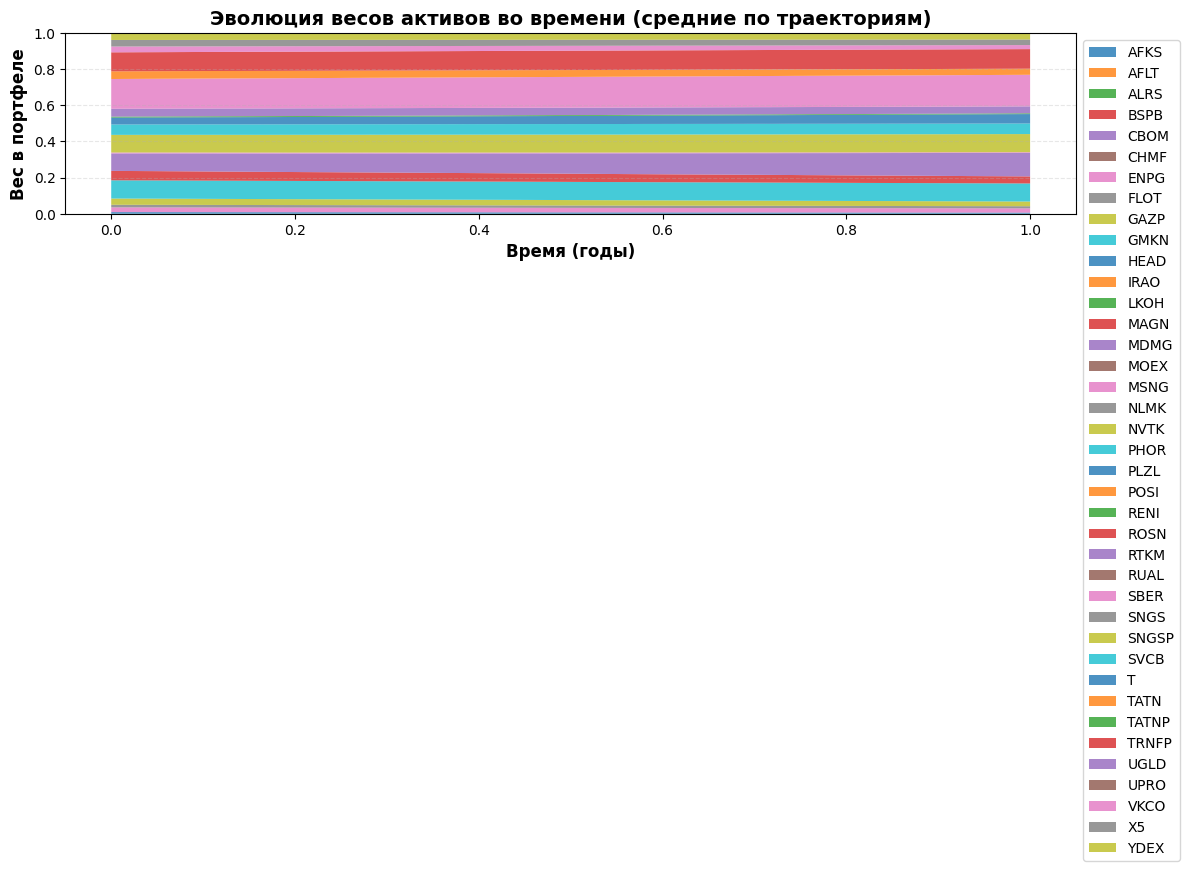

✅ График 4/4: Эволюция весов портфеля во времени

✅ Визуализация завершена: 4 графика построены


ФИНАЛЬНАЯ СВОДКА

🎯 Основные результаты:

   Начальный капитал:               1,000,000 ₽
   Средний финальный капитал:       1,207,182 ₽
     → Прирост:                        +20.72%

   Медианный финальный:             1,166,999 ₽
     → Прирост:                        +16.70%

   Средняя годовая доходность:          20.72%
   Волатильность доходности:           28.51%
   Sharpe Ratio (r_f=13.94%):                 0.2377

📉 МЕТРИКИ РИСКА (VaR и CVaR):

   VaR (95% confidence - 5-й процентиль):
     • Капитал:                  804,831 ₽
     • Потери:                   195,169 ₽  ( 19.52%)
   CVaR (95% confidence):
     • Капитал:                  739,001 ₽
     • Потери:                   260,999 ₽  ( 26.10%)

   VaR (99% confidence - 1-й процентиль):
     • Капитал:                  698,507 ₽
     • Потери:                   301,493 ₽  ( 30.15%)
   CVaR (99% confidence):
     • Капитал

In [ ]:
import numpy as np
import time

# =============================================================================
# БЛОК 3.5: ГЛАВНЫЙ ЗАПУСК PIPELINE (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# =============================================================================
"""
Полный цикл запуска HJB-стратегии с Монте-Карло симуляцией.
ЭТАПЫ PIPELINE:
  3.5.1 — Подготовка входных данных (μ, Σ, активы)
  3.5.2 — Настройка параметров симуляции
  3.5.3 — Инициализация стратегии и Cholesky-разложение
  3.5.4 — Монте-Карло симуляция портфеля
  3.5.5 — Анализ результатов
  3.5.6 — Визуализация
  3.5.7 — Финальная сводка
ВХОДНЫЕ ДАННЫЕ (из предыдущих блоков):
  - mu_with_dividends: ожидаемые доходности (блок 2.4)
  - filtered_cov: ковариационная матрица (блок 2.3)
  - filtered_names: список активов (блок 2.3)
  - rf_hjb: безрисковая ставка (блок 3.1) — из блока 3.1, НЕ локальная!

ВЫХОДНЫЕ ДАННЫЕ:
  - X_paths: траектории капитала (n_paths, num_steps)
  - weights_history: история весов (n_paths, num_steps, n_assets)
  - results: словарь с метриками риска и доходности
  - strategy: объект HJBStrategy (со скорректированным rf_hjb)
"""
print_section("ГЛАВНЫЙ ЗАПУСК HJB-СТРАТЕГИИ (ИСПРАВЛЕННАЯ ВЕРСИЯ)")

# =============================================================================
# 3.5.1: ПОДГОТОВКА ВХОДНЫХ ДАННЫХ
# =============================================================================

print("=" * 100)
print("3.5.1: ПОДГОТОВКА ВХОДНЫХ ДАННЫХ".center(100))
print("=" * 100 + "\n")

# Проверка на существование критических функций
required_objects = {
    'HJBStrategy': 'HJBStrategy',
    'simulate_portfolio_passive': 'simulate_portfolio_passive',
    'analyze_portfolio_results': 'analyze_portfolio_results',
    'visualize_results': 'visualize_results'
}


missing_objects = []
for name, var_name in required_objects.items():
    try:
        obj = eval(var_name)
        if not callable(obj) and not isinstance(obj, type):
            missing_objects.append(name)
    except NameError:
        missing_objects.append(name)


if missing_objects:
    error_msg = (
        f"❌ Следующие необходимые объекты не определены:\n"
        f"   {', '.join(missing_objects)}\n\n"
        f"Убедитесь, что выполнены предыдущие блоки:\n"
        f"   • Блок 3.1: HJBStrategy класс + rf_hjb\n"
        f"   • Блок 3.2: simulate_portfolio_passive функция\n"
        f"   • Блок 3.3: analyze_portfolio_results функция\n"
        f"   • Блок 3.4: visualize_results функция\n"
    )
    raise NameError(error_msg)

# Безрисковая ставка из блока 3.1
try:
    rf_from_block_31 = rf_hjb
    print(f"✅ Обнаружена безрисковая ставка из блока 3.1:")
    print(f"   rf_hjb = {rf_from_block_31:.4f} ({rf_from_block_31*100:.2f}%)\n")
except NameError:
    error_msg = (
        f"❌ Переменная rf_hjb не определена (должна быть из блока 3.1)\n\n"
        f"Убедитесь, что выполнен блок 3.1 полностью.\n"
        f"Блок 3.1 должен определить rf_hjb как:\n"
        f"   rf_manual = 13.94\n"
        f"   rf_hjb = rf_manual / 100\n"
    )
    raise NameError(error_msg)

# Извлечение данных с проверкой существования переменных
try:
    mu = mu_with_dividends.values if hasattr(mu_with_dividends, 'values') else mu_with_dividends
    cov_matrix_array = filtered_cov.values if hasattr(filtered_cov, 'values') else filtered_cov
    asset_names = list(filtered_names)
except NameError as e:
    error_msg = (
        f"❌ Переменная не определена: {e}\n\n"
        f"Убедитесь, что выполнены предыдущие блоки:\n"
        f"   • Блок 2.1.2: расчёт cov_matrix\n"
        f"   • Блок 2.3: фильтрация (filtered_cov, filtered_names)\n"
        f"   • Блок 2.4: дивиденды (mu_with_dividends)\n"
    )
    raise NameError(error_msg)

# Преобразование и валидация размерностей
mu = np.asarray(mu).flatten()
cov_matrix_array = np.asarray(cov_matrix_array)
n_assets = len(asset_names)


if mu.shape[0] != n_assets:
    raise ValueError(
        f"Несоответствие размерностей: μ содержит {mu.shape[0]} элементов, "
        f"но активов {n_assets}"
    )

if cov_matrix_array.shape != (n_assets, n_assets):
    raise ValueError(
        f"Некорректная размерность ковариационной матрицы: "
        f"{cov_matrix_array.shape}, ожидается ({n_assets}, {n_assets})"
    )

print(f"✅ Входные данные валидированы:\n")
print(f"   Активов:         {n_assets}")
print(f"   Размерность μ:   {mu.shape}")
print(f"   Размерность Σ:   {cov_matrix_array.shape}")
print(f"   r_f (из блока 3.1): {rf_from_block_31*100:.2f}%\n")

print(f"📈 Ожидаемые годовые доходности (μ = capital gains + dividends):\n")

# Диагностика отрицательных доходностей
negative_mu_count = np.sum(mu < 0)
all_negative = np.all(mu < 0)


for i, ticker in enumerate(asset_names):
    emoji = "🟢" if mu[i] > 0 else "🔴"
    print(f"   {emoji} {ticker:5s}: {mu[i]*100:>7.2f}%")

print(f"\n   Средняя μ: {np.mean(mu)*100:>7.2f}%")
print(f"   Мин. μ:    {np.min(mu)*100:>7.2f}% ({asset_names[np.argmin(mu)]})")
print(f"   Макс. μ:   {np.max(mu)*100:>7.2f}% ({asset_names[np.argmax(mu)]})")

# Явные предупреждения
if all_negative:
    print(f"\n⚠️  КРИТИЧЕСКОЕ ВНИМАНИЕ: Все ожидаемые доходности отрицательны!")
    print(f"   Портфель будет работать убыточно.")
    print(f"   Проверьте входные данные (capital gains + dividends)")
elif negative_mu_count > n_assets / 2:
    print(f"\n⚠️  ВНИМАНИЕ: {negative_mu_count}/{n_assets} активов имеют отрицательные доходности")



# Вычислить избыточные доходности для диагностики
excess_mu = mu - rf_from_block_31
print(f"\n📊 Избыточные доходности (μ - r_f = μ - {rf_from_block_31*100:.2f}%):\n")

positive_excess_count = np.sum(excess_mu > 0)
for i, ticker in enumerate(asset_names):
    excess = excess_mu[i]
    emoji = "🟢" if excess > 0 else "🔴"
    print(f"   {emoji} {ticker:5s}: {excess*100:>7.2f}%")

print(f"\n   Активов с положительной избыточной доходностью: {positive_excess_count}/{n_assets}")

if positive_excess_count == 0:
    print(f"\n⚠️  ВНИМАНИЕ: Ни один актив не имеет положительную избыточную доходность (μ > r_f)")
    print(f"   Оптимальное решение может быть инвестировать только в безрисковый актив.")
    print(f"   Проверьте данные или увеличьте временной горизонт.")

# =============================================================================
# 3.5.2: НАСТРОЙКА ПАРАМЕТРОВ СИМУЛЯЦИИ
# =============================================================================

print("\n" + "=" * 100)
print("3.5.2: НАСТРОЙКА ПАРАМЕТРОВ СИМУЛЯЦИИ".center(100))
print("=" * 100 + "\n")

# Параметры портфеля
X_0 = 1_000_000  # Начальный капитал (руб.)
gamma = 3.0      # Коэффициент относительного неприятия риска
random_seed = 42 # Для воспроизводимости результатов

# Параметры симуляции
n_paths = 5000   # Количество Монте-Карло траекторий
T = 1.0          # Временной горизонт (годы)
n_steps = 252    # Число временных шагов (торговых дней)

# Временная сетка
t_grid = np.linspace(0, T, n_steps)
dt = T / (n_steps - 1)

print(f"⚙️  Параметры портфеля:")
print(f"   X₀ (начальный капитал):  {X_0:>12,.0f} ₽")
print(f"   γ (риск-аверсия):        {gamma:>12.1f}")
print(f"   Горизонт (T):            {T:>12.1f} {'год' if T == 1 else 'года/лет'}")

print(f"\n⚙️  Интерпретация γ = {gamma}:")
if gamma == 1.0:
    print(f"   → Логарифмическая полезность (нейтральный инвестор)")
elif gamma < 3.0:
    print(f"   → Умеренная риск-аверсия (агрессивный инвестор)")
elif gamma < 10.0:
    print(f"   → Стандартная риск-аверсия (обычный инвестор)")
else:
    print(f"   → Высокая риск-аверсия (консервативный инвестор)")

print(f"\n⚙️  Параметры симуляции:")
print(f"   Траекторий (n_paths):    {n_paths:>12,}")
print(f"   Временных шагов:         {n_steps:>12}")
print(f"   Шаг времени (dt):        {dt:>12.4f} лет ({dt*252:.0f} день)")
print(f"   Random seed:             {random_seed:>12}")

# =============================================================================
# 3.5.3: ИНИЦИАЛИЗАЦИЯ СТРАТЕГИИ
# =============================================================================
print("\n" + "=" * 100)
print("3.5.3: ИНИЦИАЛИЗАЦИЯ СТРАТЕГИИ (С КОНСИСТЕНТНОЙ RF)".center(100))
print("=" * 100 + "\n")

# Cholesky-разложение ковариационной матрицы
eigenvalues = np.linalg.eigvalsh(cov_matrix_array)
min_eig = eigenvalues.min()
max_eig = eigenvalues.max()
condition_number = max_eig / min_eig if min_eig > 0 else np.inf

if min_eig > 1e-10:
    # Матрица положительно определена
    L = np.linalg.cholesky(cov_matrix_array)
    print(f"✅ Матрица положительно определена")
    print(f"   λ_min = {min_eig:.2e}")
    print(f"   λ_max = {max_eig:.2e}")
    print(f"   Condition number = {condition_number:.2e}")
    print(f"   L.shape = {L.shape}")
else:
    # Матрица вырождена — применяем регуляризацию
    print(f"⚠️  ВНИМАНИЕ: Матрица близка к вырожденной")
    print(f"   λ_min = {min_eig:.2e}")
    print(f"   Condition number = {condition_number:.2e}")
    print(f"\n   Возможные причины:")
    print(f"   • Недостаточно данных (малое число наблюдений)")
    print(f"   • Коллинеарность активов (высокие корреляции)")
    print(f"   • Ошибки в расчете матрицы")


    # Регуляризация с расширенной диагностикой
    epsilon = max(1e-6, abs(min_eig) * 10)
    cov_matrix_reg = cov_matrix_array + epsilon * np.eye(n_assets)
    L = np.linalg.cholesky(cov_matrix_reg)


    print(f"\n   Применена регуляризация:")
    print(f"   ε = {epsilon:.2e}")
    print(f"   L.shape = {L.shape}")
    print(f"\n   ⚠️  ВНИМАНИЕ: РЕЗУЛЬТАТЫ МОГУТ БЫТЬ НЕНАДЕЖНЫ")
    print(f"   Рекомендуется проверить входные данные")


# Инициализация HJB-стратегии с rf_hjb из блока 3.1
print(f"\n🔐 Передача безрисковой ставки в стратегию:")
print(f"   rf_hjb (из блока 3.1) = {rf_from_block_31:.4f} ({rf_from_block_31*100:.2f}%)")

try:
    strategy = HJBStrategy(
        mu=mu,
        cov_matrix=cov_matrix_array,
        risk_free_rate=rf_from_block_31,
        gamma=gamma,
        asset_names=asset_names
    )
    print(f"\n✅ HJBStrategy инициализирована с rf = {rf_from_block_31*100:.2f}%")
except Exception as e:
    print(f"\n❌ Ошибка при инициализации HJBStrategy: {e}")
    raise

# Вывод оптимальных весов
print(f"\n📊 Оптимальные веса портфеля (после инициализации):")
strategy.print_weights()

# =============================================================================
# 3.5.4: МОНТЕ-КАРЛО СИМУЛЯЦИЯ
# =============================================================================

print("\n" + "=" * 100)
print("3.5.4: МОНТЕ-КАРЛО СИМУЛЯЦИЯ (ПАССИВНЫЕ ВЕСА)".center(100))
print("=" * 100 + "\n")

print(f"🚀 Запуск симуляции {n_paths:,} траекторий на горизонте {T} {'год' if T == 1 else 'года/лет'}...\n")

start_time = time.time()

# Передача random_seed в симуляцию
try:
    X_paths, weights_history, t_grid = simulate_portfolio_passive(
        mu=mu,
        sigma_cholesky=L,
        X_0=X_0,
        strategy=strategy,
        asset_names=asset_names,
        t_grid=t_grid,
        n_paths=n_paths,
        random_seed=random_seed
    )
except Exception as e:
    print(f"❌ Ошибка при симуляции: {e}")
    raise



elapsed = time.time() - start_time

print(f"\n✅ Симуляция завершена за {elapsed:.2f} сек")
print(f"   Производительность: {n_paths * n_steps / elapsed:,.0f} шагов/сек")
print(f"   X_paths:          {X_paths.shape}")
print(f"   weights_history:  {weights_history.shape}")

# =============================================================================
# 3.5.5: АНАЛИЗ РЕЗУЛЬТАТОВ
# =============================================================================

print("\n" + "=" * 100)
print("3.5.5: АНАЛИЗ РЕЗУЛЬТАТОВ".center(100))
print("=" * 100 + "\n")

# Передача rf с ПРАВИЛЬНЫМИ параметрами (var_level_95, var_level_99)
try:
    results = analyze_portfolio_results(
        X_paths=X_paths,
        weights_history=weights_history,
        t_grid=t_grid,
        asset_names=asset_names,
        X_0=X_0,
        rf=rf_from_block_31,
        var_level_95=0.05,
        var_level_99=0.01
    )

    # 🔴 ПРОВЕРКА КОНСИСТЕНТНОСТИ: Убедиться, что rf совпадает
    if abs(results['rf'] - rf_from_block_31) > 1e-6:
        raise ValueError(
            f"Несоответствие безрисковой ставки: "
            f"блок 3.1 = {rf_from_block_31:.4f}, "
            f"результаты = {results['rf']:.4f}"
        )

except Exception as e:
    print(f"❌ Ошибка при анализе результатов: {e}")
    raise

# =============================================================================
# 3.5.6: ВИЗУАЛИЗАЦИЯ
# =============================================================================

print("=" * 100)
print("3.5.6: ВИЗУАЛИЗАЦИЯ".center(100))
print("=" * 100 + "\n")



try:
    visualize_results(
        X_paths=X_paths,
        weights_history=weights_history,
        t_grid=t_grid,
        asset_names=asset_names,
        X_0=X_0,
        var_level=0.05  # ← Для визуализации используем 95%
    )
except Exception as e:
    print(f"⚠️  Ошибка при визуализации (графики пропущены): {e}")
    print(f"   Программа продолжает работу без графиков\n")

# =============================================================================
# 3.5.7: ФИНАЛЬНАЯ СВОДКА
# =============================================================================

print_section("ФИНАЛЬНАЯ СВОДКА")

print(f"🎯 Основные результаты:\n")
print(f"   Начальный капитал:         {X_0:>15,.0f} ₽")
print(f"   Средний финальный капитал: {results['mean_final']:>15,.0f} ₽")
print(f"     → Прирост:               {(results['mean_final']/X_0 - 1)*100:>+15.2f}%")
print(f"\n   Медианный финальный:       {results['median_final']:>15,.0f} ₽")
print(f"     → Прирост:               {(results['median_final']/X_0 - 1)*100:>+15.2f}%")
print(f"\n   Средняя годовая доходность: {results['mean_return']*100:>14.2f}%")
print(f"   Волатильность доходности:  {results['std_return']*100:>14.2f}%")
print(f"   Sharpe Ratio (r_f={rf_from_block_31*100:.2f}%): {results['sharpe']:>22.4f}")


# 📊 VaR И CVaR С 95% И 99% ДОВЕРИТЕЛЬНЫМИ ИНТЕРВАЛАМИ
print(f"\n📉 МЕТРИКИ РИСКА (VaR и CVaR):\n")

print(f"   VaR (95% confidence - 5-й процентиль):")
print(f"     • Капитал:          {results['var_capital_95']:>15,.0f} ₽")
print(f"     • Потери:           {results['loss_var_95']:>15,.0f} ₽  ({results['loss_var_percent_95']:>6.2f}%)")
print(f"   CVaR (95% confidence):")
print(f"     • Капитал:          {results['cvar_capital_95']:>15,.0f} ₽")
print(f"     • Потери:           {results['loss_cvar_95']:>15,.0f} ₽  ({results['loss_cvar_percent_95']:>6.2f}%)")

print(f"\n   VaR (99% confidence - 1-й процентиль):")
print(f"     • Капитал:          {results['var_capital_99']:>15,.0f} ₽")
print(f"     • Потери:           {results['loss_var_99']:>15,.0f} ₽  ({results['loss_var_percent_99']:>6.2f}%)")
print(f"   CVaR (99% confidence):")
print(f"     • Капитал:          {results['cvar_capital_99']:>15,.0f} ₽")
print(f"     • Потери:           {results['loss_cvar_99']:>15,.0f} ₽  ({results['loss_cvar_percent_99']:>6.2f}%)")

print(f"\n   Maximum Drawdown:")
print(f"     • Средний:          {results['mean_max_drawdown']:>15.2%}")
print(f"     • Худший:           {results['worst_drawdown']:>15.2%}")

print(f"\n⏱️  Производительность:")
print(f"   Траекторий:                {n_paths:>15,}")
print(f"   Временных шагов:           {n_steps:>15,}")
print(f"   Время выполнения:          {elapsed:>15.2f} сек")
print(f"   Скорость:                  {n_paths * n_steps / elapsed:>15,.0f} шагов/сек")

print(f"\n📦 Доступные переменные для дальнейшего анализа:\n")
print(f"   X_paths          : {X_paths.shape}")
print(f"      • Размер: (n_paths, num_steps) = ({n_paths}, {n_steps})")
print(f"      • Использование: X_paths[path_idx, time_idx] = капитал в момент времени")
print(f"      • Пример: final_capital = X_paths[0, -1]  # финальный капитал 1-й траектории")
print(f"\n   weights_history  : {weights_history.shape}")
print(f"      • Размер: (n_paths, num_steps, n_assets) = ({n_paths}, {n_steps}, {n_assets})")
print(f"      • Использование: weights_history[path_idx, time_idx, asset_idx] = вес актива")
print(f"      • Пример: final_weights = weights_history[0, -1, :]  # веса в конце 1-й траектории")
print(f"\n   results          : dict")
print(f"      • Метрики: mean_final, median_final, std_return, sharpe, var_capital_95/99, etc.")
print(f"      • Пример: print(results['sharpe'])  # Sharpe Ratio (с r_f = {rf_from_block_31*100:.2f}%)")
print(f"      • Новые метрики: var_capital_99, loss_var_99, cvar_capital_99, loss_cvar_99")
print(f"\n   strategy         : HJBStrategy")
print(f"      • Объект стратегии с параметрами γ = {gamma}")
print(f"      • r_f = {rf_from_block_31*100:.2f}% (из блока 3.1)")
print(f"      • Методы: get_optimal_weights(), get_portfolio_stats()")
print(f"\n   t_grid           : {t_grid.shape}")
print(f"      • Временная сетка: от {t_grid[0]:.4f} до {t_grid[-1]:.4f} лет")

print(f"\n🔐 КОНСИСТЕНТНОСТЬ МЕЖДУ БЛОКАМИ:")
print(f"   ✅ rf_hjb (блок 3.1):           {rf_from_block_31:.4f} ({rf_from_block_31*100:.2f}%)")
print(f"   ✅ r_f (HJBStrategy):            {strategy.risk_free_rate:.4f} ({strategy.risk_free_rate*100:.2f}%)")
print(f"   ✅ r_f (результаты анализа):    {results['rf']:.4f} ({results['rf']*100:.2f}%)")
print(f"   ✅ Sharpe Ratio:                {results['sharpe']:.4f} (с учётом r_f)")
print(f"   ✅ VaR/CVaR:                    95% и 99% уровни рассчитаны")
print(f"\n   🎯 Все параметры консистентны!")

print_section("БЛОК 3.5 ЗАВЕРШЁН — PIPELINE ВЫПОЛНЕН УСПЕШНО ✅")

**3.6 Расчет исторического значения VaR**

In [ ]:
# =============================================================================
# БЛОК 3.6: СРАВНЕНИЕ MC VaR И ИСТОРИЧЕСКОГО VaR
# =============================================================================

print("\n" + "=" * 100)
print("БЛОК 3.7: СРАВНЕНИЕ MONTE-CARLO VaR И ИСТОРИЧЕСКОГО VaR".center(100))
print("=" * 100)

# =============================================================================
# 3.6.1: ЗАГРУЗКА ДАННЫХ И РАСЧЕТ ИСТОРИЧЕСКОГО VaR
# =============================================================================

print("\n" + "=" * 100)
print("3.7.1: ЗАГРУЗКА ДАННЫХ И РАСЧЕТ ИСТОРИЧЕСКОГО VaR".center(100))
print("=" * 100 + "\n")

# Проверка наличия необходимых данных
required_vars = ['results', 'returns', 'filtered_names']
missing_vars = []

for var_name in required_vars:
    try:
        eval(var_name)
    except NameError:
        missing_vars.append(var_name)

if missing_vars:
    raise NameError(
        f"❌ Отсутствуют переменные: {', '.join(missing_vars)}\n"
        f"Убедитесь, что выполнены блоки 2.1-2.4 и блок 3.5"
    )

print("✅ Все необходимые данные загружены\n")

# Извлечение параметров
X_0 = 1_000_000
optimal_weights = results['optimal_weights']
asset_names_list = list(filtered_names)
n_assets = len(asset_names_list)

print(f"📊 Параметры анализа:")
print(f"   Начальный капитал: {X_0:,} ₽")
print(f"   Активов в портфеле: {n_assets}")
print(f"   Периодов в истории: {len(returns)}")
print(f"   Дата начала: {returns.index[0]}")
print(f"   Дата конца: {returns.index[-1]}\n")

# Расчет портфельных доходностей и потерь
returns_filtered = returns[asset_names_list].copy()
portfolio_returns = (returns_filtered * optimal_weights).sum(axis=1)
portfolio_losses = -portfolio_returns  # потери = -доходность
portfolio_losses_rub = portfolio_losses * X_0

print(f"📈 Статистика портфельных потерь:\n")
print(f"   Средняя потеря: {portfolio_losses_rub.mean():>12,.0f} ₽")
print(f"   Макс потеря: {portfolio_losses_rub.max():>12,.0f} ₽")
print(f"   Мин потеря: {portfolio_losses_rub.min():>12,.0f} ₽")
print(f"   Стд.отклонение: {portfolio_losses_rub.std():>12,.0f} ₽\n")

# Расчет исторического VaR
var_loss_95_hist = np.percentile(portfolio_losses_rub, 95)
var_loss_99_hist = np.percentile(portfolio_losses_rub, 99)
var_capital_95_hist = X_0 - var_loss_95_hist
var_capital_99_hist = X_0 - var_loss_99_hist

print(f"📊 ИСТОРИЧЕСКИЙ VaR:\n")
print(f"   VaR(95%):")
print(f"     • Потеря (95-й процентиль): {var_loss_95_hist:>12,.0f} ₽  ({var_loss_95_hist/X_0*100:>6.2f}%)")
print(f"     • Капитал: {var_capital_95_hist:>12,.0f} ₽")
print(f"\n   VaR(99%):")
print(f"     • Потеря (99-й процентиль): {var_loss_99_hist:>12,.0f} ₽  ({var_loss_99_hist/X_0*100:>6.2f}%)")
print(f"     • Капитал: {var_capital_99_hist:>12,.0f} ₽\n")

# =============================================================================
# 3.6.2: СРАВНЕНИЕ MC VaR И ИСТОРИЧЕСКОГО VaR
# =============================================================================

print("=" * 100)
print("3.7.2: СРАВНЕНИЕ MC VaR И ИСТОРИЧЕСКОГО VaR".center(100))
print("=" * 100 + "\n")

# MC VaR из блока 3.5
loss_var_95_mc = results['loss_var_95']
loss_var_99_mc = results['loss_var_99']
var_capital_95_mc = results['var_capital_95']
var_capital_99_mc = results['var_capital_99']

print(f"📋 MONTE-CARLO VaR (из блока 3.5):\n")
print(f"   VaR(95%): капитал = {var_capital_95_mc:>12,.0f} ₽, потеря = {loss_var_95_mc:>12,.0f} ₽")
print(f"   VaR(99%): капитал = {var_capital_99_mc:>12,.0f} ₽, потеря = {loss_var_99_mc:>12,.0f} ₽\n")

print(f"📋 ИСТОРИЧЕСКИЙ VaR:\n")
print(f"   VaR(95%): капитал = {var_capital_95_hist:>12,.0f} ₽, потеря = {var_loss_95_hist:>12,.0f} ₽")
print(f"   VaR(99%): капитал = {var_capital_99_hist:>12,.0f} ₽, потеря = {var_loss_99_hist:>12,.0f} ₽\n")

# Расчет разниц
diff_95_capital = var_capital_95_mc - var_capital_95_hist
diff_99_capital = var_capital_99_mc - var_capital_99_hist
diff_95_loss = loss_var_95_mc - var_loss_95_hist
diff_99_loss = loss_var_99_mc - var_loss_99_hist

pct_diff_95_loss = (diff_95_loss / var_loss_95_hist * 100) if var_loss_95_hist > 0 else 0
pct_diff_99_loss = (diff_99_loss / var_loss_99_hist * 100) if var_loss_99_hist > 0 else 0

print(f"📊 СРАВНЕНИЕ (MC - Историческое):\n")
print(f"{'Метрика':<30} | {'Историческое':<18} | {'MC':<18} | {'Разница':<18}")
print(f"{'-'*30}-+-{'-'*18}-+-{'-'*18}-+-{'-'*18}")
print(f"{'VaR(95%) потеря (₽)':<30} | {var_loss_95_hist:>16,.0f} | {loss_var_95_mc:>16,.0f} | {diff_95_loss:>+16,.0f}")
print(f"{'VaR(99%) потеря (₽)':<30} | {var_loss_99_hist:>16,.0f} | {loss_var_99_mc:>16,.0f} | {diff_99_loss:>+16,.0f}")
print(f"{'VaR(95%) потеря (%)':<30} | {var_loss_95_hist/X_0*100:>16.2f}% | {loss_var_95_mc/X_0*100:>16.2f}% | {pct_diff_95_loss:>+16.2f}%")
print(f"{'VaR(99%) потеря (%)':<30} | {var_loss_99_hist/X_0*100:>16.2f}% | {loss_var_99_mc/X_0*100:>16.2f}% | {pct_diff_99_loss:>+16.2f}%\n")

# =============================================================================
# 3.6.3: ИНТЕРПРЕТАЦИЯ
# =============================================================================

print("=" * 100)
print("3.7.3: ИНТЕРПРЕТАЦИЯ И ВЫВОДЫ".center(100))
print("=" * 100 + "\n")

print(f"📝 АНАЛИЗ:\n")

if diff_95_loss > 0:
    print(f"✅ MC VaR(95%) БОЛЬШЕ, чем историческое")
    print(f"   → Модель консервативна (+{diff_95_loss:,.0f} ₽ = +{pct_diff_95_loss:.1f}%)")
else:
    print(f"⚠️  MC VaR(95%) МЕНЬШЕ, чем историческое")
    print(f"   → Модель недооценивает риск ({diff_95_loss:,.0f} ₽ = {pct_diff_95_loss:.1f}%)")

print()

if diff_99_loss > 0:
    print(f"✅ MC VaR(99%) БОЛЬШЕ, чем историческое")
    print(f"   → Модель консервативна для хвоста (+{diff_99_loss:,.0f} ₽ = +{pct_diff_99_loss:.1f}%)")
else:
    print(f"⚠️  MC VaR(99%) МЕНЬШЕ, чем историческое")
    print(f"   → Модель недооценивает хвостовой риск ({diff_99_loss:,.0f} ₽ = {pct_diff_99_loss:.1f}%)")

print(f"\n💡 ВЫВОД:")

if diff_95_loss > 0 and diff_99_loss > 0:
    print(f"   Модель MC консервативна и годится для использования")
    print(f"   в целях управления риском (переоценивает потери)")
elif diff_95_loss < 0 or diff_99_loss < 0:
    print(f"   Модель MC недооценивает риск")
    print(f"   ⚠️  Следует быть осторожнее при использовании")
else:
    print(f"   Модель в целом адекватна")

print(f"\n📌 Эти значения будут использованы в блоке 4.x для бэктеста на отдельном датасете\n")

# Сохранение результатов
mc_vs_hist_comparison = {
    'var_95_mc': loss_var_95_mc,
    'var_99_mc': loss_var_99_mc,
    'var_95_hist': var_loss_95_hist,
    'var_99_hist': var_loss_99_hist,
    'diff_95': diff_95_loss,
    'diff_99': diff_99_loss,
    'pct_diff_95': pct_diff_95_loss,
    'pct_diff_99': pct_diff_99_loss,
}

print("=" * 100)
print("✅ БЛОК 3.7 ЗАВЕРШЕН".center(100))
print("=" * 100 + "\n")


                      БЛОК 3.7: СРАВНЕНИЕ MONTE-CARLO VaR И ИСТОРИЧЕСКОГО VaR                       

                         3.7.1: ЗАГРУЗКА ДАННЫХ И РАСЧЕТ ИСТОРИЧЕСКОГО VaR                          

✅ Все необходимые данные загружены

📊 Параметры анализа:
   Начальный капитал: 1,000,000 ₽
   Активов в портфеле: 10
   Периодов в истории: 252
   Дата начала: 2024-11-02 00:00:00
   Дата конца: 2025-11-01 00:00:00

📈 Статистика портфельных потерь:

   Средняя потеря:         -938 ₽
   Макс потеря:       48,222 ₽
   Мин потеря:      -73,462 ₽
   Стд.отклонение:       15,572 ₽

📊 ИСТОРИЧЕСКИЙ VaR:

   VaR(95%):
     • Потеря (95-й процентиль):       22,443 ₽  (  2.24%)
     • Капитал:      977,557 ₽

   VaR(99%):
     • Потеря (99-й процентиль):       31,180 ₽  (  3.12%)
     • Капитал:      968,820 ₽

                            3.7.2: СРАВНЕНИЕ MC VaR И ИСТОРИЧЕСКОГО VaR                             

📋 MONTE-CARLO VaR (из блока 3.5):

   VaR(95%): капитал =      942,160 ₽, потеря =  

**3.7 Бэктестинг VaR**

**3.7.1 Загразука данных новому периоду для того же пула активов**

In [ ]:
# =============================================================================
# БЛОК 3.7.1: ЗАГРУЗКА ДАННЫХ ДЛЯ БЭКТЕСТА VaR (v5 - ИЗ STRATEGY ОБЪЕКТА)
# =============================================================================
"""
Загрузка исторических данных из MOEX API за период для бэктеста.
Аналогично блоку 1.1, но для ОТДЕЛЬНОГО периода (без пересечения с обучающей выборкой).

ВАЖНО:
  • Период бэктеста НЕ должен пересекаться с обучающим периодом (блок 1.1)
  • Используются ТОЛЬКО активы с ненулевыми весами в портфеле (из объекта strategy, блок 3.5)
  • Волатильность может отличаться → это выявит проблемы модели
"""

import pandas as pd
import numpy as np
from datetime import datetime
import requests
import time

print("\n" + "=" * 100)
print("БЛОК 3.7.1: ЗАГРУЗКА ДАННЫХ ДЛЯ БЭКТЕСТА VaR".center(100))
print("=" * 100 + "\n")

# =============================================================================
# 3.7.1.1: ПРОВЕРКА ИСХОДНОГО ПЕРИОДА И ВЕСОВ ПОРТФЕЛЯ
# =============================================================================

print("=" * 100)
print("3.7.1.1: ПРОВЕРКА ИСХОДНОГО ПЕРИОДА И ВЕСОВ ПОРТФЕЛЯ".center(100))
print("=" * 100 + "\n")

# Проверка наличия необходимых переменных ИЗ БЛОКА 1.1 И 3.5
required_vars = {
    'priced_df': 'DataFrame цен (из блока 1.1)',
    'asset_names': 'Список активов (из блока 1.1)',
    'n_assets': 'Количество активов (из блока 1.1)',
    'strategy': 'HJBStrategy объект (из блока 3.5)'
}

print("✅ Проверка наличия основных данных:\n")

missing_vars = []
for var_name, description in required_vars.items():
    try:
        test_var = eval(var_name)
        print(f"   ✅ {var_name}: найдена ({description})")
    except NameError:
        missing_vars.append((var_name, description))
        print(f"   ❌ {var_name}: не найдена ({description})")

if missing_vars:
    error_msg = "\n❌ Отсутствуют следующие переменные:\n"
    for var_name, description in missing_vars:
        error_msg += f"   • {var_name} ({description})\n"
    error_msg += "\nУбедитесь, что выполнены блоки 1.1 и 3.5\n"
    raise NameError(error_msg)

print()

# Извлечение исходных данных
original_start = priced_df.index[0]
original_end = priced_df.index[-1]

print(f"✅ ИСХОДНЫЕ ДАННЫЕ ЗАГРУЖЕНЫ:\n")
print(f"   Дата начала: {original_start.date()}")
print(f"   Дата конца:  {original_end.date()}")
print(f"   Количество дней: {len(priced_df)}")
print(f"   Активов в исходных данных: {n_assets}")
print(f"   Активы: {asset_names}\n")

# =============================================================================
# 3.7.1.1.5: ЗАГРУЗКА ВЕСОВ ПОРТФЕЛЯ ИЗ STRATEGY
# =============================================================================

print("=" * 100)
print("3.7.1.1.5: ЗАГРУЗКА ВЕСОВ ПОРТФЕЛЯ ИЗ STRATEGY (БЛОК 3.5)".center(100))
print("=" * 100 + "\n")

print("🔍 Извлечение оптимальных весов из стратегии...\n")

try:
    # Получаем веса из strategy объекта
    weights = strategy.get_optimal_weights()

    # Конвертирование в numpy array если нужно
    weights = np.asarray(weights).flatten()

    print(f"   ✅ Веса успешно загружены из strategy объекта\n")

    # Проверка суммы весов
    weights_sum = np.sum(weights)
    print(f"   📊 Статистика весов:")
    print(f"      Сумма весов: {weights_sum:.6f}")
    print(f"      Min вес: {np.min(weights)*100:>7.3f}%")
    print(f"      Max вес: {np.max(weights)*100:>7.3f}%")
    print(f"      Активов с ненулевыми весами: {np.sum(weights > 0)}\n")

    # Проверка, что сумма близка к 1
    if abs(weights_sum - 1.0) > 0.01:
        print(f"   ⚠️  ВНИМАНИЕ: Сумма весов = {weights_sum:.6f} (ожидается ≈ 1.0)")
        print(f"      Веса возможно не нормализованы\n")

    # Подробный список весов
    print(f"   📋 Веса по активам (из strategy):\n")
    for i, (ticker, w) in enumerate(zip(asset_names, weights)):
        if w > 0:
            print(f"      {ticker:>6} → {w*100:>6.2f}%")
        else:
            print(f"      {ticker:>6} → {w*100:>6.2f}% (исключен)")
    print()

    # Фильтрация активов по весам
    min_weight_threshold = 0.0001  # 0.01% (очень мягкий порог)
    asset_names_to_load = [
        asset_names[i]
        for i in range(len(asset_names))
        if weights[i] > min_weight_threshold
    ]

    # Информация о фильтрации
    excluded_count = len(asset_names) - len(asset_names_to_load)
    if excluded_count > 0:
        excluded_assets = [
            asset_names[i]
            for i in range(len(asset_names))
            if weights[i] <= min_weight_threshold
        ]
        print(f"   🚫 Исключены активы с весом ≤ {min_weight_threshold*100:.2f}%:")
        print(f"      {', '.join(excluded_assets)}\n")

    weights_info = {
        'asset_names': asset_names,
        'weights': weights,
        'loaded_assets': asset_names_to_load,
        'min_weight_threshold': min_weight_threshold,
        'source': 'strategy.get_optimal_weights() из блока 3.5'
    }

except AttributeError as e:
    print(f"   ❌ ОШИБКА: strategy объект не имеет метода get_optimal_weights()")
    print(f"      {e}\n")
    print(f"   Убедитесь, что блок 3.5 выполнен полностью\n")
    raise

except Exception as e:
    print(f"   ❌ ОШИБКА при извлечении весов: {e}\n")
    raise

print(f"✅ К ЗАГРУЗКЕ: {len(asset_names_to_load)} активов")
print(f"   {', '.join(asset_names_to_load)}\n")

# =============================================================================
# 3.7.1.2: ВВОД ПАРАМЕТРОВ БЭКТЕСТА
# =============================================================================

print("=" * 100)
print("3.7.1.2: ВВОД ПАРАМЕТРОВ ПЕРИОДА ДЛЯ БЭКТЕСТА".center(100))
print("=" * 100 + "\n")

print("📌 ВАЖНО: Период бэктеста НЕ должен пересекаться с исходным!\n")
print(f"   Исходный период: {original_start.date()} - {original_end.date()}\n")

# Ввод дат
print("=" * 60)
print("📋 ВВЕДИ ПАРАМЕТРЫ БЭКТЕСТА:\n")

# Ввод даты начала
backtest_start = None
while backtest_start is None:
    try:
        backtest_start_str = input("Дата начала (DD.MM.YYYY): ").strip()
        backtest_start = pd.to_datetime(backtest_start_str, format='%d.%m.%Y')
    except ValueError:
        print("❌ Неверный формат! Используй DD.MM.YYYY\n")
        backtest_start = None

# Ввод даты конца
backtest_end = None
while backtest_end is None:
    try:
        backtest_end_str = input("Дата конца (DD.MM.YYYY): ").strip()
        backtest_end = pd.to_datetime(backtest_end_str, format='%d.%m.%Y')
    except ValueError:
        print("❌ Неверный формат! Используй DD.MM.YYYY\n")
        backtest_end = None

print("=" * 60 + "\n")

# Проверка корректности дат
if backtest_start >= backtest_end:
    raise ValueError("❌ Дата начала должна быть раньше даты конца!")

# Проверка пересечений
has_warning = False

print(f"📅 Проверка пересечений:\n")
print(f"   Исходный период:  {original_start.date()} - {original_end.date()}")
print(f"   Бэктест период:   {backtest_start.date()} - {backtest_end.date()}\n")

if backtest_end < original_start:
    print(f"   ✅ Бэктест ПОЛНОСТЬЮ ДО исходного периода")
    print(f"      (заканчивается {(original_start - backtest_end).days} дней ДО начала)\n")
elif backtest_start > original_end:
    print(f"   ✅ Бэктест ПОЛНОСТЬЮ ПОСЛЕ исходного периода")
    print(f"      (начинается {(backtest_start - original_end).days} дней ПОСЛЕ конца)\n")
else:
    # Есть пересечение
    overlap_start = max(original_start, backtest_start)
    overlap_end = min(original_end, backtest_end)
    overlap_days = (overlap_end - overlap_start).days

    print(f"   ⚠️  ВНИМАНИЕ: Обнаружено пересечение!")
    print(f"      Пересечение: {overlap_start.date()} - {overlap_end.date()}")
    print(f"      Длительность: {overlap_days} дней\n")

    response = input("   Продолжить? (рекомендуется исправить) (y/n): ").strip().lower()
    if response != 'y':
        raise ValueError("Выбери период БЕЗ пересечения")
    has_warning = True

print(f"✅ ПАРАМЕТРЫ БЭКТЕСТА УСТАНОВЛЕНЫ:\n")
print(f"   Дата начала: {backtest_start.date()}")
print(f"   Дата конца:  {backtest_end.date()}")
print(f"   Длительность: {(backtest_end - backtest_start).days} дней\n")

# =============================================================================
# 3.7.1.3: ЗАГРУЗКА ДАННЫХ ИЗ MOEX API
# =============================================================================

print("=" * 100)
print("3.7.1.3: ЗАГРУЗКА ДАННЫХ ИЗ MOEX API".center(100))
print("=" * 100 + "\n")

# Функция загрузки (как в блоке 1.1, но адаптирована)
def fetch_from_moex_complete_backtest(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Загружает ВСЕ данные за период (полная пагинация).
    """
    url = (
        f"https://iss.moex.com/iss/history/engines/stock/markets/shares/"
        f"boards/TQBR/securities/{ticker}.json"
    )

    all_rows = []
    start_idx = 0
    columns = None

    print(f"   ↓ {ticker}...", end=" ", flush=True)

    while True:
        params = {
            'from': start_date,
            'till': end_date,
            'sort_order': 'asc',
            'start': start_idx
        }

        try:
            response = requests.get(url, params=params, timeout=15)
            response.raise_for_status()
            data = response.json()

            if 'history' not in data or 'data' not in data['history']:
                break

            rows = data['history']['data']

            if columns is None:
                columns = data['history']['columns']

            if len(rows) == 0:
                break

            all_rows.extend(rows)
            start_idx += len(rows)

            print(".", end="", flush=True)
            time.sleep(0.1)

        except Exception as e:
            print(f"✗ ERROR: {e}")
            return None

    if len(all_rows) == 0:
        print(f"✗ No data")
        return None

    print(f" ✓ ({len(all_rows)} rows)")

    try:
        df = pd.DataFrame(all_rows, columns=columns)
        df = df[['TRADEDATE', 'CLOSE']].copy()
        df.columns = ['Date', 'Close']

        df['Date'] = pd.to_datetime(df['Date'])
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

        df = df.drop_duplicates(subset=['Date'])
        df = df.dropna()
        df = df.sort_values('Date').reset_index(drop=True)

        return df
    except Exception as e:
        print(f"✗ Parse error: {e}")
        return None

# Загрузка данных
prices_backtest = {}

print("⏳ Загрузка данных (это может занять время)...\n")

for ticker in asset_names_to_load:
    df = fetch_from_moex_complete_backtest(
        ticker,
        backtest_start.strftime('%Y-%m-%d'),
        backtest_end.strftime('%Y-%m-%d')
    )

    if df is not None and len(df) > 0:
        prices_backtest[ticker] = df.set_index('Date')['Close']

print()

# Создание DataFrame
prices_backtest_df = pd.DataFrame(prices_backtest)

if len(prices_backtest_df) == 0:
    raise ValueError("❌ Не удалось загрузить данные ни для одного актива!")

# =============================================================================
# 3.7.1.4: ОБРАБОТКА И ВАЛИДАЦИЯ ДАННЫХ
# =============================================================================

print("=" * 100)
print("3.7.1.4: ОБРАБОТКА И ВАЛИДАЦИЯ ДАННЫХ".center(100))
print("=" * 100 + "\n")

print(f"📊 СТАТИСТИКА ЗАГРУЖЕННЫХ ДАННЫХ:\n")
print(f"   Периодов: {len(prices_backtest_df)}")
print(f"   Активов: {len(prices_backtest_df.columns)}")
print(f"   Дата начала: {prices_backtest_df.index[0].date()}")
print(f"   Дата конца:  {prices_backtest_df.index[-1].date()}\n")

# Удаление активов с недостаточными данными
min_required_days = 20
valid_assets = []
for ticker in prices_backtest_df.columns:
    valid_count = prices_backtest_df[ticker].notna().sum()
    if valid_count >= min_required_days:
        valid_assets.append(ticker)
        print(f"   ✅ {ticker}: {valid_count} дней")
    else:
        print(f"   ⚠️  {ticker}: только {valid_count} дней (пропускается)")

print()

if not valid_assets:
    raise ValueError("❌ Нет активов с достаточным количеством данных!")

prices_backtest_df = prices_backtest_df[valid_assets]

# Интерполяция пропусков (прямая передача)
prices_backtest_df = prices_backtest_df.fillna(method='ffill').fillna(method='bfill')

# Расчет логарифмических доходностей
returns_backtest = np.log(prices_backtest_df / prices_backtest_df.shift(1)).dropna()

print(f"📈 ДОХОДНОСТИ:\n")
print(f"   Периодов с доходностями: {len(returns_backtest)}")
print(f"   Средняя доходность: {returns_backtest.mean().mean()*100:>7.3f}%")
print(f"   Волатильность: {returns_backtest.std().mean()*100:>7.3f}%")
print(f"   Min: {returns_backtest.min().min()*100:>7.3f}%")
print(f"   Max: {returns_backtest.max().max()*100:>7.3f}%\n")

# =============================================================================
# 3.7.1.5: СРАВНЕНИЕ С ИСХОДНЫМ ПЕРИОДОМ
# =============================================================================

print("=" * 100)
print("3.7.1.5: СРАВНЕНИЕ ВОЛАТИЛЬНОСТИ И ДОХОДНОСТЕЙ".center(100))
print("=" * 100 + "\n")

# Расчет статистики исходного периода (только для активов, которые есть в бэктесте)
returns_original = np.log(priced_df / priced_df.shift(1)).dropna()
returns_original = returns_original[valid_assets]

print(f"📊 СРАВНЕНИЕ ПЕРИОДОВ:\n")
print(f"{'Метрика':<25} | {'Исходный':<15} | {'Бэктест':<15} | {'Разница':<15}")
print(f"{'-'*25}-+-{'-'*15}-+-{'-'*15}-+-{'-'*15}")

for ticker in valid_assets[:3]:  # Показываем первые 3 актива
    orig_vol = returns_original[ticker].std() * 100
    bt_vol = returns_backtest[ticker].std() * 100
    diff = bt_vol - orig_vol
    print(f"{ticker:>25} | {orig_vol:>13.2f}% | {bt_vol:>13.2f}% | {diff:>+13.2f}%")

print(f"\n{'ПОРТФЕЛЬ':<25} | {returns_original.mean().mean()*100:>13.3f}% | {returns_backtest.mean().mean()*100:>13.3f}% |")
print(f"{'Волатильность':<25} | {returns_original.std().mean()*100:>13.3f}% | {returns_backtest.std().mean()*100:>13.3f}% | {(returns_backtest.std().mean() - returns_original.std().mean())*100:>+13.3f}%\n")

# Предупреждение о смене режима
vol_ratio = returns_backtest.std().mean() / returns_original.std().mean()

if vol_ratio > 1.5:
    print("⚠️  ВНИМАНИЕ: Волатильность в бэктест периоде ЗНАЧИТЕЛЬНО выше!")
    print("   Это означает смену режима ('regime change')")
    print("   Модель может недооценивать риск на этих данных\n")
elif vol_ratio < 0.7:
    print("⚠️  ВНИМАНИЕ: Волатильность в бэктест периоде ЗНАЧИТЕЛЬНО ниже!")
    print("   Модель может переоценивать риск на этих данных\n")
else:
    print("✅ Волатильность в обоих периодах примерно одинакова\n")

# =============================================================================
# 3.7.1.6: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# =============================================================================

print("=" * 100)
print("3.7.1.6: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ".center(100))
print("=" * 100 + "\n")

# Сохранение данных
backtest_data = {
    'prices': prices_backtest_df,
    'returns': returns_backtest,
    'period_start': backtest_start,
    'period_end': backtest_end,
    'assets': valid_assets,
    'n_days': len(returns_backtest),
    'weights_info': weights_info,
}

print(f"✅ ДАННЫЕ ЗАГРУЖЕНЫ И СОХРАНЕНЫ:\n")
print(f"   📦 prices_backtest_df: {prices_backtest_df.shape}")
print(f"   📦 returns_backtest: {returns_backtest.shape}")
print(f"   📦 backtest_data: словарь со всеми параметрами\n")

print(f"📌 ГОТОВНОСТЬ К БЭКТЕСТУ:")
if not has_warning:
    print(f"   ✅ Нет пересечения с исходным периодом")
else:
    print(f"   ⚠️  Есть пересечение с исходным периодом")
print(f"   ✅ Загружены только активы с ненулевыми весами (из strategy)")
print(f"   ✅ Данные подготовлены для расчета портфельных доходностей\n")

print("=" * 100)
print("✅ БЛОК 3.7.1 ЗАВЕРШЕН".center(100))
print("=" * 100 + "\n")


                            БЛОК 3.7.1: ЗАГРУЗКА ДАННЫХ ДЛЯ БЭКТЕСТА VaR                            

                        3.7.1.1: ПРОВЕРКА ИСХОДНОГО ПЕРИОДА И ВЕСОВ ПОРТФЕЛЯ                        

✅ Проверка наличия основных данных:

   ✅ priced_df: найдена (DataFrame цен (из блока 1.1))
   ✅ asset_names: найдена (Список активов (из блока 1.1))
   ✅ n_assets: найдена (Количество активов (из блока 1.1))
   ✅ strategy: найдена (HJBStrategy объект (из блока 3.5))

✅ ИСХОДНЫЕ ДАННЫЕ ЗАГРУЖЕНЫ:

   Дата начала: 2024-11-01
   Дата конца:  2025-11-01
   Количество дней: 253
   Активов в исходных данных: 10
   Активы: ['SBER', 'GAZP', 'YDEX', 'TATN', 'MOEX', 'PHOR', 'NVTK', 'LKOH', 'PLZL', 'VTBR']

                     3.7.1.1.5: ЗАГРУЗКА ВЕСОВ ПОРТФЕЛЯ ИЗ STRATEGY (БЛОК 3.5)                      

🔍 Извлечение оптимальных весов из стратегии...

   ✅ Веса успешно загружены из strategy объекта

   📊 Статистика весов:
      Сумма весов: 1.000000
      Min вес:   0.000%
      Max вес:  48

**3.7.2 Бэктетсинг исторического значения VaR**


                                БЛОК 3.7.2: ИСТОРИЧЕСКИЙ БЭКТЕСТ VaR                                

                                  3.7.2.1: ПРОВЕРКА ВХОДНЫХ ДАННЫХ                                  

✅ Проверка наличия данных:

   ✅ priced_df: найдена (Цены на исходном периоде (из блока 1.1))
   ✅ returns_backtest: найдена (Доходности на бэктест-периоде (из блока 3.7.1))
   ✅ backtest_data: найдена (Словарь с данными бэктеста (из блока 3.7.1))
   ✅ strategy: найдена (HJBStrategy объект (из блока 3.5))

✅ ДАННЫЕ ЗАГРУЖЕНЫ:

   Исходный период:     2024-11-01 - 2025-11-01 (253 дней)
   Бэктест период:      2023-06-01 - 2024-10-01 (341 дней)
   Активов в портфеле:  5
   Активы:              SBER, TATN, PHOR, NVTK, PLZL

                       3.7.2.2: РАСЧЕТ ИСТОРИЧЕСКОГО VaR НА ИСХОДНОМ ПЕРИОДЕ                        

📊 Веса портфеля:

     SBER →  48.16%
     TATN →   1.66%
     PHOR →  23.62%
     NVTK →  19.38%
     PLZL →   7.19%
    Сумма → 100.00%

📈 Расчет портфельных доходн

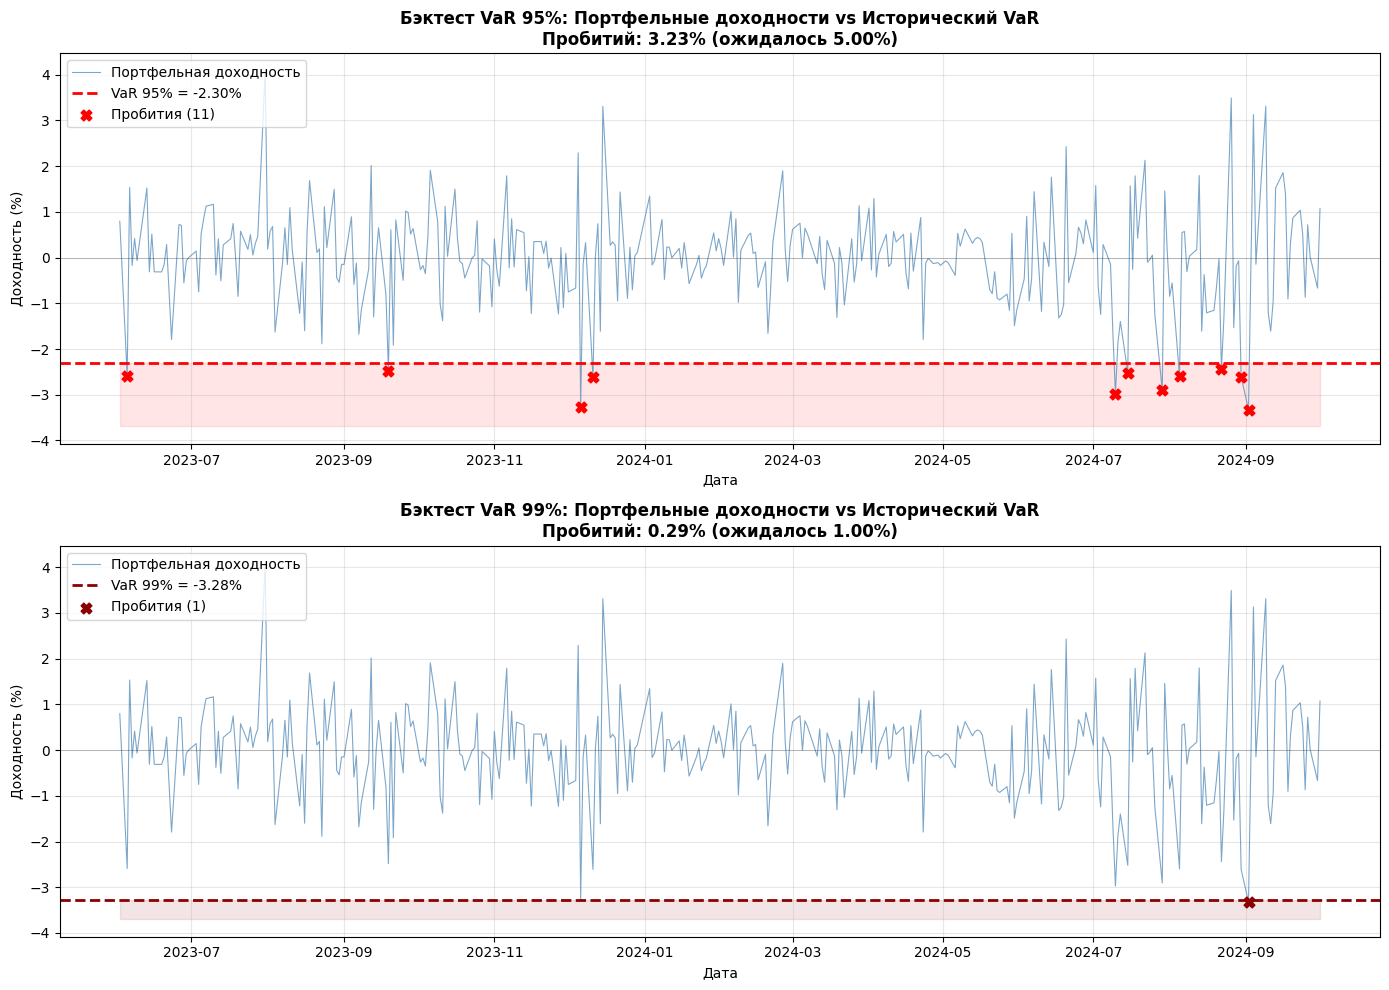

✅ Графики построены

                                 3.7.2.7: ИТОГОВАЯ СВОДКА И ВЫВОДЫ                                  

📊 ИТОГОВАЯ СВОДКА ИСТОРИЧЕСКОГО БЭКТЕСТА VaR:

                              ПЕРИОД И МЕТОДОЛОГИЯ                              
   Исходный период:      2024-11-01 - 2025-11-01 (253 дней)
   Бэктест период:       2023-06-01 - 2024-10-01 (341 дней)
   Метод расчета VaR:     ИСТОРИЧЕСКИЙ (квантили на исходном периоде)
   Активов в портфеле:   5

                ИСТОРИЧЕСКИЙ VaR (РАСЧИТАН НА ИСХОДНОМ ПЕРИОДЕ)                 
   VaR 95% (5-й процентиль):     -2.30%
   VaR 99% (1-й процентиль):     -3.28%

                   СТАТИСТИКА ДОХОДНОСТЕЙ НА БЭКТЕСТ-ПЕРИОДЕ                    
   Средняя доходность:    -0.015%
   Волатильность:          1.039%
   Min доходность:        -3.324%
   Max доходность:         4.079%

                          РЕЗУЛЬТАТЫ БЭКТЕСТА VaR 95%                           
   VaR порог:              -2.30%
   Пробитий (ожидалось):    17.1 (5.

In [ ]:
# =============================================================================
# БЛОК 3.7.2: ИСТОРИЧЕСКИЙ БЭКТЕСТ VaR (REVISED)
# =============================================================================
"""
Бэктестирование исторического Value-at-Risk (VaR) на новых данных с применением теста Купиеца.

ЦЕЛЬ:
  Проверить качество исторического VaR, рассчитанного на исходном периоде,
  на out-of-sample данных бэктест-периода.

МЕТОДОЛОГИЯ:
  1. На исходном периоде (in-sample):
     • Рассчитываем VaR_95 и VaR_99 через ИСТОРИЧЕСКИЙ метод
     • VaR = квантиль портфельных доходностей (не МК!)

  2. На бэктест-периоде (out-of-sample):
     • Берем РЕАЛЬНЫЕ портфельные доходности
     • Считаем, сколько раз они пробивают VaR пороги
     • Применяем тест Купиеца

ЭТАПЫ:
  3.7.2.1 — Проверка входных данных
  3.7.2.2 — Расчет исторического VaR на исходном периоде
  3.7.2.3 — Расчет портфельных доходностей на бэктест-периоде
  3.7.2.4 — Подсчет пробитий VaR
  3.7.2.5 — Тест Купиеца (Kupiec POF Test)
  3.7.2.6 — Визуализация результатов
  3.7.2.7 — Интерпретация и выводы

ВХОДНЫЕ ДАННЫЕ:
  - priced_df: цены на исходном периоде (из блока 1.1)
  - returns_backtest: доходности на бэктест-периоде (из блока 3.7.1)
  - backtest_data: веса портфеля (из блока 3.7.1)
  - strategy: объект HJBStrategy (из блока 3.5)

ВЫХОДНЫЕ ДАННЫЕ:
  - backtest_results: словарь с результатами бэктеста
  - kupiec_95, kupiec_99: результаты тестов Купиеца
  - breach_dates_95, breach_dates_99: даты пробитий
"""

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime

print("\n" + "=" * 100)
print("БЛОК 3.7.2: ИСТОРИЧЕСКИЙ БЭКТЕСТ VaR".center(100))
print("=" * 100 + "\n")

# =============================================================================
# 3.7.2.1: ПРОВЕРКА ВХОДНЫХ ДАННЫХ
# =============================================================================

print("=" * 100)
print("3.7.2.1: ПРОВЕРКА ВХОДНЫХ ДАННЫХ".center(100))
print("=" * 100 + "\n")

# Проверка наличия необходимых переменных
required_vars = {
    'priced_df': 'Цены на исходном периоде (из блока 1.1)',
    'returns_backtest': 'Доходности на бэктест-периоде (из блока 3.7.1)',
    'backtest_data': 'Словарь с данными бэктеста (из блока 3.7.1)',
    'strategy': 'HJBStrategy объект (из блока 3.5)'
}

print("✅ Проверка наличия данных:\n")

missing_vars = []
for var_name, description in required_vars.items():
    try:
        test_var = eval(var_name)
        print(f"   ✅ {var_name}: найдена ({description})")
    except NameError:
        missing_vars.append((var_name, description))
        print(f"   ❌ {var_name}: не найдена ({description})")

if missing_vars:
    error_msg = "\n❌ Отсутствуют следующие переменные:\n"
    for var_name, description in missing_vars:
        error_msg += f"   • {var_name} ({description})\n"
    error_msg += "\nУбедитесь, что выполнены блоки 1.1, 3.5 и 3.7.1\n"
    raise NameError(error_msg)

print()

# Извлечение данных
n_backtest_days = len(returns_backtest)
backtest_assets = list(returns_backtest.columns)
n_backtest_assets = len(backtest_assets)
n_original_days = len(priced_df)

print(f"✅ ДАННЫЕ ЗАГРУЖЕНЫ:\n")
print(f"   Исходный период:     {priced_df.index[0].date()} - {priced_df.index[-1].date()} ({n_original_days} дней)")
print(f"   Бэктест период:      {backtest_data['period_start'].date()} - {backtest_data['period_end'].date()} ({n_backtest_days} дней)")
print(f"   Активов в портфеле:  {n_backtest_assets}")
print(f"   Активы:              {', '.join(backtest_assets)}\n")

# =============================================================================
# 3.7.2.2: РАСЧЕТ ИСТОРИЧЕСКОГО VaR НА ИСХОДНОМ ПЕРИОДЕ
# =============================================================================

print("=" * 100)
print("3.7.2.2: РАСЧЕТ ИСТОРИЧЕСКОГО VaR НА ИСХОДНОМ ПЕРИОДЕ".center(100))
print("=" * 100 + "\n")

# Получаем веса портфеля
weights = strategy.get_optimal_weights()
weights = np.asarray(weights).flatten()

# Фильтруем веса только для активов, которые есть в бэктесте
weights_dict = dict(zip(backtest_data['weights_info']['asset_names'], weights))
backtest_weights = np.array([weights_dict[asset] for asset in backtest_assets])

# Нормализуем веса
backtest_weights = backtest_weights / backtest_weights.sum()

print(f"📊 Веса портфеля:\n")
for asset, w in zip(backtest_assets, backtest_weights):
    print(f"   {asset:>6} → {w*100:>6.2f}%")
print(f"   {'Сумма':>6} → {backtest_weights.sum()*100:>6.2f}%\n")

# Расчет портфельных доходностей на ИСХОДНОМ периоде
print("📈 Расчет портфельных доходностей на исходном периоде:\n")

# Берем цены только для активов, которые есть в бэктесте
prices_original = priced_df[backtest_assets]

# Вычисляем логарифмические доходности
returns_original = np.log(prices_original / prices_original.shift(1)).dropna()

# Портфельные доходности
portfolio_returns_original = (returns_original * backtest_weights).sum(axis=1)

print(f"   Количество дней:     {len(portfolio_returns_original)}")
print(f"   Средняя доходность:  {portfolio_returns_original.mean()*100:>7.3f}%")
print(f"   Волатильность:       {portfolio_returns_original.std()*100:>7.3f}%")
print(f"   Min доходность:      {portfolio_returns_original.min()*100:>7.3f}%")
print(f"   Max доходность:      {portfolio_returns_original.max()*100:>7.3f}%\n")

# Расчет VaR через исторический метод (квантили)
var_95_pct = 5  # 5-й процентиль (95% доверие)
var_99_pct = 1  # 1-й процентиль (99% доверие)

var_95_return = np.percentile(portfolio_returns_original, var_95_pct)
var_99_return = np.percentile(portfolio_returns_original, var_99_pct)

print(f"📊 ИСТОРИЧЕСКИЙ VaR (расчитан на исходном периоде):\n")
print(f"   95% VaR (5-й процентиль):")
print(f"      Доходность:   {var_95_return*100:>15.2f}%")
print(f"      Интерпретация: 5% дней доходность ниже этого значения")

print(f"\n   99% VaR (1-й процентиль):")
print(f"      Доходность:   {var_99_return*100:>15.2f}%")
print(f"      Интерпретация: 1% дней доходность ниже этого значения\n")

# Статистика для сравнения
print(f"📈 СПРАВОЧНО: Распределение доходностей на исходном периоде:\n")
percentiles = [1, 5, 25, 50, 75, 95, 99]
for pct in percentiles:
    val = np.percentile(portfolio_returns_original, pct)
    print(f"   {pct:>2}й процентиль: {val*100:>7.2f}%")

print()

# =============================================================================
# 3.7.2.3: РАСЧЕТ ПОРТФЕЛЬНЫХ ДОХОДНОСТЕЙ НА БЭКТЕСТ-ПЕРИОДЕ
# =============================================================================

print("=" * 100)
print("3.7.2.3: РАСЧЕТ ПОРТФЕЛЬНЫХ ДОХОДНОСТЕЙ НА БЭКТЕСТ-ПЕРИОДЕ".center(100))
print("=" * 100 + "\n")

# Доходности уже рассчитаны, просто вычисляем портфельные
portfolio_returns_backtest = (returns_backtest * backtest_weights).sum(axis=1)

print(f"✅ ПОРТФЕЛЬНЫЕ ДОХОДНОСТИ НА БЭКТЕСТ-ПЕРИОДЕ:\n")
print(f"   Количество дней:     {len(portfolio_returns_backtest)}")
print(f"   Средняя доходность:  {portfolio_returns_backtest.mean()*100:>7.3f}%")
print(f"   Волатильность:       {portfolio_returns_backtest.std()*100:>7.3f}%")
print(f"   Min доходность:      {portfolio_returns_backtest.min()*100:>7.3f}%")
print(f"   Max доходность:      {portfolio_returns_backtest.max()*100:>7.3f}%\n")

# =============================================================================
# 3.7.2.4: ПОДСЧЕТ ПРОБИТИЙ VaR
# =============================================================================

print("=" * 100)
print("3.7.2.4: ПОДСЧЕТ ПРОБИТИЙ VaR".center(100))
print("=" * 100 + "\n")

# Пробития VaR (когда доходность НИЖЕ VaR)
breaches_95 = portfolio_returns_backtest < var_95_return
breaches_99 = portfolio_returns_backtest < var_99_return

n_breaches_95 = breaches_95.sum()
n_breaches_99 = breaches_99.sum()

breach_rate_95 = n_breaches_95 / n_backtest_days
breach_rate_99 = n_breaches_99 / n_backtest_days

expected_breaches_95 = n_backtest_days * 0.05
expected_breaches_99 = n_backtest_days * 0.01

print(f"📉 ПРОБИТИЯ VaR 95%:\n")
print(f"   Пороговая доходность (VaR): {var_95_return*100:>7.2f}%")
print(f"   Количество пробитий:        {n_breaches_95:>7} из {n_backtest_days}")
print(f"   Частота пробитий:           {breach_rate_95*100:>7.2f}% (ожидалось 5.00%)")
print(f"   Ожидалось пробитий:         {expected_breaches_95:>7.1f}")

if breach_rate_95 > 0.05:
    emoji = "⚠️ "
    direction = "НЕДООЦЕНИВАЕТ"
elif breach_rate_95 < 0.05:
    emoji = "⚠️ "
    direction = "ПЕРЕОЦЕНИВАЕТ"
else:
    emoji = "✅"
    direction = "КОРРЕКТНА"

print(f"   {emoji} Модель {direction} риск\n")

print(f"📉 ПРОБИТИЯ VaR 99%:\n")
print(f"   Пороговая доходность (VaR): {var_99_return*100:>7.2f}%")
print(f"   Количество пробитий:        {n_breaches_99:>7} из {n_backtest_days}")
print(f"   Частота пробитий:           {breach_rate_99*100:>7.2f}% (ожидалось 1.00%)")
print(f"   Ожидалось пробитий:         {expected_breaches_99:>7.1f}")

if breach_rate_99 > 0.01:
    emoji = "⚠️ "
    direction = "НЕДООЦЕНИВАЕТ"
elif breach_rate_99 < 0.01:
    emoji = "⚠️ "
    direction = "ПЕРЕОЦЕНИВАЕТ"
else:
    emoji = "✅"
    direction = "КОРРЕКТНА"

print(f"   {emoji} Модель {direction} риск\n")

# Даты пробитий
breach_dates_95 = portfolio_returns_backtest[breaches_95].index.tolist()
breach_dates_99 = portfolio_returns_backtest[breaches_99].index.tolist()

print(f"📅 ДАТЫ ПРОБИТИЙ VaR 95% (первые 10):")
if len(breach_dates_95) > 0:
    for date in breach_dates_95[:10]:
        ret = portfolio_returns_backtest[date]
        loss = ret - var_95_return
        print(f"   {date.date()}: {ret*100:>7.2f}% (превышение: {loss*100:>6.2f}%)")
    if len(breach_dates_95) > 10:
        print(f"   ... еще {len(breach_dates_95) - 10} дат")
else:
    print(f"   Пробитий нет")

print(f"\n📅 ДАТЫ ПРОБИТИЙ VaR 99%:")
if len(breach_dates_99) > 0:
    for date in breach_dates_99:
        ret = portfolio_returns_backtest[date]
        loss = ret - var_99_return
        print(f"   {date.date()}: {ret*100:>7.2f}% (превышение: {loss*100:>6.2f}%)")
else:
    print(f"   Пробитий нет")

print()

# =============================================================================
# 3.7.2.5: ТЕСТ КУПИЕЦА (KUPIEC POF TEST)
# =============================================================================

print("=" * 100)
print("3.7.2.5: ТЕСТ КУПИЕЦА (KUPIEC PROPORTION OF FAILURES TEST)".center(100))
print("=" * 100 + "\n")

print("📖 ТЕОРИЯ ТЕСТА КУПИЕЦА:\n")
print("   Тест проверяет, соответствует ли частота пробитий VaR ожидаемой.")
print("   H₀ (нулевая гипотеза): модель VaR корректна (частота = ожидаемая)")
print("   H₁ (альтернатива): модель VaR некорректна (частота ≠ ожидаемая)\n")
print("   Статистика теста: LR = -2 * log(L₀/L₁)")
print("   Распределение: χ²(1) при H₀")
print("   Уровень значимости: α = 0.05 (критическое значение ≈ 3.84)\n")

def kupiec_test(n_breaches, n_observations, confidence_level):
    """
    Тест Купиеца (Kupiec POF Test).

    Parameters:
    -----------
    n_breaches : int
        Количество пробитий VaR
    n_observations : int
        Общее количество наблюдений
    confidence_level : float
        Уровень доверия VaR (0.95 или 0.99)

    Returns:
    --------
    dict : результаты теста
    """
    alpha = 1 - confidence_level  # Ожидаемая частота пробитий
    p_hat = n_breaches / n_observations  # Наблюдаемая частота

    # Избегаем деления на ноль
    if p_hat == 0:
        p_hat = 1e-10
    if p_hat == 1:
        p_hat = 1 - 1e-10

    # Likelihood Ratio статистика
    if n_breaches == 0:
        lr_stat = -2 * n_observations * np.log(1 - alpha)
    elif n_breaches == n_observations:
        lr_stat = -2 * n_observations * np.log(alpha)
    else:
        L0 = (alpha ** n_breaches) * ((1 - alpha) ** (n_observations - n_breaches))
        L1 = (p_hat ** n_breaches) * ((1 - p_hat) ** (n_observations - n_breaches))
        lr_stat = -2 * np.log(L0 / L1)

    # p-value из χ²(1) распределения
    p_value = 1 - stats.chi2.cdf(lr_stat, df=1)

    # Критическое значение на уровне α = 0.05
    critical_value = stats.chi2.ppf(0.95, df=1)

    # Решение
    reject_h0 = lr_stat > critical_value

    return {
        'lr_statistic': lr_stat,
        'p_value': p_value,
        'critical_value': critical_value,
        'reject_h0': reject_h0,
        'expected_breaches': n_observations * alpha,
        'observed_breaches': n_breaches,
        'expected_rate': alpha,
        'observed_rate': p_hat
    }

# Тест для VaR 95%
print("=" * 80)
print("ТЕСТ КУПИЕЦА ДЛЯ VaR 95%".center(80))
print("=" * 80 + "\n")

kupiec_95 = kupiec_test(n_breaches_95, n_backtest_days, 0.95)

print(f"📊 РЕЗУЛЬТАТЫ:\n")
print(f"   Наблюдений:           {n_backtest_days}")
print(f"   Пробитий (ожидалось): {kupiec_95['expected_breaches']:.1f} (5.00%)")
print(f"   Пробитий (наблюдено): {kupiec_95['observed_breaches']} ({kupiec_95['observed_rate']*100:.2f}%)")
print(f"\n   LR-статистика:        {kupiec_95['lr_statistic']:.4f}")
print(f"   Критическое значение: {kupiec_95['critical_value']:.4f} (α = 0.05)")
print(f"   p-value:              {kupiec_95['p_value']:.4f}")

print(f"\n📋 ВЫВОД:")
if kupiec_95['reject_h0']:
    print(f"   ❌ Отвергаем H₀ (p = {kupiec_95['p_value']:.4f} < 0.05)")
    print(f"   → VaR 95% РАБОТАЕТ НЕКОРРЕКТНО")
    if kupiec_95['observed_rate'] > kupiec_95['expected_rate']:
        print(f"   → Модель НЕДООЦЕНИВАЕТ риск ({kupiec_95['observed_rate']*100:.2f}% пробитий вместо 5%)")
    else:
        print(f"   → Модель ПЕРЕОЦЕНИВАЕТ риск ({kupiec_95['observed_rate']*100:.2f}% пробитий вместо 5%)")
else:
    print(f"   ✅ Не отвергаем H₀ (p = {kupiec_95['p_value']:.4f} > 0.05)")
    print(f"   → VaR 95% РАБОТАЕТ КОРРЕКТНО")

# Тест для VaR 99%
print(f"\n" + "=" * 80)
print("ТЕСТ КУПИЕЦА ДЛЯ VaR 99%".center(80))
print("=" * 80 + "\n")

kupiec_99 = kupiec_test(n_breaches_99, n_backtest_days, 0.99)

print(f"📊 РЕЗУЛЬТАТЫ:\n")
print(f"   Наблюдений:           {n_backtest_days}")
print(f"   Пробитий (ожидалось): {kupiec_99['expected_breaches']:.1f} (1.00%)")
print(f"   Пробитий (наблюдено): {kupiec_99['observed_breaches']} ({kupiec_99['observed_rate']*100:.2f}%)")
print(f"\n   LR-статистика:        {kupiec_99['lr_statistic']:.4f}")
print(f"   Критическое значение: {kupiec_99['critical_value']:.4f} (α = 0.05)")
print(f"   p-value:              {kupiec_99['p_value']:.4f}")

print(f"\n📋 ВЫВОД:")
if kupiec_99['reject_h0']:
    print(f"   ❌ Отвергаем H₀ (p = {kupiec_99['p_value']:.4f} < 0.05)")
    print(f"   → VaR 99% РАБОТАЕТ НЕКОРРЕКТНО")
    if kupiec_99['observed_rate'] > kupiec_99['expected_rate']:
        print(f"   → Модель НЕДООЦЕНИВАЕТ риск ({kupiec_99['observed_rate']*100:.2f}% пробитий вместо 1%)")
    else:
        print(f"   → Модель ПЕРЕОЦЕНИВАЕТ риск ({kupiec_99['observed_rate']*100:.2f}% пробитий вместо 1%)")
else:
    print(f"   ✅ Не отвергаем H₀ (p = {kupiec_99['p_value']:.4f} > 0.05)")
    print(f"   → VaR 99% РАБОТАЕТ КОРРЕКТНО")

print()

# =============================================================================
# 3.7.2.6: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# =============================================================================

print("=" * 100)
print("3.7.2.6: ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ".center(100))
print("=" * 100 + "\n")

try:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # График 1: Доходности портфеля и VaR 95%
    ax1 = axes[0]
    ax1.plot(portfolio_returns_backtest.index, portfolio_returns_backtest.values * 100,
             label='Портфельная доходность', linewidth=0.8, alpha=0.7, color='steelblue')
    ax1.axhline(y=var_95_return * 100, color='red', linestyle='--',
                label=f'VaR 95% = {var_95_return*100:.2f}%', linewidth=2)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    # Отметки пробитий
    if len(breach_dates_95) > 0:
        breach_returns_95 = portfolio_returns_backtest[breach_dates_95] * 100
        ax1.scatter(breach_dates_95, breach_returns_95, color='red',
                   s=60, zorder=5, marker='X', label=f'Пробития ({n_breaches_95})')

    ax1.set_title(f'Бэктест VaR 95%: Портфельные доходности vs Исторический VaR\n' +
                  f'Пробитий: {breach_rate_95*100:.2f}% (ожидалось 5.00%)',
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Доходность (%)')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.fill_between(portfolio_returns_backtest.index, var_95_return * 100,
                     ax1.get_ylim()[0], alpha=0.1, color='red', label='Зона риска')

    # График 2: Доходности портфеля и VaR 99%
    ax2 = axes[1]
    ax2.plot(portfolio_returns_backtest.index, portfolio_returns_backtest.values * 100,
             label='Портфельная доходность', linewidth=0.8, alpha=0.7, color='steelblue')
    ax2.axhline(y=var_99_return * 100, color='darkred', linestyle='--',
                label=f'VaR 99% = {var_99_return*100:.2f}%', linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    # Отметки пробитий
    if len(breach_dates_99) > 0:
        breach_returns_99 = portfolio_returns_backtest[breach_dates_99] * 100
        ax2.scatter(breach_dates_99, breach_returns_99, color='darkred',
                   s=60, zorder=5, marker='X', label=f'Пробития ({n_breaches_99})')

    ax2.set_title(f'Бэктест VaR 99%: Портфельные доходности vs Исторический VaR\n' +
                  f'Пробитий: {breach_rate_99*100:.2f}% (ожидалось 1.00%)',
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Дата')
    ax2.set_ylabel('Доходность (%)')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.fill_between(portfolio_returns_backtest.index, var_99_return * 100,
                     ax2.get_ylim()[0], alpha=0.1, color='darkred', label='Зона риска')

    plt.tight_layout()
    plt.show()

    print("✅ Графики построены\n")

except Exception as e:
    print(f"⚠️  Ошибка при построении графиков: {e}\n")

# =============================================================================
# 3.7.2.7: ИТОГОВАЯ СВОДКА И ВЫВОДЫ
# =============================================================================

print("=" * 100)
print("3.7.2.7: ИТОГОВАЯ СВОДКА И ВЫВОДЫ".center(100))
print("=" * 100 + "\n")

# Сохранение результатов
backtest_results = {
    # Общие параметры
    'n_days': n_backtest_days,
    'period_start': backtest_data['period_start'],
    'period_end': backtest_data['period_end'],
    'n_original_days': n_original_days,
    'var_method': 'historical',

    # VaR из исходного периода (исторический метод)
    'var_95_return': var_95_return,
    'var_99_return': var_99_return,

    # Портфельные доходности
    'portfolio_returns': portfolio_returns_backtest,
    'mean_return': portfolio_returns_backtest.mean(),
    'std_return': portfolio_returns_backtest.std(),
    'min_return': portfolio_returns_backtest.min(),
    'max_return': portfolio_returns_backtest.max(),

    # Пробития VaR 95%
    'breaches_95': n_breaches_95,
    'breach_rate_95': breach_rate_95,
    'expected_breaches_95': expected_breaches_95,
    'breach_dates_95': breach_dates_95,

    # Пробития VaR 99%
    'breaches_99': n_breaches_99,
    'breach_rate_99': breach_rate_99,
    'expected_breaches_99': expected_breaches_99,
    'breach_dates_99': breach_dates_99,

    # Тест Купиеца
    'kupiec_95': kupiec_95,
    'kupiec_99': kupiec_99
}

print("📊 ИТОГОВАЯ СВОДКА ИСТОРИЧЕСКОГО БЭКТЕСТА VaR:\n")
print(f"{'='*80}")
print(f"ПЕРИОД И МЕТОДОЛОГИЯ".center(80))
print(f"{'='*80}")
print(f"   Исходный период:      {priced_df.index[0].date()} - {priced_df.index[-1].date()} ({n_original_days} дней)")
print(f"   Бэктест период:       {backtest_data['period_start'].date()} - {backtest_data['period_end'].date()} ({n_backtest_days} дней)")
print(f"   Метод расчета VaR:     ИСТОРИЧЕСКИЙ (квантили на исходном периоде)")
print(f"   Активов в портфеле:   {n_backtest_assets}")

print(f"\n{'='*80}")
print(f"ИСТОРИЧЕСКИЙ VaR (РАСЧИТАН НА ИСХОДНОМ ПЕРИОДЕ)".center(80))
print(f"{'='*80}")
print(f"   VaR 95% (5-й процентиль):   {var_95_return*100:>7.2f}%")
print(f"   VaR 99% (1-й процентиль):   {var_99_return*100:>7.2f}%")

print(f"\n{'='*80}")
print(f"СТАТИСТИКА ДОХОДНОСТЕЙ НА БЭКТЕСТ-ПЕРИОДЕ".center(80))
print(f"{'='*80}")
print(f"   Средняя доходность:   {backtest_results['mean_return']*100:>7.3f}%")
print(f"   Волатильность:        {backtest_results['std_return']*100:>7.3f}%")
print(f"   Min доходность:       {backtest_results['min_return']*100:>7.3f}%")
print(f"   Max доходность:       {backtest_results['max_return']*100:>7.3f}%")

print(f"\n{'='*80}")
print(f"РЕЗУЛЬТАТЫ БЭКТЕСТА VaR 95%".center(80))
print(f"{'='*80}")
print(f"   VaR порог:            {var_95_return*100:>7.2f}%")
print(f"   Пробитий (ожидалось): {expected_breaches_95:>7.1f} (5.00%)")
print(f"   Пробитий (наблюдено): {n_breaches_95:>7} ({breach_rate_95*100:.2f}%)")
print(f"   Тест Купиеца:")
print(f"      LR-статистика:     {kupiec_95['lr_statistic']:>7.4f}")
print(f"      p-value:           {kupiec_95['p_value']:>7.4f}")
print(f"      Результат:         {'❌ ОТВЕРГНУТЬ H₀' if kupiec_95['reject_h0'] else '✅ НЕ ОТВЕРГАТЬ H₀'}")

print(f"\n{'='*80}")
print(f"РЕЗУЛЬТАТЫ БЭКТЕСТА VaR 99%".center(80))
print(f"{'='*80}")
print(f"   VaR порог:            {var_99_return*100:>7.2f}%")
print(f"   Пробитий (ожидалось): {expected_breaches_99:>7.1f} (1.00%)")
print(f"   Пробитий (наблюдено): {n_breaches_99:>7} ({breach_rate_99*100:.2f}%)")
print(f"   Тест Купиеца:")
print(f"      LR-статистика:     {kupiec_99['lr_statistic']:>7.4f}")
print(f"      p-value:           {kupiec_99['p_value']:>7.4f}")
print(f"      Результат:         {'❌ ОТВЕРГНУТЬ H₀' if kupiec_99['reject_h0'] else '✅ НЕ ОТВЕРГАТЬ H₀'}")

print(f"\n{'='*80}")
print(f"ФИНАЛЬНЫЙ ВЫВОД".center(80))
print(f"{'='*80}\n")

# Общая оценка модели
if not kupiec_95['reject_h0'] and not kupiec_99['reject_h0']:
    print("   ✅ ИСТОРИЧЕСКИЙ VaR РАБОТАЕТ КОРРЕКТНО")
    print("      Оба тесты (95% и 99%) не отвергают нулевую гипотезу.")
    print("      Частота пробитий соответствует ожидаемой на бэктест-периоде.")
elif kupiec_95['reject_h0'] and kupiec_99['reject_h0']:
    print("   ❌ ИСТОРИЧЕСКИЙ VaR РАБОТАЕТ НЕКОРРЕКТНО")
    print("      Оба тесты (95% и 99%) отвергают нулевую гипотезу.")
    if breach_rate_95 > 0.05 and breach_rate_99 > 0.01:
        print("      → Модель НЕДООЦЕНИВАЕТ риск на бэктест-периоде")
        print("      → Возможен режимный сдвиг (выше волатильность)")
    else:
        print("      → Модель ПЕРЕОЦЕНИВАЕТ риск на бэктест-периоде")
else:
    print("   ⚠️  ИСТОРИЧЕСКИЙ VaR РАБОТАЕТ ЧАСТИЧНО КОРРЕКТНО")
    if kupiec_95['reject_h0']:
        print("      VaR 95% отвергнут, VaR 99% не отвергнут")
    else:
        print("      VaR 99% отвергнут, VaR 95% не отвергнут")

print(f"\n📦 ДОСТУПНЫЕ ПЕРЕМЕННЫЕ:\n")
print(f"   backtest_results:         словарь со всеми результатами")
print(f"   portfolio_returns_backtest: временной ряд доходностей бэктеста")
print(f"   portfolio_returns_original: временной ряд доходностей исходного периода")
print(f"   breach_dates_95:          список дат пробития VaR 95%")
print(f"   breach_dates_99:          список дат пробития VaR 99%")
print(f"   var_95_return, var_99_return: VaR пороги в процентах\n")

print("=" * 100)
print("✅ БЛОК 3.7.2 ЗАВЕРШЕН".center(100))
print("=" * 100 + "\n")

**3.7.3 Бэктестинг VaR, рассчитанного через Монте-Карло**


                    БЛОК 3.7.3: МОНТЕ-КАРЛО БЭКТЕСТ VaR (С ФИЛЬТРАЦИЕЙ АКТИВОВ)                     

                          3.7.3.0: СОГЛАСОВАНИЕ АКТИВОВ С БЭКТЕСТ-ПЕРИОДОМ                          

📋 АКТИВЫ ИЗ БЭКТЕСТ-ПЕРИОДА (3.7.2):
   SBER, TATN, PHOR, NVTK, PLZL
   Количество активов: 5

📋 АКТИВЫ ИЗ СТРАТЕГИИ (3.5):
   SBER, GAZP, YDEX, TATN, MOEX, PHOR, NVTK, LKOH, PLZL, VTBR
   Количество активов: 10

📋 ПЕРЕСЕЧЕНИЕ АКТИВОВ:
   NVTK, PHOR, PLZL, SBER, TATN
   Количество активов: 5

⚠️  ВНИМАНИЕ: в стратегии есть лишние активы!
   Лишние активы: MOEX, YDEX, VTBR, LKOH, GAZP
   → Они будут ИСКЛЮЧЕНЫ из МК симуляции

✅ ДЛЯ МК СИМУЛЯЦИИ БУДУТ ИСПОЛЬЗОВАНЫ:
   NVTK, PHOR, PLZL, SBER, TATN
   Количество активов: 5

                                  3.7.3.1: ПРОВЕРКА ВХОДНЫХ ДАННЫХ                                  

✅ Проверка наличия данных:

   ✅ results: найдена (Результаты из блока 3.5)
   ✅ strategy: найдена (HJBStrategy объект (из блока 3.5))
   ✅ X_0: найдена (Начальный кап

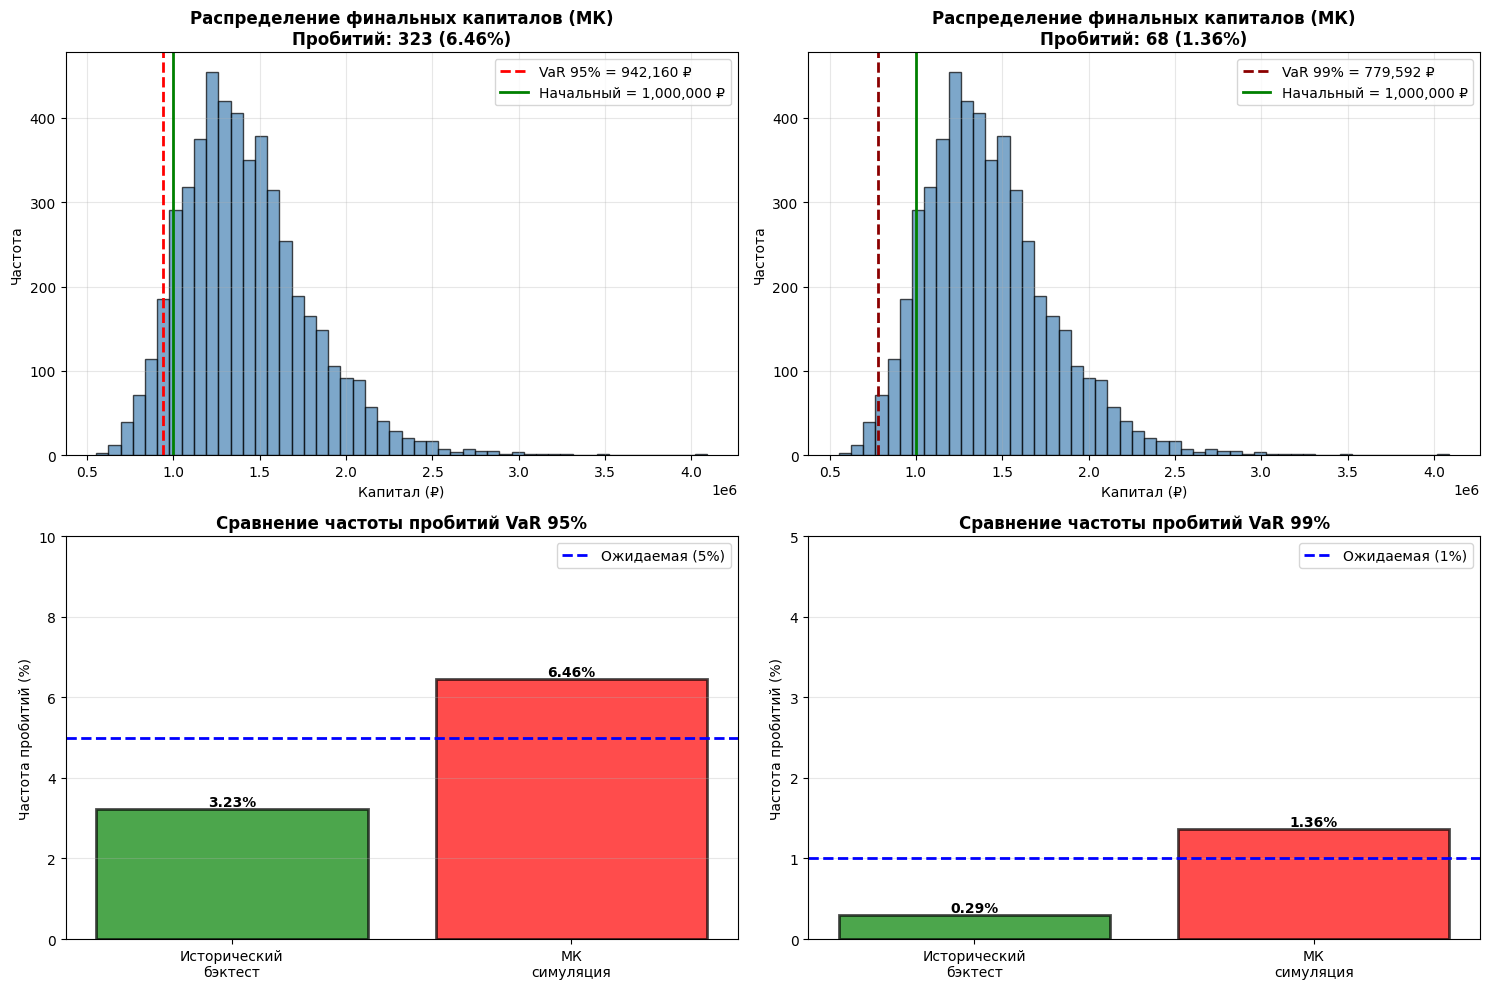

✅ Графики построены

📊 ИТОГОВАЯ СВОДКА МК БЭКТЕСТА:

                          РЕЗУЛЬТАТЫ БЭКТЕСТА VaR 95%                           
   Пробитий (ожидалось):    250.0 (5.00%)
   Пробитий (наблюдено):      323 (6.46%)
   LR-статистика:         20.6273
   p-value:               0.000006
   Результат:             ❌ ОТВЕРГНУТЬ H₀

                          РЕЗУЛЬТАТЫ БЭКТЕСТА VaR 99%                           
   Пробитий (ожидалось):     50.0 (1.00%)
   Пробитий (наблюдено):       68 (1.36%)
   LR-статистика:          5.8835
   p-value:               0.015284
   Результат:             ❌ ОТВЕРГНУТЬ H₀

                                ФИНАЛЬНЫЙ ВЫВОД                                 

✅ АКТИВЫ СОГЛАСОВАНЫ МЕЖДУ БЛОКАМИ:
   • 3.7.2 (исторический): SBER, TATN, PHOR, NVTK, PLZL
   • 3.7.3 (МК):           NVTK, PHOR, PLZL, SBER, TATN

❌ МК МОДЕЛЬ VaR НЕКОРРЕКТНА
   → Проблема в самой модели/калибровке

📦 ДОСТУПНЫЕ ПЕРЕМЕННЫЕ:

   mc_backtest_results, X_paths_backtest, final_capitals_backtest

 

In [ ]:
# =============================================================================
# БЛОК 3.7.3: МОНТЕ-КАРЛО БЭКТЕСТ VaR (МК СИМУЛЯЦИЯ НА БЭКТЕСТ-ПЕРИОДЕ)
# =============================================================================
"""
Бэктестирование Value-at-Risk (VaR) путем запуска Монте-Карло симуляции на бэктест-периоде
с параметрами исходного периода и применением теста Купиеца.

ЦЕЛЬ:
  Проверить качество калибровки модели VaR в контролируемых условиях,
  без влияния режимных сдвигов и изменения параметров.

МЕТОДОЛОГИЯ:
  1. На исходном периоде (in-sample):
     • Рассчитываем параметры: μ, Σ (доходности и ковариация)
     • Считаем VaR_95 и VaR_99 из МК симуляции
     • СОХРАНЯЕМ эти пороги в процентах

  2. На бэктест-периоде (out-of-sample, но СИНТЕТИЧЕСКИЕ данные):
     • Запускаем НОВУЮ МК симуляцию с ТЕМ ЖЕ количеством путей и дней
     • Используем параметры (μ, Σ) ИЗ ИСХОДНОГО периода
     • На НОВЫХ случайных числах (разные seed)
     • Получаем новые траектории капитала

  3. Тест Купиеца:
     • Сравниваем VaR пороги из шага 1 с финальными капиталами из новой симуляции
     • Считаем пробития
     • Применяем тест Купиеца

ПРЕИМУЩЕСТВА:
  ✅ Чистая проверка калибровки (без режимных сдвигов)
  ✅ Все данные синтетические (контролируемые условия)
  ✅ Тест Купиеца статистически корректный
  ✅ Изолируем проблемы модели от влияния реального рынка

ЭТАПЫ:
  3.7.3.1 — Проверка входных данных
  3.7.3.2 — Извлечение параметров модели из блока 3.5
  3.7.3.3 — Запуск новой МК симуляции на бэктест-периоде
  3.7.3.4 — Подсчет пробитий VaR из новой симуляции
  3.7.3.5 — Тест Купиеца для МК результатов
  3.7.3.6 — Сравнение с историческим бэктестом
  3.7.3.7 — Визуализация и выводы

ВХОДНЫЕ ДАННЫЕ:
  - results: метрики из блока 3.5 (включая VaR)
  - strategy: объект HJBStrategy (из блока 3.5)
  - X_0: начальный капитал (из блока 3.5)
  - backtest_data: информация о периоде (из блока 3.7.1)
  - backtest_results: результаты исторического бэктеста (из блока 3.7.2)

ВЫХОДНЫЕ ДАННЫЕ:
  - mc_backtest_results: словарь с результатами МК бэктеста
  - kupiec_95_mc, kupiec_99_mc: результаты тестов Купиеца
  - X_paths_backtest: траектории капитала из новой МК симуляции
"""
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import time

print("\n" + "=" * 100)
print("БЛОК 3.7.3: МОНТЕ-КАРЛО БЭКТЕСТ VaR (С ФИЛЬТРАЦИЕЙ АКТИВОВ)".center(100))
print("=" * 100 + "\n")

# =============================================================================
# 3.7.3.0: ПОЛУЧЕНИЕ АКТИВОВ ИЗ БЭКТЕСТ-ПЕРИОДА
# =============================================================================

print("=" * 100)
print("3.7.3.0: СОГЛАСОВАНИЕ АКТИВОВ С БЭКТЕСТ-ПЕРИОДОМ".center(100))
print("=" * 100 + "\n")

# Активы из блока 3.7.2 (исторический бэктест)
if 'backtest_data' in locals() and 'asset_names' in backtest_data:
    backtest_assets = backtest_data['asset_names']
elif 'returns_backtest' in locals() and hasattr(returns_backtest, 'columns'):
    backtest_assets = returns_backtest.columns.tolist()
else:
    raise ValueError("❌ Не удается определить активы из бэктест-периода (3.7.2)")

print(f"📋 АКТИВЫ ИЗ БЭКТЕСТ-ПЕРИОДА (3.7.2):\n   {', '.join(backtest_assets)}")
print(f"   Количество активов: {len(backtest_assets)}\n")

# Активы из блока 3.5 (исходная стратегия)
strategy_assets = strategy.asset_names

print(f"📋 АКТИВЫ ИЗ СТРАТЕГИИ (3.5):\n   {', '.join(strategy_assets)}")
print(f"   Количество активов: {len(strategy_assets)}\n")

# Пересечение активов
common_assets = list(set(backtest_assets) & set(strategy_assets))
common_assets.sort()

print(f"📋 ПЕРЕСЕЧЕНИЕ АКТИВОВ:\n   {', '.join(common_assets)}")
print(f"   Количество активов: {len(common_assets)}\n")

# Проверка соответствия
if len(common_assets) != len(backtest_assets):
    print(f"⚠️  ВНИМАНИЕ: не все активы бэктеста есть в стратегии!")
    missing_in_strategy = set(backtest_assets) - set(strategy_assets)
    if missing_in_strategy:
        print(f"   Отсутствуют в стратегии: {', '.join(missing_in_strategy)}\n")

if len(common_assets) != len(strategy_assets):
    print(f"⚠️  ВНИМАНИЕ: в стратегии есть лишние активы!")
    extra_in_strategy = set(strategy_assets) - set(backtest_assets)
    if extra_in_strategy:
        print(f"   Лишние активы: {', '.join(extra_in_strategy)}")
        print(f"   → Они будут ИСКЛЮЧЕНЫ из МК симуляции\n")

# Используем пересечение (активы, которые есть везде)
filtered_assets = common_assets

print(f"✅ ДЛЯ МК СИМУЛЯЦИИ БУДУТ ИСПОЛЬЗОВАНЫ:\n   {', '.join(filtered_assets)}")
print(f"   Количество активов: {len(filtered_assets)}\n")

# =============================================================================
# 3.7.3.1: ПРОВЕРКА ВХОДНЫХ ДАННЫХ
# =============================================================================

print("=" * 100)
print("3.7.3.1: ПРОВЕРКА ВХОДНЫХ ДАННЫХ".center(100))
print("=" * 100 + "\n")

required_vars = {
    'results': 'Результаты из блока 3.5',
    'strategy': 'HJBStrategy объект (из блока 3.5)',
    'X_0': 'Начальный капитал (из блока 3.5)',
    'backtest_data': 'Информация о периоде (из блока 3.7.1)',
    'backtest_results': 'Результаты исторического бэктеста (из блока 3.7.2)',
    't_grid': 'Временная сетка (из блока 3.5)'
}

print("✅ Проверка наличия данных:\n")

missing_vars = []
for var_name, description in required_vars.items():
    try:
        test_var = eval(var_name)
        print(f"   ✅ {var_name}: найдена ({description})")
    except NameError:
        missing_vars.append((var_name, description))
        print(f"   ❌ {var_name}: не найдена ({description})")

if missing_vars:
    error_msg = "\n❌ Отсутствуют следующие переменные:\n"
    for var_name, description in missing_vars:
        error_msg += f"   • {var_name} ({description})\n"
    error_msg += "\nУбедитесь, что выполнены блоки 3.5, 3.7.1 и 3.7.2\n"
    raise NameError(error_msg)

print()

# =============================================================================
# 3.7.3.2: ИЗВЛЕЧЕНИЕ И ФИЛЬТРАЦИЯ ПАРАМЕТРОВ МОДЕЛИ
# =============================================================================

print("=" * 100)
print("3.7.3.2: ИЗВЛЕЧЕНИЕ И ФИЛЬТРАЦИЯ ПАРАМЕТРОВ МОДЕЛИ".center(100))
print("=" * 100 + "\n")

try:
    var_95_mc_original = results['var_capital_95']
    var_99_mc_original = results['var_capital_99']

    var_95_return_mc = (var_95_mc_original - X_0) / X_0
    var_99_return_mc = (var_99_mc_original - X_0) / X_0

    print(f"📊 VaR ИЗ ИСХОДНОЙ МК СИМУЛЯЦИИ (блок 3.5):\n")
    print(f"   95% VaR:")
    print(f"      Капитал:      {var_95_mc_original:>15,.0f} ₽")
    print(f"      Доходность:   {var_95_return_mc*100:>15.2f}%")

    print(f"\n   99% VaR:")
    print(f"      Капитал:      {var_99_mc_original:>15,.0f} ₽")
    print(f"      Доходность:   {var_99_return_mc*100:>15.2f}%\n")

except KeyError as e:
    print(f"❌ ОШИБКА: В results отсутствует ключ {e}\n")
    raise

# Фильтруем параметры стратегии по активам бэктеста
mu_full = strategy.mu
cov_matrix_full = strategy.cov_matrix
asset_names_full = strategy.asset_names

# Индексы для фильтрации
asset_indices = [list(asset_names_full).index(asset) for asset in filtered_assets]

# Фильтрованные параметры
mu = mu_full[asset_indices]
cov_matrix = cov_matrix_full[np.ix_(asset_indices, asset_indices)]
asset_names = filtered_assets

n_assets = len(asset_names)
rf = strategy.risk_free_rate
gamma = strategy.gamma

print(f"🔧 ПАРАМЕТРЫ СТРАТЕГИИ (ПОСЛЕ ФИЛЬТРАЦИИ):\n")
print(f"   Активов:              {n_assets}")
print(f"   Активы:               {', '.join(asset_names)}")
print(f"   Коэффициент риск-аверсии (γ): {gamma:.1f}")
print(f"   Безрисковая ставка:   {rf*100:.2f}%")

print(f"\n📊 ПАРАМЕТРЫ ДИНАМИКИ (ПОСЛЕ ФИЛЬТРАЦИИ):\n")
print(f"   Среднее (μ) вектор:\n   {mu}\n")
print(f"   Ковариационная матрица (фрагмент):\n   {cov_matrix[:3, :3]}\n")

T = t_grid[-1]
n_steps = len(t_grid)
dt = T / (n_steps - 1)

print(f"⏱️  ПАРАМЕТРЫ ИСХОДНОЙ СИМУЛЯЦИИ:\n")
print(f"   Временной горизонт:   {T:.1f} {'год' if T == 1 else 'года'}")
print(f"   Временных шагов:      {n_steps}")
print(f"   Количество путей:     {len(X_paths):,}\n")

# =============================================================================
# 3.7.3.3: ЗАПУСК НОВОЙ МК СИМУЛЯЦИИ НА БЭКТЕСТ-ПЕРИОДЕ
# =============================================================================

print("=" * 100)
print("3.7.3.3: ЗАПУСК НОВОЙ МК СИМУЛЯЦИИ НА БЭКТЕСТ-ПЕРИОДЕ".center(100))
print("=" * 100 + "\n")

eigenvalues = np.linalg.eigvalsh(cov_matrix)
min_eig = eigenvalues.min()

if min_eig > 1e-10:
    L = np.linalg.cholesky(cov_matrix)
else:
    epsilon = max(1e-6, abs(min_eig) * 10)
    cov_matrix_reg = cov_matrix + epsilon * np.eye(n_assets)
    L = np.linalg.cholesky(cov_matrix_reg)

n_paths_backtest = len(X_paths)
random_seed_backtest = 123

np.random.seed(random_seed_backtest)

print(f"⚙️  Параметры МК симуляции на бэктест-периоде:\n")
print(f"   Траекторий (n_paths):    {n_paths_backtest:,}")
print(f"   Временных шагов:         {n_steps}")
print(f"   Активов (отфильтровано): {n_assets}")
print(f"   Random seed:             {random_seed_backtest}\n")

print(f"⏳ Запуск симуляции...\n")

start_time = time.time()

X_paths_backtest = np.zeros((n_paths_backtest, n_steps))
X_paths_backtest[:, 0] = X_0

dW = np.random.randn(n_paths_backtest, n_steps - 1, n_assets)
dR = np.zeros((n_paths_backtest, n_steps - 1, n_assets))

for t in range(n_steps - 1):
    dZ = dW[:, t, :] @ L.T
    dR[:, t, :] = (mu - 0.5 * np.diag(cov_matrix)) * dt + np.sqrt(dt) * dZ

    # Вычисляем оптимальные веса для отфильтрованного портфеля
    weights_t = strategy.get_optimal_weights()
    # Берем только компоненты для отфильтрованных активов
    weights_t = weights_t[asset_indices]
    # Перенормируем (важно, если сумма не 1)
    weights_t = weights_t / weights_t.sum()

    portfolio_return = np.sum(dR[:, t, :] * weights_t, axis=1)

    X_paths_backtest[:, t + 1] = X_paths_backtest[:, t] * np.exp(portfolio_return)

    if (t + 1) % (n_steps // 4) == 0:
        print(f"   Обработано {t + 1}/{n_steps - 1} временных шагов...")

elapsed = time.time() - start_time

print(f"\n✅ МК симуляция завершена за {elapsed:.2f} сек\n")

# =============================================================================
# 3.7.3.4: ПОДСЧЕТ ПРОБИТИЙ VaR ИЗ НОВОЙ СИМУЛЯЦИИ
# =============================================================================

print("=" * 100)
print("3.7.3.4: ПОДСЧЕТ ПРОБИТИЙ VaR ИЗ НОВОЙ МК СИМУЛЯЦИИ".center(100))
print("=" * 100 + "\n")

final_capitals_backtest = X_paths_backtest[:, -1]
final_returns_backtest = (final_capitals_backtest - X_0) / X_0

breaches_95_mc = final_capitals_backtest < var_95_mc_original
breaches_99_mc = final_capitals_backtest < var_99_mc_original

n_breaches_95_mc = breaches_95_mc.sum()
n_breaches_99_mc = breaches_99_mc.sum()

breach_rate_95_mc = n_breaches_95_mc / n_paths_backtest
breach_rate_99_mc = n_breaches_99_mc / n_paths_backtest

expected_breaches_95_mc = n_paths_backtest * 0.05
expected_breaches_99_mc = n_paths_backtest * 0.01

print(f"📊 СТАТИСТИКА ФИНАЛЬНЫХ КАПИТАЛОВ ИЗ НОВОЙ МК СИМУЛЯЦИИ:\n")
print(f"   Среднее значение:     {final_capitals_backtest.mean():>15,.0f} ₽")
print(f"   Медиана:              {np.median(final_capitals_backtest):>15,.0f} ₽")
print(f"   Std Dev:              {final_capitals_backtest.std():>15,.0f} ₽")
print(f"   Min:                  {final_capitals_backtest.min():>15,.0f} ₽")
print(f"   Max:                  {final_capitals_backtest.max():>15,.0f} ₽\n")

print(f"📉 ПРОБИТИЯ VaR 95% (МК СИМУЛЯЦИЯ):\n")
print(f"   VaR порог капитала:     {var_95_mc_original:>15,.0f} ₽ ({var_95_return_mc*100:>6.2f}%)")
print(f"   Количество пробитий:    {n_breaches_95_mc:>7} из {n_paths_backtest:,}")
print(f"   Частота пробитий:       {breach_rate_95_mc*100:>7.2f}% (ожидалось 5.00%)")
print(f"   Ожидалось пробитий:     {expected_breaches_95_mc:>7.1f}\n")

print(f"📉 ПРОБИТИЯ VaR 99% (МК СИМУЛЯЦИЯ):\n")
print(f"   VaR порог капитала:     {var_99_mc_original:>15,.0f} ₽ ({var_99_return_mc*100:>6.2f}%)")
print(f"   Количество пробитий:    {n_breaches_99_mc:>7} из {n_paths_backtest:,}")
print(f"   Частота пробитий:       {breach_rate_99_mc*100:>7.2f}% (ожидалось 1.00%)")
print(f"   Ожидалось пробитий:     {expected_breaches_99_mc:>7.1f}\n")

# =============================================================================
# 3.7.3.5: ТЕСТ КУПИЕЦА - ЧИСЛЕННО СТАБИЛЬНАЯ ВЕРСИЯ
# =============================================================================

print("=" * 100)
print("3.7.3.5: ТЕСТ КУПИЕЦА - ЧИСЛЕННО СТАБИЛЬНАЯ ВЕРСИЯ".center(100))
print("=" * 100 + "\n")

def kupiec_test_stable(n_breaches, n_observations, confidence_level):
    """
    Численно-стабильная версия теста Купиеца.

    ИСПРАВЛЕНИЕ: Используется логарифмическая форма вместо явного вычисления
    функций правдоподобия, что позволяет избежать NaN при маленьких вероятностях.
    """
    alpha = 1 - confidence_level
    p_hat = n_breaches / n_observations

    # ==========================================
    # ЧИСЛЕННО СТАБИЛЬНЫЙ РАСЧЕТ LR СТАТИСТИКИ
    # ==========================================

    if n_breaches == 0:
        lr_stat = -2 * n_observations * np.log(1 - alpha)
    elif n_breaches == n_observations:
        lr_stat = -2 * n_observations * np.log(alpha)
    else:
        # ЧИСЛЕННО СТАБИЛЬНАЯ ФОРМА:
        # LR = 2 * [n*log(p/α) + (m-n)*log((1-p)/(1-α))]
        lr_stat = 2 * (
            n_breaches * np.log(p_hat / alpha) +
            (n_observations - n_breaches) * np.log((1 - p_hat) / (1 - alpha))
        )

    p_value = 1 - stats.chi2.cdf(lr_stat, df=1)
    critical_value = stats.chi2.ppf(0.95, df=1)
    reject_h0 = lr_stat > critical_value

    return {
        'lr_statistic': lr_stat,
        'p_value': p_value,
        'critical_value': critical_value,
        'reject_h0': reject_h0,
        'expected_breaches': n_observations * alpha,
        'observed_breaches': n_breaches,
        'expected_rate': alpha,
        'observed_rate': p_hat
    }

# Тест для VaR 95%
print("=" * 80)
print("ТЕСТ КУПИЕЦА ДЛЯ VaR 95% (МК СИМУЛЯЦИЯ)".center(80))
print("=" * 80 + "\n")

kupiec_95_mc = kupiec_test_stable(n_breaches_95_mc, n_paths_backtest, 0.95)

print(f"📊 РЕЗУЛЬТАТЫ:\n")
print(f"   Наблюдений:           {n_paths_backtest:,}")
print(f"   Пробитий (ожидалось): {kupiec_95_mc['expected_breaches']:.1f} (5.00%)")
print(f"   Пробитий (наблюдено): {kupiec_95_mc['observed_breaches']} ({kupiec_95_mc['observed_rate']*100:.2f}%)")
print(f"\n   LR-статистика:        {kupiec_95_mc['lr_statistic']:.4f}")
print(f"   Критическое значение: {kupiec_95_mc['critical_value']:.4f} (α = 0.05)")
print(f"   p-value:              {kupiec_95_mc['p_value']:.6f}")

print(f"\n📋 ВЫВОД:")
if kupiec_95_mc['reject_h0']:
    print(f"   ❌ Отвергаем H₀ (p = {kupiec_95_mc['p_value']:.6f} < 0.05)")
    print(f"   → МК модель VaR 95% РАБОТАЕТ НЕКОРРЕКТНО")
else:
    print(f"   ✅ Не отвергаем H₀ (p = {kupiec_95_mc['p_value']:.6f} > 0.05)")
    print(f"   → МК модель VaR 95% РАБОТАЕТ КОРРЕКТНО")

# Тест для VaR 99%
print(f"\n" + "=" * 80)
print("ТЕСТ КУПИЕЦА ДЛЯ VaR 99% (МК СИМУЛЯЦИЯ)".center(80))
print("=" * 80 + "\n")

kupiec_99_mc = kupiec_test_stable(n_breaches_99_mc, n_paths_backtest, 0.99)

print(f"📊 РЕЗУЛЬТАТЫ:\n")
print(f"   Наблюдений:           {n_paths_backtest:,}")
print(f"   Пробитий (ожидалось): {kupiec_99_mc['expected_breaches']:.1f} (1.00%)")
print(f"   Пробитий (наблюдено): {kupiec_99_mc['observed_breaches']} ({kupiec_99_mc['observed_rate']*100:.2f}%)")
print(f"\n   LR-статистика:        {kupiec_99_mc['lr_statistic']:.4f}")
print(f"   Критическое значение: {kupiec_99_mc['critical_value']:.4f} (α = 0.05)")
print(f"   p-value:              {kupiec_99_mc['p_value']:.6f}")

print(f"\n📋 ВЫВОД:")
if kupiec_99_mc['reject_h0']:
    print(f"   ❌ Отвергаем H₀ (p = {kupiec_99_mc['p_value']:.6f} < 0.05)")
    print(f"   → МК модель VaR 99% РАБОТАЕТ НЕКОРРЕКТНО")
else:
    print(f"   ✅ Не отвергаем H₀ (p = {kupiec_99_mc['p_value']:.6f} > 0.05)")
    print(f"   → МК модель VaR 99% РАБОТАЕТ КОРРЕКТНО")

print()

# =============================================================================
# 3.7.3.6: СРАВНЕНИЕ С ИСТОРИЧЕСКИМ БЭКТЕСТОМ
# =============================================================================

print("=" * 100)
print("3.7.3.6: СРАВНЕНИЕ МК И ИСТОРИЧЕСКОГО БЭКТЕСТОВ".center(100))
print("=" * 100 + "\n")

hist_breaches_95 = backtest_results['breaches_95']
hist_breaches_99 = backtest_results['breaches_99']
hist_breach_rate_95 = backtest_results['breach_rate_95']
hist_breach_rate_99 = backtest_results['breach_rate_99']
hist_kupiec_95 = backtest_results['kupiec_95']
hist_kupiec_99 = backtest_results['kupiec_99']
n_hist_days = backtest_results['n_days']

print("📊 СРАВНЕНИЕ РЕЗУЛЬТАТОВ VaR 95%:\n")
print(f"{'Метрика':<30} | {'Исторический':<20} | {'МК симуляция':<20}")
print(f"{'-'*30}-+-{'-'*20}-+-{'-'*20}")
print(f"{'Пробитий':<30} | {hist_breaches_95:>6}/{n_hist_days:<12} | {n_breaches_95_mc:>6}/{n_paths_backtest:<12}")
print(f"{'Частота пробитий':<30} | {hist_breach_rate_95*100:>7.2f}% (ож. 5%)  | {breach_rate_95_mc*100:>7.2f}% (ож. 5%)")
print(f"{'LR-статистика':<30} | {hist_kupiec_95['lr_statistic']:>18.4f} | {kupiec_95_mc['lr_statistic']:>18.4f}")
print(f"{'p-value':<30} | {hist_kupiec_95['p_value']:>18.6f} | {kupiec_95_mc['p_value']:>18.6f}")
print(f"{'Результат':<30} | {'✅ OK' if not hist_kupiec_95['reject_h0'] else '❌ FAIL':<20} | {'✅ OK' if not kupiec_95_mc['reject_h0'] else '❌ FAIL':<20}")

print(f"\n📊 СРАВНЕНИЕ РЕЗУЛЬТАТОВ VaR 99%:\n")
print(f"{'Метрика':<30} | {'Исторический':<20} | {'МК симуляция':<20}")
print(f"{'-'*30}-+-{'-'*20}-+-{'-'*20}")
print(f"{'Пробитий':<30} | {hist_breaches_99:>6}/{n_hist_days:<12} | {n_breaches_99_mc:>6}/{n_paths_backtest:<12}")
print(f"{'Частота пробитий':<30} | {hist_breach_rate_99*100:>7.2f}% (ож. 1%)  | {breach_rate_99_mc*100:>7.2f}% (ож. 1%)")
print(f"{'LR-статистика':<30} | {hist_kupiec_99['lr_statistic']:>18.4f} | {kupiec_99_mc['lr_statistic']:>18.4f}")
print(f"{'p-value':<30} | {hist_kupiec_99['p_value']:>18.6f} | {kupiec_99_mc['p_value']:>18.6f}")
print(f"{'Результат':<30} | {'✅ OK' if not hist_kupiec_99['reject_h0'] else '❌ FAIL':<20} | {'✅ OK' if not kupiec_99_mc['reject_h0'] else '❌ FAIL':<20}")

print()

# =============================================================================
# 3.7.3.7: ВИЗУАЛИЗАЦИЯ И ИТОГИ
# =============================================================================

print("=" * 100)
print("3.7.3.7: ВИЗУАЛИЗАЦИЯ И ИТОГИ".center(100))
print("=" * 100 + "\n")

try:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # График 1: Распределение финальных капиталов (VaR 95%)
    ax = axes[0, 0]
    ax.hist(final_capitals_backtest, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(x=var_95_mc_original, color='red', linestyle='--', linewidth=2,
               label=f'VaR 95% = {var_95_mc_original:,.0f} ₽')
    ax.axvline(x=X_0, color='green', linestyle='-', linewidth=2, label=f'Начальный = {X_0:,.0f} ₽')
    ax.set_title(f'Распределение финальных капиталов (МК)\nПробитий: {n_breaches_95_mc} ({breach_rate_95_mc*100:.2f}%)',
                 fontweight='bold')
    ax.set_xlabel('Капитал (₽)')
    ax.set_ylabel('Частота')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # График 2: Распределение финальных капиталов (VaR 99%)
    ax = axes[0, 1]
    ax.hist(final_capitals_backtest, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(x=var_99_mc_original, color='darkred', linestyle='--', linewidth=2,
               label=f'VaR 99% = {var_99_mc_original:,.0f} ₽')
    ax.axvline(x=X_0, color='green', linestyle='-', linewidth=2, label=f'Начальный = {X_0:,.0f} ₽')
    ax.set_title(f'Распределение финальных капиталов (МК)\nПробитий: {n_breaches_99_mc} ({breach_rate_99_mc*100:.2f}%)',
                 fontweight='bold')
    ax.set_xlabel('Капитал (₽)')
    ax.set_ylabel('Частота')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # График 3: Сравнение частоты пробитий VaR 95%
    ax = axes[1, 0]
    categories = ['Исторический\nбэктест', 'МК\nсимуляция']
    rates = [hist_breach_rate_95 * 100, breach_rate_95_mc * 100]
    expected = 5.0
    colors = ['green' if not hist_kupiec_95['reject_h0'] else 'red',
              'green' if not kupiec_95_mc['reject_h0'] else 'red']

    bars = ax.bar(categories, rates, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.axhline(y=expected, color='blue', linestyle='--', linewidth=2, label=f'Ожидаемая (5%)')
    ax.set_ylabel('Частота пробитий (%)')
    ax.set_title('Сравнение частоты пробитий VaR 95%', fontweight='bold')
    ax.set_ylim([0, max(10, max(rates) * 1.2)])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    for bar, rate in zip(bars, rates):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')

    # График 4: Сравнение частоты пробитий VaR 99%
    ax = axes[1, 1]
    rates = [hist_breach_rate_99 * 100, breach_rate_99_mc * 100]
    expected = 1.0
    colors = ['green' if not hist_kupiec_99['reject_h0'] else 'red',
              'green' if not kupiec_99_mc['reject_h0'] else 'red']

    bars = ax.bar(categories, rates, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.axhline(y=expected, color='blue', linestyle='--', linewidth=2, label=f'Ожидаемая (1%)')
    ax.set_ylabel('Частота пробитий (%)')
    ax.set_title('Сравнение частоты пробитий VaR 99%', fontweight='bold')
    ax.set_ylim([0, max(5, max(rates) * 1.2)])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    for bar, rate in zip(bars, rates):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("✅ Графики построены\n")

except Exception as e:
    print(f"⚠️  Ошибка при построении графиков: {e}\n")

# Сохранение результатов
mc_backtest_results = {
    'n_paths': n_paths_backtest,
    'n_steps': n_steps,
    'n_assets_filtered': n_assets,
    'asset_names_filtered': filtered_assets,
    'var_method': 'monte_carlo',
    'var_95_capital': var_95_mc_original,
    'var_99_capital': var_99_mc_original,
    'var_95_return': var_95_return_mc,
    'var_99_return': var_99_return_mc,
    'final_capitals': final_capitals_backtest,
    'final_returns': final_returns_backtest,
    'mean_final': final_capitals_backtest.mean(),
    'median_final': np.median(final_capitals_backtest),
    'std_final': final_capitals_backtest.std(),
    'breaches_95': n_breaches_95_mc,
    'breach_rate_95': breach_rate_95_mc,
    'expected_breaches_95': expected_breaches_95_mc,
    'breaches_99': n_breaches_99_mc,
    'breach_rate_99': breach_rate_99_mc,
    'expected_breaches_99': expected_breaches_99_mc,
    'kupiec_95': kupiec_95_mc,
    'kupiec_99': kupiec_99_mc
}

print("📊 ИТОГОВАЯ СВОДКА МК БЭКТЕСТА:\n")
print(f"{'='*80}")
print(f"РЕЗУЛЬТАТЫ БЭКТЕСТА VaR 95%".center(80))
print(f"{'='*80}")
print(f"   Пробитий (ожидалось):  {expected_breaches_95_mc:>7.1f} (5.00%)")
print(f"   Пробитий (наблюдено):  {n_breaches_95_mc:>7} ({breach_rate_95_mc*100:.2f}%)")
print(f"   LR-статистика:         {kupiec_95_mc['lr_statistic']:>7.4f}")
print(f"   p-value:               {kupiec_95_mc['p_value']:>7.6f}")
print(f"   Результат:             {'❌ ОТВЕРГНУТЬ H₀' if kupiec_95_mc['reject_h0'] else '✅ НЕ ОТВЕРГАТЬ H₀'}")

print(f"\n{'='*80}")
print(f"РЕЗУЛЬТАТЫ БЭКТЕСТА VaR 99%".center(80))
print(f"{'='*80}")
print(f"   Пробитий (ожидалось):  {expected_breaches_99_mc:>7.1f} (1.00%)")
print(f"   Пробитий (наблюдено):  {n_breaches_99_mc:>7} ({breach_rate_99_mc*100:.2f}%)")
print(f"   LR-статистика:         {kupiec_99_mc['lr_statistic']:>7.4f}")
print(f"   p-value:               {kupiec_99_mc['p_value']:>7.6f}")
print(f"   Результат:             {'❌ ОТВЕРГНУТЬ H₀' if kupiec_99_mc['reject_h0'] else '✅ НЕ ОТВЕРГАТЬ H₀'}")

print(f"\n{'='*80}")
print(f"ФИНАЛЬНЫЙ ВЫВОД".center(80))
print(f"{'='*80}\n")

print(f"✅ АКТИВЫ СОГЛАСОВАНЫ МЕЖДУ БЛОКАМИ:")
print(f"   • 3.7.2 (исторический): {', '.join(backtest_assets)}")
print(f"   • 3.7.3 (МК):           {', '.join(filtered_assets)}\n")

if not kupiec_95_mc['reject_h0'] and not kupiec_99_mc['reject_h0']:
    print("✅ МК МОДЕЛЬ VaR КАЛИБРОВАНА КОРРЕКТНО")
    print("   → Проблемы в историческом бэктесте связаны с режимными сдвигами\n")
elif kupiec_95_mc['reject_h0'] and kupiec_99_mc['reject_h0']:
    print("❌ МК МОДЕЛЬ VaR НЕКОРРЕКТНА")
    print("   → Проблема в самой модели/калибровке\n")
else:
    print("⚠️  МК МОДЕЛЬ VaR РАБОТАЕТ ЧАСТИЧНО")
    print(f"   • VaR 95%: {'✅ OK' if not kupiec_95_mc['reject_h0'] else '❌ FAIL'}")
    print(f"   • VaR 99%: {'✅ OK' if not kupiec_99_mc['reject_h0'] else '❌ FAIL'}\n")

print(f"📦 ДОСТУПНЫЕ ПЕРЕМЕННЫЕ:\n")
print(f"   mc_backtest_results, X_paths_backtest, final_capitals_backtest\n")

print("=" * 100)
print("✅ БЛОК 3.7.3 ЗАВЕРШЕН".center(100))
print("=" * 100 + "\n")

**4 Стресс-тестирование кода**

**4.1 Установка симуляции портфеля**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
import time


# =============================================================================
# БЛОК СТРЕСС-1: КЛАСС ПРОДВИНУТОГО СИМУЛЯТОРА ПОРТФЕЛЯ
# =============================================================================
"""
НАЗНАЧЕНИЕ:
-----------
Класс для проведения комплексного стресс-тестирования портфеля.

ФУНКЦИОНАЛЬНОСТЬ:
-----------------
1. Симуляция различных стресс-сценариев
2. Расчёт детальных риск-метрик
3. Сравнительный анализ сценариев
4. Визуализация результатов
"""

class StressTestSimulator:
    """
    Продвинутый симулятор для стресс-тестирования портфеля.
    Поддерживает:
    - Базовые и экстремальные стресс-сценарии
    - Шоковые изменения параметров (доходность, волатильность, корреляции)
    - Различные временные горизонты
    - Детальную аналитику риск-метрик
    """

    def __init__(
        self,
        mu,
        cov_matrix,
        X_0,
        strategy,
        asset_names=None,
        rf=results['rf']
    ):
        """
        Инициализация симулятора.

        Параметры:
        ----------
        mu : np.array
            Вектор ожидаемых доходностей (с дивидендами, из П.6)
        cov_matrix : np.array
            Ковариационная матрица доходностей
        X_0 : float
            Начальный капитал (в рублях)
        strategy : HJBStrategy
            Объект стратегии с методом update()
        asset_names : list, optional
            Названия активов (для визуализации)
        rf : float, ОБЯЗАТЕЛЬНО
            Безрисковая ставка из Блока 3.3 (обычно 0.1394 для КБД Мосбиржи)
            ПРИМЕЧАНИЕ: Не используйте default значение! Передавайте явно.
        """

        # Проверка на обязательное значение rf
        if rf is None:
            raise ValueError(
                "❌ Параметр rf (безрисковая ставка) должен быть явно передан!\n"
                "   Используй ставку из Блока 3.3 (переменная 'rf').\n"
                "   Пример: StressTestSimulator(..., rf=rf)\n"
                "   Обычно rf ≈ 0.1394 для КБД Мосбиржи на текущую дату."
            )

        self.mu_base = np.asarray(mu).flatten()
        self.cov_matrix_base = np.asarray(cov_matrix)
        self.X_0 = X_0
        self.strategy = strategy
        self.asset_names = asset_names if asset_names is not None else \
            [f"Asset_{i}" for i in range(len(mu))]
        self.n_assets = len(self.mu_base)
        self.rf = rf



        # Проверка вырожденности матрицы и регуляризация
        try:
            eigenvalues = np.linalg.eigvalsh(cov_matrix)
            min_eig = eigenvalues.min()
            max_eig = eigenvalues.max()

            if min_eig > 1e-10:
                # Матрица хорошо обусловлена
                self.sigma_base = np.linalg.cholesky(cov_matrix)
                self.cov_matrix_used = cov_matrix
                print(f"✅ Cholesky-разложение успешно")
                print(f"   λ_min = {min_eig:.2e}, λ_max = {max_eig:.2e}")
            else:
                # Матрица вырождена → применяем регуляризацию
                print(f"⚠️  Матрица близка к вырождению (λ_min = {min_eig:.2e})")
                epsilon = max(1e-6, abs(min_eig) * 10)
                cov_matrix_reg = cov_matrix + epsilon * np.eye(self.n_assets)
                self.sigma_base = np.linalg.cholesky(cov_matrix_reg)
                self.cov_matrix_used = cov_matrix_reg
                print(f"   Применена регуляризация (ε = {epsilon:.2e})")
        except np.linalg.LinAlgError as e:
            raise ValueError(f"❌ Не удалось разложить матрицу: {e}")



        # История результатов для сравнения
        self.results_history = {}

        print(f"\n✅ StressTestSimulator инициализирован")
        print(f"   Активов: {self.n_assets}")
        print(f"   Начальный капитал: {self.X_0:,.0f} руб.")
        print(f"   Безрисковая ставка rf: {self.rf:.2%} (из Блока 3.3)")

    def simulate_scenario(
            self,
            scenario_name: str,
            mu: np.array,
            sigma: np.array,
            n_paths: int = 1000,
            t_grid: Optional[np.array] = None,
            seed: Optional[int] = None
    ) -> Dict:
        """
        Симулирует портфель для заданного сценария.
        Параметры:
        ----------
        scenario_name : str
            Название сценария (для визуализации)
        mu : np.array
            Вектор ожидаемых доходностей для сценария
        sigma : np.array
            Матрица Холецкого для сценария
        n_paths : int, default=1000
            Количество симуляций
        t_grid : np.array, optional
            Временная сетка (по умолчанию 252 дня)
        seed : int, optional
            Seed для воспроизводимости
        Возвращает:
        -----------
        Dict с ключами:
            - scenario_name : название сценария
            - X_paths : траектории капитала (n_paths x num_steps)
            - weights_history : история весов (n_paths x num_steps x n_assets)
            - t_grid : временная сетка
            - metrics : словарь с метриками
        """
        # Валидация входных параметров
        mu = np.asarray(mu).flatten()
        sigma = np.asarray(sigma)

        if len(mu) != self.n_assets:
            raise ValueError(
                f"Размерность μ не совпадает: {len(mu)} элементов, "
                f"ожидается {self.n_assets}"
            )

        if sigma.shape[0] != self.n_assets or sigma.shape[1] != self.n_assets:
            raise ValueError(
                f"Размерность σ не совпадает: {sigma.shape}, "
                f"ожидается ({self.n_assets}, {self.n_assets})"
            )


        if t_grid is None:
            t_grid = np.linspace(0, 1, 252)  # 1 год, 252 торговых дня

        if seed is not None:
            np.random.seed(seed)

        dt = t_grid[1] - t_grid[0]
        num_steps = len(t_grid)
        T_years = t_grid[-1] - t_grid[0]

        # ============================================================
        # ИНИЦИАЛИЗАЦИЯ МАССИВОВ
        # ============================================================
        X_paths = np.zeros((n_paths, num_steps))
        X_paths[:, 0] = self.X_0
        weights_history = np.zeros((n_paths, num_steps, self.n_assets))

        # Генерация случайности с правильным масштабированием
        # dW ~ N(0, 1), масштабирование включено в sigma_scaled
        dW = np.random.normal(0, 1, (n_paths, self.n_assets, num_steps - 1))
        sigma_scaled = sigma * np.sqrt(dt)

        # ============================================================
        # ОСНОВНОЙ ЦИКЛ СИМУЛЯЦИИ
        # ============================================================

        # Логирование прогресса
        start_time = time.time()

        for step in range(num_steps - 1):
            t = t_grid[step]

            # Прогресс-бар (каждые 10%)
            if (step + 1) % max(1, num_steps // 10) == 0:
                elapsed = time.time() - start_time
                progress = (step + 1) / num_steps * 100
                print(f"   Прогресс: {progress:.0f}% ({step + 1}/{num_steps}), {elapsed:.1f}s")

            for path in range(n_paths):
                X_t = X_paths[path, step]

                # Проверка на банкротство
                if X_t < 1e-6:
                    X_paths[path, step + 1:] = 1e-6
                    weights_history[path, step:, :] = 0
                    break

                # Получаем оптимальные вложения с обработкой исключений
                try:
                    pi_t = self.strategy.update(t, {'capital': X_t})
                except Exception as e:
                    print(f"❌ Ошибка в path={path}, step={step}, t={t:.4f}")
                    print(f"   Тип ошибки: {type(e).__name__}")
                    print(f"   Сообщение: {e}")
                    print(f"   Текущий капитал: X_t = {X_t:.2f}")
                    print(f"   Продолжаем с предыдущими весами...")

                    # Используем предыдущие веса как fallback
                    if step > 0:
                        prev_weights = weights_history[path, step - 1, :]
                        pi_t = prev_weights * X_t
                    else:
                        # На первом шаге: равные веса
                        pi_t = np.ones(self.n_assets) * (X_t / self.n_assets)

                # Сохраняем веса (для анализа)
                weights = pi_t / X_t if X_t > 1e-6 else np.zeros(self.n_assets)
                weights_history[path, step, :] = weights

                # Расчет диффузионного члена
                # Drift компонента
                drift = np.dot(pi_t, mu) * dt

                # Diffusion компонента: π_t' * σ_scaled * dW_t
                # где σ_scaled уже содержит √dt
                diffusion = np.dot(pi_t, np.dot(sigma_scaled, dW[path, :, step]))

                # Обновление капитала
                X_paths[path, step + 1] = max(X_t + drift + diffusion, 1e-6)

        # ============================================================
        # СОХРАНЕНИЕ ВЕСОВ НА ПОСЛЕДНЕМ ШАГЕ
        # ============================================================
        for path in range(n_paths):
            X_final = X_paths[path, -1]
            if X_final > 1e-6:
                try:
                    pi_final = self.strategy.update(t_grid[-1], {'capital': X_final})
                    weights_history[path, -1, :] = pi_final / X_final
                except Exception as e:
                    # Используем предыдущие веса как fallback
                    weights_history[path, -1, :] = weights_history[path, -2, :]
            else:
                weights_history[path, -1, :] = 0

        # ============================================================
        # РАСЧЁТ МЕТРИК
        # ============================================================
        metrics = self._calculate_metrics(X_paths, weights_history, t_grid, T_years, scenario_name)

        # Сохранение результатов
        results = {
            'scenario_name': scenario_name,
            'X_paths': X_paths,
            'weights_history': weights_history,
            't_grid': t_grid,
            'T_years': T_years,
            'metrics': metrics
        }


        self.results_history[scenario_name] = results
        return results

    def _calculate_metrics(self, X_paths, weights_history, t_grid, T_years, scenario_name):
        """
        Рассчитывает детальные риск-метрики для сценария.
        Метрики:
        --------
        - Средний/медианный финальный капитал
        - Средняя/медианная доходность (АННУАЛИЗИРОВАННАЯ)
        - Sharpe Ratio (годовой, с учетом безрисковой ставки self.rf из Блока 3.3)
        - VaR/CVaR (95% и 99%)
        - Maximum Drawdown (средний и худший)
        - Вероятности потерь
        - Средние веса активов
        """
        final_capitals = X_paths[:, -1]
        n_paths = X_paths.shape[0]

        # Базовые статистики финального капитала
        mean_final = np.mean(final_capitals)
        median_final = np.median(final_capitals)
        std_final = np.std(final_capitals, ddof=1)

        # Аннуализированные доходности
        # Простая доходность за период
        simple_returns = (final_capitals / self.X_0) - 1

        # Аннуализированная доходность: (F/I)^(1/T) - 1
        annualized_returns = (final_capitals / self.X_0) ** (1 / T_years) - 1

        # Аннуализированная волатильность
        annualized_volatility = np.std(annualized_returns, ddof=1)

        mean_return = np.mean(annualized_returns)
        median_return = np.median(annualized_returns)
        std_return = annualized_volatility

        # Использовать self.rf (из Блока 3.3, передан в __init__)
        # Sharpe Ratio (аннуализированный, с учетом безрисковой ставки)
        sharpe = (mean_return - self.rf) / std_return if std_return > 1e-10 else 0

        # Предупреждение при малом количестве траекторий
        if n_paths < 5000:
            print(f"   ⚠️  Рекомендуется n_paths ≥ 5000 для надежных VaR/CVaR (текущее: {n_paths})")

        # VaR и CVaR (Value at Risk, Conditional VaR)
        var_95 = np.percentile(final_capitals, 5)
        cvar_indices_95 = final_capitals <= var_95
        cvar_95 = np.mean(final_capitals[cvar_indices_95]) if np.sum(cvar_indices_95) > 0 else var_95

        var_99 = np.percentile(final_capitals, 1)
        cvar_indices_99 = final_capitals <= var_99
        cvar_99 = np.mean(final_capitals[cvar_indices_99]) if np.sum(cvar_indices_99) > 0 else var_99

        # Maximum Drawdown
        def compute_max_drawdown(path):
            running_max = np.maximum.accumulate(path)
            with np.errstate(divide='ignore', invalid='ignore'):
                drawdown = np.where(running_max > 1e-10, (running_max - path) / running_max, 0)
            return np.max(drawdown)

        max_drawdowns = np.array([compute_max_drawdown(path) for path in X_paths])
        mean_max_dd = np.mean(max_drawdowns)
        worst_dd = np.max(max_drawdowns)

        # Вероятность потерь
        prob_loss = np.mean(final_capitals < self.X_0)
        prob_loss_50 = np.mean(final_capitals < 0.5 * self.X_0)

        # Средние веса на последнем шаге
        mean_weights = np.mean(weights_history[:, -1, :], axis=0)

        return {
            'mean_final': mean_final,
            'median_final': median_final,
            'std_final': std_final,
            'mean_return': mean_return,                    # Аннуализированная
            'median_return': median_return,                # Аннуализированная
            'std_return': std_return,                      # Аннуализированная волатильность
            'sharpe': sharpe,                              # Правильный Sharpe (с self.rf из Блока 3.3)
            'var_95': var_95,
            'cvar_95': cvar_95,
            'var_99': var_99,
            'cvar_99': cvar_99,
            'mean_max_dd': mean_max_dd,
            'worst_dd': worst_dd,
            'prob_loss': prob_loss,
            'prob_loss_50': prob_loss_50,
            'mean_weights': mean_weights,
            'rf': self.rf
        }

print("\n" + "=" * 100)
print("БЛОК СТРЕСС-1 ЗАВЕРШЁН: Класс StressTestSimulator определён".center(100))
print("=" * 100 + "\n")


                    БЛОК СТРЕСС-1 ЗАВЕРШЁН: Класс StressTestSimulator определён                     



**4.2 Определение методов сравнения и визуализации**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
import time
from scipy import stats


# =============================================================================
# БЛОК СТРЕСС-2: МЕТОДЫ СРАВНЕНИЯ И ВИЗУАЛИЗАЦИИ
# =============================================================================
"""
НАЗНАЧЕНИЕ:
-----------
Добавляет методы для анализа и визуализации результатов стресс-тестирования.


МЕТОДЫ (ТЕПЕРЬ ВНУТРИ КЛАССА):
-------------------------------
1. compare_scenarios() - сравнительная таблица метрик
2. visualize_comparison() - графическое сравнение сценариев
"""


def add_comparison_methods_to_simulator():
    """
    Добавляет методы сравнения к классу StressTestSimulator.
    Это расширение класса (для модульности кода).
    """

    def compare_scenarios(self, results: Dict, max_table_width: int = 150):
        """
        Создаёт сравнительную таблицу метрик по всем сценариям.


        Параметры:
        ----------
        results : Dict
            Словарь с результатами сценариев {scenario_key: results_dict}
        max_table_width : int, default=150
            Максимальная ширина таблицы (символов)
        """
        # Проверка на пустой results
        if not results:
            raise ValueError("❌ Словарь results пуст. Запустите simulate_scenario() сначала.")

        scenarios = list(results.keys())
        n_scenarios = len(scenarios)

        # Проверка ширины таблицы и предупреждение
        estimated_width = 30 + n_scenarios * 16

        if estimated_width > max_table_width:
            print(f"⚠️  ВНИМАНИЕ: Таблица очень широкая ({estimated_width} символов)")
            print(f"   Рекомендуется ≤ 8 сценариев для читаемости (текущее: {n_scenarios})\n")


        metrics_keys = [
            ('Средний финальный капитал', 'mean_final', '.0f'),
            ('Медианный финальный капитал', 'median_final', '.0f'),
            ('Средняя доходность', 'mean_return', '.2%'),
            ('Волатильность', 'std_return', '.2%'),
            ('Sharpe Ratio', 'sharpe', '.4f'),
            ('VaR 95%', 'var_95', '.0f'),
            ('CVaR 95%', 'cvar_95', '.0f'),
            ('VaR 99%', 'var_99', '.0f'),
            ('CVaR 99%', 'cvar_99', '.0f'),
            ('Средний Max DD', 'mean_max_dd', '.2%'),
            ('Худший DD', 'worst_dd', '.2%'),
            ('Вероятность потери', 'prob_loss', '.2%'),
            ('Вероятность потери >50%', 'prob_loss_50', '.2%')
        ]

        # Динамическая ширина колонок для выравнивания
        metric_width = 30  # Ширина для названия метрики
        scenario_width = 16  # Ширина для каждого сценария
        total_width = metric_width + (scenario_width * n_scenarios) + n_scenarios

        print("\n" + "=" * total_width)
        print("СРАВНЕНИЕ СТРЕСС-СЦЕНАРИЕВ".center(total_width))
        print("=" * total_width)

        # Заголовок таблицы
        header = f"{'Метрика':<{metric_width}}"
        for scenario in scenarios:
            scenario_name = results[scenario]['scenario_name'][:15]  # Обрезаем длинные названия
            header += f" {scenario_name:>{scenario_width}}"

        print(header)
        print("-" * total_width)

        # Строки с метриками
        for metric_name, metric_key, fmt in metrics_keys:
            row = f"{metric_name:<{metric_width}}"

            for scenario in scenarios:
                # Проверка на существование метрики
                if metric_key not in results[scenario]['metrics']:
                    row += f" {'N/A':>{scenario_width}}"
                    continue

                value = results[scenario]['metrics'][metric_key]

                # Масштабирование больших чисел
                if fmt == '.0f':
                    if abs(value) > 1e9:
                        formatted = f"{value/1e9:.2f}B"
                    elif abs(value) > 1e6:
                        formatted = f"{value/1e6:.2f}M"
                    else:
                        formatted = f"{value:,.0f}"
                elif fmt == '.2%':
                    formatted = f"{value:.2%}"
                elif fmt == '.4f':
                    formatted = f"{value:.4f}"
                else:
                    formatted = str(value)

                row += f" {formatted:>{scenario_width}}"

            print(row)

        print("=" * total_width + "\n")


    def visualize_comparison(self, results: Dict, save_path: Optional[str] = None):
        """
        Создаёт визуализацию сравнения сценариев (4 графика).


        Параметры:
        ----------
        results : Dict
            Словарь с результатами сценариев
        save_path : str, optional
            Путь для сохранения графика в PNG (если указан)


        Графики:
        --------
        1. Распределение финальных капиталов (гистограммы)
        2. VaR и CVaR по сценариям (bar chart)
        3. Средние траектории капитала (линии)
        4. Sharpe Ratio и средняя доходность (dual-axis bar chart)
        """
        # Проверка на пустой results
        if not results:
            raise ValueError("❌ Словарь results пуст. Запустите simulate_scenario() сначала.")

        scenarios = list(results.keys())
        n_scenarios = len(scenarios)


        # Проверка совместимости временных горизонтов
        T_values = [results[s]['T_years'] for s in scenarios]
        if len(set(np.round(T_values, 4))) > 1:  # Округляем для сравнения
            print(f"⚠️  ВНИМАНИЕ: Сценарии имеют разные временные горизонты:")
            for s, T in zip(scenarios, T_values):
                print(f"   {results[s]['scenario_name']}: {T:.4f} лет")
            print(f"   Графики могут быть неправильно сравнены\n")


        fig, axes = plt.subplots(2, 2, figsize=(16, 12))


        # =====================================================================
        # ГРАФИК 1: Распределение финальных капиталов
        # =====================================================================
        ax = axes[0, 0]

        # Используем KDE вместо простых гистограмм
        colors = plt.cm.tab10(np.linspace(0, 1, n_scenarios))

        for idx, scenario in enumerate(scenarios):
            final_caps = results[scenario]['X_paths'][:, -1]

            # Гистограмма с меньшей прозрачностью
            ax.hist(final_caps, bins=50, alpha=0.3, label=f"Гист. {results[scenario]['scenario_name']}",
                   color=colors[idx], edgecolor='none')

            # KDE для лучшей визуализации
            try:
                kde = stats.gaussian_kde(final_caps)
                x_range = np.linspace(final_caps.min(), final_caps.max(), 200)
                ax.plot(x_range, kde(x_range), linewidth=2.5, label=f"KDE {results[scenario]['scenario_name']}",
                       color=colors[idx])
            except np.linalg.LinAlgError:
                pass

        ax.axvline(self.X_0, color='black', linestyle='--', linewidth=2.5, label='Начальный капитал', zorder=5)
        ax.set_xlabel('Финальный капитал (₽)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Плотность', fontsize=12, fontweight='bold')
        ax.set_title('Распределение финальных капиталов по сценариям', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(alpha=0.3, linestyle='--')


        # =====================================================================
        # ГРАФИК 2: Сравнение VaR/CVaR
        # =====================================================================
        ax = axes[0, 1]
        var_95 = [results[s]['metrics']['var_95'] for s in scenarios]
        cvar_95 = [results[s]['metrics']['cvar_95'] for s in scenarios]
        var_99 = [results[s]['metrics']['var_99'] for s in scenarios]
        cvar_99 = [results[s]['metrics']['cvar_99'] for s in scenarios]

        x = np.arange(len(scenarios))
        width = 0.2

        ax.bar(x - 1.5*width, var_95, width, label='VaR 95%', alpha=0.8)
        ax.bar(x - 0.5*width, cvar_95, width, label='CVaR 95%', alpha=0.8)
        ax.bar(x + 0.5*width, var_99, width, label='VaR 99%', alpha=0.8)
        ax.bar(x + 1.5*width, cvar_99, width, label='CVaR 99%', alpha=0.8)

        ax.axhline(self.X_0, color='black', linestyle='--', linewidth=2, label='Начальный капитал', zorder=5)
        ax.set_ylabel('Капитал (₽)', fontsize=12, fontweight='bold')
        ax.set_title('VaR и CVaR по сценариям (95% и 99%)', fontsize=14, fontweight='bold')
        ax.set_xticks(x)

        # Динамическое изменение rotation в зависимости от количества сценариев
        if n_scenarios > 8:
            ax.set_xticklabels([results[s]['scenario_name'] for s in scenarios], rotation=90, ha='right', fontsize=9)
        else:
            ax.set_xticklabels([results[s]['scenario_name'] for s in scenarios], rotation=45, ha='right', fontsize=10)

        ax.legend(fontsize=10, loc='best')
        ax.grid(alpha=0.3, linestyle='--', axis='y')


        # =====================================================================
        # ГРАФИК 3: Средние траектории капитала
        # =====================================================================
        ax = axes[1, 0]

        for idx, scenario in enumerate(scenarios):
            X_paths = results[scenario]['X_paths']
            t_grid = results[scenario]['t_grid']
            mean_path = np.mean(X_paths, axis=0)
            q25_path = np.quantile(X_paths, 0.25, axis=0)
            q75_path = np.quantile(X_paths, 0.75, axis=0)

            # Доверительный интервал (25-75%)
            ax.fill_between(t_grid, q25_path, q75_path, alpha=0.2, color=colors[idx])

            # Средняя траектория
            ax.plot(t_grid, mean_path, label=results[scenario]['scenario_name'],
                   linewidth=2.5, color=colors[idx], marker='o', markersize=3, alpha=0.8)

        ax.axhline(self.X_0, color='black', linestyle='--', linewidth=2, label='Начальный капитал', zorder=5)
        ax.set_xlabel('Время (годы)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Капитал (₽)', fontsize=12, fontweight='bold')
        ax.set_title('Средние траектории капитала с интервалом 25%-75%', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(alpha=0.3, linestyle='--')


        # =====================================================================
        # ГРАФИК 4: Sharpe Ratio и Mean Return
        # =====================================================================
        ax = axes[1, 1]
        sharpe = [results[s]['metrics']['sharpe'] for s in scenarios]
        mean_ret = [results[s]['metrics']['mean_return'] * 100 for s in scenarios]

        x = np.arange(len(scenarios))
        width = 0.35

        ax2 = ax.twinx()

        bars1 = ax.bar(x - width/2, sharpe, width, label='Sharpe Ratio', alpha=0.8, color='steelblue')
        bars2 = ax2.bar(x + width/2, mean_ret, width, label='Средняя доходность (%)', alpha=0.8, color='seagreen')

        ax.set_ylabel('Sharpe Ratio', color='steelblue', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Средняя доходность (%)', color='seagreen', fontsize=12, fontweight='bold')
        ax.tick_params(axis='y', labelcolor='steelblue')
        ax2.tick_params(axis='y', labelcolor='seagreen')

        ax.set_title('Sharpe Ratio и среднегодовая доходность', fontsize=14, fontweight='bold')
        ax.set_xticks(x)

        # Динамическое изменение rotation
        if n_scenarios > 8:
            ax.set_xticklabels([results[s]['scenario_name'] for s in scenarios], rotation=90, ha='right', fontsize=9)
        else:
            ax.set_xticklabels([results[s]['scenario_name'] for s in scenarios], rotation=45, ha='right', fontsize=10)

        ax.legend(handles=[bars1, bars2], loc='upper left', fontsize=10)
        ax.grid(alpha=0.3, linestyle='--', axis='y')


        plt.tight_layout()

        # Сохранение графика в файл (если указан save_path)
        if save_path:
            import os
            os.makedirs(save_path, exist_ok=True)
            filepath = os.path.join(save_path, 'stress_test_comparison.png')
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"✅ График сохранен: {filepath}")

        plt.show()


    # Добавляем методы к классу
    StressTestSimulator.compare_scenarios = compare_scenarios
    StressTestSimulator.visualize_comparison = visualize_comparison


# Вызываем функцию для добавления методов
add_comparison_methods_to_simulator()


print("\n" + "=" * 100)
print("БЛОК СТРЕСС-2 ЗАВЕРШЁН: Методы сравнения и визуализации добавлены".center(100))
print("=" * 100 + "\n")

print("📝 ДОСТУПНЫЕ МЕТОДЫ КЛАССА StressTestSimulator:\n")
print("   1. compare_scenarios(results, max_table_width=150)")
print("      └─ Создает сравнительную таблицу метрик по сценариям")
print("      └─ Параметры:")
print("         • results: Dict с результатами симуляций")
print("         • max_table_width: максимальная ширина таблицы (default=150 символов)\n")
print("   2. visualize_comparison(results, save_path=None)")
print("      └─ Создает 4 сравнительных графика")
print("      └─ Параметры:")
print("         • results: Dict с результатами симуляций")
print("         • save_path: путь для сохранения графика в PNG (optional)\n")
print("   Пример использования:")
print("      simulator = StressTestSimulator(...)")
print("      results = {")
print("          'scenario1': simulator.simulate_scenario(...),")
print("          'scenario2': simulator.simulate_scenario(...)")
print("      }")
print("      simulator.compare_scenarios(results)")
print("      simulator.visualize_comparison(results, save_path='./results/')\n")


                 БЛОК СТРЕСС-2 ЗАВЕРШЁН: Методы сравнения и визуализации добавлены                  

📝 ДОСТУПНЫЕ МЕТОДЫ КЛАССА StressTestSimulator:

   1. compare_scenarios(results, max_table_width=150)
      └─ Создает сравнительную таблицу метрик по сценариям
      └─ Параметры:
         • results: Dict с результатами симуляций
         • max_table_width: максимальная ширина таблицы (default=150 символов)

   2. visualize_comparison(results, save_path=None)
      └─ Создает 4 сравнительных графика
      └─ Параметры:
         • results: Dict с результатами симуляций
         • save_path: путь для сохранения графика в PNG (optional)

   Пример использования:
      simulator = StressTestSimulator(...)
      results = {
          'scenario1': simulator.simulate_scenario(...),
          'scenario2': simulator.simulate_scenario(...)
      }
      simulator.compare_scenarios(results)
      simulator.visualize_comparison(results, save_path='./results/')



**4.3 Инициализация симулятора**

In [ ]:
# =============================================================================
# БЛОК СТРЕСС-3: ИНИЦИАЛИЗАЦИЯ СИМУЛЯТОРА
# =============================================================================
print("\n" + "=" * 100)
print("БЛОК СТРЕСС-3: ИНИЦИАЛИЗАЦИЯ СИМУЛЯТОРА".center(100))
print("=" * 100)

# Инициализация симулятора с обновлёнными данными
stress_simulator = StressTestSimulator(
    mu=mu_with_dividends,       # ИЗ БЛОКА 2.4
    cov_matrix=filtered_cov,    # ИЗ БЛОКА 2.3
    X_0=1_000_000,
    strategy=strategy,          # ИЗ БЛОКА 3.1
    asset_names=filtered_names, # ИЗ БЛОКА 2.3
    rf=results['rf']            # ИЗ БЛОКА 3.3
)

print("\n" + "=" * 100)
print("БЛОК СТРЕСС-3 ЗАВЕРШЁН: Симулятор готов к использованию".center(100))
print("=" * 100 + "\n")


                              БЛОК СТРЕСС-3: ИНИЦИАЛИЗАЦИЯ СИМУЛЯТОРА                               
✅ Cholesky-разложение успешно
   λ_min = 1.70e-02, λ_max = 7.54e-01

✅ StressTestSimulator инициализирован
   Активов: 10
   Начальный капитал: 1,000,000 руб.
   Безрисковая ставка rf: 13.94% (из Блока 3.3)

                      БЛОК СТРЕСС-3 ЗАВЕРШЁН: Симулятор готов к использованию                       



**4.4 Определение базисных стресс-сценариев**

In [ ]:
import numpy as np
import time


# =============================================================================
# БЛОК СТРЕСС-4: ЗАПУСК БАЗОВЫХ СТРЕСС-СЦЕНАРИЕВ
# =============================================================================
"""
НАЗНАЧЕНИЕ:
-----------
Запускает 5 базовых стресс-сценариев:
1. Базовый (без изменений)
2. Кризис (доходности -30%)
3. Высокая волатильность (+50%)
4. Корреляционный шок (увеличение корреляций)
5. Индивидуальный шок (худший актив -50%)


ПАРАМЕТРЫ:
----------
- n_paths : количество симуляций (1000)
- t_grid : временная сетка (252 дня)
- seed : для воспроизводимости (42)
"""


print("\n" + "=" * 100)
print("БЛОК СТРЕСС-4: ЗАПУСК БАЗОВЫХ СТРЕСС-СЦЕНАРИЕВ".center(100))
print("=" * 100)


# Параметры симуляции
n_paths = 1000
t_grid = np.linspace(0, 1, 252)  # 1 год, 252 торговых дня
seed = 42


print(f"\n⚙️  Параметры симуляции:")
print(f"   Начальный капитал: {stress_simulator.X_0:,.0f} ₽")
print(f"   Количество симуляций: {n_paths:,}")
print(f"   Горизонт: 1 год (252 дня)")
print(f"   Seed: {seed}\n")


basic_stress_results = {}


# 1. БАЗОВЫЙ СЦЕНАРИЙ
print("📊 1/5: Базовый сценарий (без изменений)...")
start_time = time.time()

basic_stress_results['baseline'] = stress_simulator.simulate_scenario(
    scenario_name='Базовый',
    mu=stress_simulator.mu_base,
    sigma=stress_simulator.sigma_base,
    n_paths=n_paths,
    t_grid=t_grid,
    seed=seed
)

print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")


# 2. КРИЗИСНЫЙ СЦЕНАРИЙ (-30% к доходностям)
print("📉 2/5: Кризисный сценарий (доходности -30%)...")
start_time = time.time()

mu_crisis = stress_simulator.mu_base * 0.7

basic_stress_results['crisis'] = stress_simulator.simulate_scenario(
    scenario_name='Кризис',
    mu=mu_crisis,
    sigma=stress_simulator.sigma_base,
    n_paths=n_paths,
    t_grid=t_grid,
    seed=seed
)

print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")


# 3. ВЫСОКАЯ ВОЛАТИЛЬНОСТЬ (+50%)
print("📈 3/5: Высокая волатильность (+50%)...")
start_time = time.time()

cov_high_vol = stress_simulator.cov_matrix_base * 1.5
sigma_high_vol = np.linalg.cholesky(cov_high_vol)

basic_stress_results['high_volatility'] = stress_simulator.simulate_scenario(
    scenario_name='Высокая волатильность',
    mu=stress_simulator.mu_base,
    sigma=sigma_high_vol,
    n_paths=n_paths,
    t_grid=t_grid,
    seed=seed
)

print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")


# 4. КОРРЕЛЯЦИОННЫЙ ШОК
print("🔗 4/5: Корреляционный шок (увеличение корреляций)...")
start_time = time.time()

try:
    diag_elements = np.diag(stress_simulator.cov_matrix_base)

    if np.any(diag_elements <= 1e-10):
        sigma_corr_shock = stress_simulator.sigma_base
    else:
        D = np.diag(np.sqrt(diag_elements))
        D_inv = np.linalg.inv(D)

        corr_matrix = D_inv @ stress_simulator.cov_matrix_base @ D_inv
        corr_matrix_shocked = np.eye(stress_simulator.n_assets) + 1.5 * (corr_matrix - np.eye(stress_simulator.n_assets))

        for i in range(stress_simulator.n_assets):
            for j in range(stress_simulator.n_assets):
                if i != j:
                    corr_matrix_shocked[i, j] = np.clip(corr_matrix_shocked[i, j], -0.999, 0.999)

        np.fill_diagonal(corr_matrix_shocked, 1.0)

        cov_corr_shock = D @ corr_matrix_shocked @ D
        cov_corr_shock = (cov_corr_shock + cov_corr_shock.T) / 2
        cov_corr_shock += 1e-6 * np.eye(stress_simulator.n_assets)

        try:
            sigma_corr_shock = np.linalg.cholesky(cov_corr_shock)
        except np.linalg.LinAlgError:
            eigenvalues = np.linalg.eigvalsh(cov_corr_shock)
            min_eig = eigenvalues.min()

            if min_eig <= 0:
                epsilon = abs(min_eig) + 1e-3
                cov_corr_shock += epsilon * np.eye(stress_simulator.n_assets)

                try:
                    sigma_corr_shock = np.linalg.cholesky(cov_corr_shock)
                except np.linalg.LinAlgError:
                    sigma_corr_shock = stress_simulator.sigma_base
            else:
                sigma_corr_shock = stress_simulator.sigma_base

        except Exception:
            sigma_corr_shock = stress_simulator.sigma_base

except Exception:
    sigma_corr_shock = stress_simulator.sigma_base

basic_stress_results['correlation_shock'] = stress_simulator.simulate_scenario(
    scenario_name='Корреляционный шок',
    mu=stress_simulator.mu_base,
    sigma=sigma_corr_shock,
    n_paths=n_paths,
    t_grid=t_grid,
    seed=seed
)

print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")


# 5. ИНДИВИДУАЛЬНЫЙ ШОК (ИСПРАВЛЕННЫЙ - берем актив, который ДЕЙСТВИТЕЛЬНО в портфеле
print("⚠️  5/5: Индивидуальный шок (худший актив с ПОЛОЖИТЕЛЬНЫМ весом -50%)...")
start_time = time.time()

# Находим актив, который ДЕЙСТВИТЕЛЬНО входит в портфель
# (вес > 0) и имеет наименьшую доходность из них
gamma = stress_simulator.strategy.gamma  # ИЗ БЛОКА 3.1
rf = stress_simulator.rf                  # ИЗ БЛОКА 3.3 = 0.1394

# Вычисляем веса активов
inv_cov = np.linalg.inv(stress_simulator.cov_matrix_base)
raw_weights = (1 / gamma) * np.dot(inv_cov, stress_simulator.mu_base - rf)
clipped_weights = np.maximum(raw_weights, 0)

# Нормализация весов
total_weight = clipped_weights.sum()
if total_weight > 1e-10:
    normalized_weights = clipped_weights / total_weight
else:
    normalized_weights = clipped_weights

# Находим активы с положительным весом
active_indices = np.where(normalized_weights > 1e-6)[0]

if len(active_indices) == 0:
    print(f"   ❌ ОШИБКА: Нет активов с положительным весом!")
    raise ValueError("Портфель пуст!")

# Из активных активов выбираем того с НАИМЕНЬШЕЙ доходностью
active_mus = stress_simulator.mu_base[active_indices]
worst_active_idx = active_indices[np.argmin(active_mus)]
worst_asset_name = stress_simulator.asset_names[worst_active_idx]
worst_asset_mu = stress_simulator.mu_base[worst_active_idx]
worst_asset_weight = clipped_weights[worst_active_idx]

print(f"   Актив для шока: {worst_asset_name}")
print(f"   Исходная μ: {worst_asset_mu*100:.2f}%")
print(f"   Вес в портфеле: {worst_asset_weight*100:.2f}%")

# Применяем шок: -50% доходности
mu_individual = stress_simulator.mu_base.copy()
mu_individual[worst_active_idx] *= 0.5
new_mu = mu_individual[worst_active_idx]

print(f"   После шока μ: {new_mu*100:.2f}%")
print(f"   Изменение: {(new_mu - worst_asset_mu)*100:.2f}%\n")

basic_stress_results['individual_shock'] = stress_simulator.simulate_scenario(
    scenario_name='Индивидуальный шок',
    mu=mu_individual,
    sigma=stress_simulator.sigma_base,
    n_paths=n_paths,
    t_grid=t_grid,
    seed=46
)

print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")

print("=" * 100)
print("✅ БЛОК СТРЕСС-4 ЗАВЕРШЁН".center(100))
print("=" * 100 + "\n")


                           БЛОК СТРЕСС-4: ЗАПУСК БАЗОВЫХ СТРЕСС-СЦЕНАРИЕВ                           

⚙️  Параметры симуляции:
   Начальный капитал: 1,000,000 ₽
   Количество симуляций: 1,000
   Горизонт: 1 год (252 дня)
   Seed: 42

📊 1/5: Базовый сценарий (без изменений)...
   Прогресс: 10% (25/252), 0.6s
   Прогресс: 20% (50/252), 1.2s
   Прогресс: 30% (75/252), 1.9s
   Прогресс: 40% (100/252), 2.5s
   Прогресс: 50% (125/252), 3.1s
   Прогресс: 60% (150/252), 3.8s
   Прогресс: 69% (175/252), 4.9s
   Прогресс: 79% (200/252), 5.9s
   Прогресс: 89% (225/252), 6.7s
   Прогресс: 99% (250/252), 7.3s
   ⚠️  Рекомендуется n_paths ≥ 5000 для надежных VaR/CVaR (текущее: 1000)
   ✅ Завершено за 7.43 сек

📉 2/5: Кризисный сценарий (доходности -30%)...
   Прогресс: 10% (25/252), 0.6s
   Прогресс: 20% (50/252), 1.2s
   Прогресс: 30% (75/252), 1.8s
   Прогресс: 40% (100/252), 2.3s
   Прогресс: 50% (125/252), 2.9s
   Прогресс: 60% (150/252), 3.5s
   Прогресс: 69% (175/252), 4.1s
   Прогресс: 79% (

**4.5 Определение расширенных стресс-сценариев**

In [ ]:
import numpy as np
import time


# =============================================================================
# БЛОК СТРЕСС-5: РАСШИРЕННЫЕ СТРЕСС-СЦЕНАРИИ (ЭКСТРЕМАЛЬНЫЕ ШОКИ)
# =============================================================================
"""
НАЗНАЧЕНИЕ:
-----------
Запускает расширенные стресс-сценарии:
1. Чёрный лебедь (доходности -50%)
2. Бычий рынок (доходности +50%)
3. Крах волатильности (волатильность -50%)


ОСОБЕННОСТИ:
------------
Проверяет устойчивость портфеля к экстремальным шокам


ТРЕБОВАНИЯ:
-----------
Требуется выполнить Блок СТРЕСС-4 перед этим блоком
"""


print("\n" + "=" * 100)
print("БЛОК СТРЕСС-5: РАСШИРЕННЫЕ СТРЕСС-СЦЕНАРИИ (ЭКСТРЕМАЛЬНЫЕ ШОКИ)".center(100))
print("=" * 100 + "\n")


# ✅ Проверка зависимостей от СТРЕСС-4
try:
    _ = n_paths
    _ = t_grid
except NameError as e:
    raise NameError(
        f"❌ {e}\n\n"
        f"Блок СТРЕСС-5 требует выполнения Блока СТРЕСС-4 сначала.\n"
        f"Убедитесь, что переменные n_paths и t_grid определены."
    )


extended_stress_results = {}


# ============================================================================
# 1. ЧЁРНЫЙ ЛЕБЕДЬ (-50% к доходностям)
# ============================================================================
print("🦢 1/3: Чёрный лебедь (доходности -50%)...")
start_time = time.time()

mu_black_swan = stress_simulator.mu_base * 0.5

extended_stress_results['black_swan'] = stress_simulator.simulate_scenario(
    scenario_name='Чёрный лебедь',
    mu=mu_black_swan,
    sigma=stress_simulator.sigma_base,
    n_paths=n_paths,
    t_grid=t_grid,
    seed=43  # ✅ Разные seed для независимости
)

print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")


# ============================================================================
# 2. БЫЧИЙ РЫНОК (+50% к доходностям)
# ============================================================================
print("🐂 2/3: Бычий рынок (доходности +50%)...")
start_time = time.time()

mu_bull = stress_simulator.mu_base * 1.5

extended_stress_results['bull_market'] = stress_simulator.simulate_scenario(
    scenario_name='Бычий рынок',
    mu=mu_bull,
    sigma=stress_simulator.sigma_base,
    n_paths=n_paths,
    t_grid=t_grid,
    seed=44  # ✅ Разные seed для независимости
)

print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")


# ============================================================================
# 3. КРАХ ВОЛАТИЛЬНОСТИ (-50%)
# ============================================================================
print("💤 3/3: Крах волатильности (волатильность -50%)...")
start_time = time.time()

cov_low_vol = stress_simulator.cov_matrix_base * 0.5

# ✅ Обработка исключений для Cholesky разложения
try:
    sigma_low_vol = np.linalg.cholesky(cov_low_vol)
except np.linalg.LinAlgError:
    # Если матрица вырождена → регуляризация
    cov_low_vol += 1e-6 * np.eye(stress_simulator.n_assets)
    try:
        sigma_low_vol = np.linalg.cholesky(cov_low_vol)
    except np.linalg.LinAlgError:
        # Если даже после регуляризации не работает → использовать исходную
        sigma_low_vol = stress_simulator.sigma_base * np.sqrt(0.5)

extended_stress_results['low_volatility'] = stress_simulator.simulate_scenario(
    scenario_name='Крах волатильности',
    mu=stress_simulator.mu_base,
    sigma=sigma_low_vol,
    n_paths=n_paths,
    t_grid=t_grid,
    seed=45  # ✅ Разные seed для независимости
)

print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")


print("=" * 100)
print("✅ БЛОК СТРЕСС-5 ЗАВЕРШЁН".center(100))
print("=" * 100 + "\n")


                  БЛОК СТРЕСС-5: РАСШИРЕННЫЕ СТРЕСС-СЦЕНАРИИ (ЭКСТРЕМАЛЬНЫЕ ШОКИ)                   

🦢 1/3: Чёрный лебедь (доходности -50%)...
   Прогресс: 10% (25/252), 0.6s
   Прогресс: 20% (50/252), 1.3s
   Прогресс: 30% (75/252), 2.3s
   Прогресс: 40% (100/252), 3.3s
   Прогресс: 50% (125/252), 4.1s
   Прогресс: 60% (150/252), 4.7s
   Прогресс: 69% (175/252), 5.3s
   Прогресс: 79% (200/252), 5.9s
   Прогресс: 89% (225/252), 6.5s
   Прогресс: 99% (250/252), 7.1s
   ⚠️  Рекомендуется n_paths ≥ 5000 для надежных VaR/CVaR (текущее: 1000)
   ✅ Завершено за 7.29 сек

🐂 2/3: Бычий рынок (доходности +50%)...
   Прогресс: 10% (25/252), 0.6s
   Прогресс: 20% (50/252), 1.2s
   Прогресс: 30% (75/252), 1.8s
   Прогресс: 40% (100/252), 2.3s
   Прогресс: 50% (125/252), 2.9s
   Прогресс: 60% (150/252), 3.5s
   Прогресс: 69% (175/252), 4.1s
   Прогресс: 79% (200/252), 4.7s
   Прогресс: 89% (225/252), 5.3s
   Прогресс: 99% (250/252), 5.9s
   ⚠️  Рекомендуется n_paths ≥ 5000 для надежных VaR/CVaR (

**4.6 Определение стресс-сценариев, связанных с анализом портфеля во времени**

In [ ]:
# =============================================================================
# БЛОК СТРЕСС-6: АНАЛИЗ ВРЕМЕННЫХ ГОРИЗОНТОВ
# =============================================================================
"""
НАЗНАЧЕНИЕ:
-----------
Тестирует портфель на разных временных горизонтах:
- 1 месяц (21 торговый день)
- 3 месяца (63 дня)
- 1 год (252 дня)
- 3 года (756 дней)

ЦЕЛЬ:
-----
Понять, как горизонт инвестирования влияет на риск и доходность
"""

print("\n" + "=" * 100)
print("БЛОК СТРЕСС-6: АНАЛИЗ ВРЕМЕННЫХ ГОРИЗОНТОВ")
print("=" * 100 + "\n")

horizon_results = {}

horizons = {
    '1_month': (np.linspace(0, 1/12, 21), '1 месяц'),
    '3_months': (np.linspace(0, 1/4, 63), '3 месяца'),
    '1_year': (np.linspace(0, 1, 252), '1 год'),
    '3_years': (np.linspace(0, 3, 756), '3 года')
}

for i, (horizon_key, (t_grid_h, horizon_name)) in enumerate(horizons.items(), 1):
    print(f"⏱️  {i}/4: Горизонт {horizon_name}...")
    start_time = time.time()

    horizon_results[horizon_key] = stress_simulator.simulate_scenario(
        scenario_name=f'Горизонт: {horizon_name}',
        mu=stress_simulator.mu_base,
        sigma=stress_simulator.sigma_base,
        n_paths=n_paths,
        t_grid=t_grid_h,
        seed=seed
    )

    print(f"   ✅ Завершено за {time.time() - start_time:.2f} сек\n")

print("=" * 100)
print("✅ АНАЛИЗ ВРЕМЕННЫХ ГОРИЗОНТОВ ЗАВЕРШЁН")
print("=" * 100 + "\n")


БЛОК СТРЕСС-6: АНАЛИЗ ВРЕМЕННЫХ ГОРИЗОНТОВ

⏱️  1/4: Горизонт 1 месяц...
   Прогресс: 10% (2/21), 0.0s
   Прогресс: 19% (4/21), 0.1s
   Прогресс: 29% (6/21), 0.1s
   Прогресс: 38% (8/21), 0.2s
   Прогресс: 48% (10/21), 0.2s
   Прогресс: 57% (12/21), 0.3s
   Прогресс: 67% (14/21), 0.3s
   Прогресс: 76% (16/21), 0.3s
   Прогресс: 86% (18/21), 0.4s
   Прогресс: 95% (20/21), 0.4s
   ⚠️  Рекомендуется n_paths ≥ 5000 для надежных VaR/CVaR (текущее: 1000)
   ✅ Завершено за 0.51 сек

⏱️  2/4: Горизонт 3 месяца...
   Прогресс: 10% (6/63), 0.1s
   Прогресс: 19% (12/63), 0.3s
   Прогресс: 29% (18/63), 0.4s
   Прогресс: 38% (24/63), 0.5s
   Прогресс: 48% (30/63), 0.7s
   Прогресс: 57% (36/63), 0.8s
   Прогресс: 67% (42/63), 1.0s
   Прогресс: 76% (48/63), 1.2s
   Прогресс: 86% (54/63), 1.4s
   Прогресс: 95% (60/63), 1.7s
   ⚠️  Рекомендуется n_paths ≥ 5000 для надежных VaR/CVaR (текущее: 1000)
   ✅ Завершено за 1.86 сек

⏱️  3/4: Горизонт 1 год...
   Прогресс: 10% (25/252), 1.0s
   Прогресс: 20% (

**4.8 Сводные результаты**


БЛОК СТРЕСС-8: СВОДНЫЙ АНАЛИЗ И ВИЗУАЛИЗАЦИЯ

📊 АНАЛИЗ БАЗОВЫХ СТРЕСС-СЦЕНАРИЕВ:


                                             СРАВНЕНИЕ СТРЕСС-СЦЕНАРИЕВ                                            
Метрика                                 Базовый           Кризис  Высокая волатил  Корреляционный   Индивидуальный 
-------------------------------------------------------------------------------------------------------------------
Средний финальный капитал                 1.43M            1.28M            1.43M            1.43M            1.44M
Медианный финальный капитал               1.39M            1.25M            1.37M            1.38M            1.41M
Средняя доходность                       43.03%           28.35%           42.77%           42.88%           43.52%
Волатильность                            34.00%           30.52%           41.80%           39.40%           36.44%
Sharpe Ratio                             0.8558           0.4720           0.6897           0.7345      

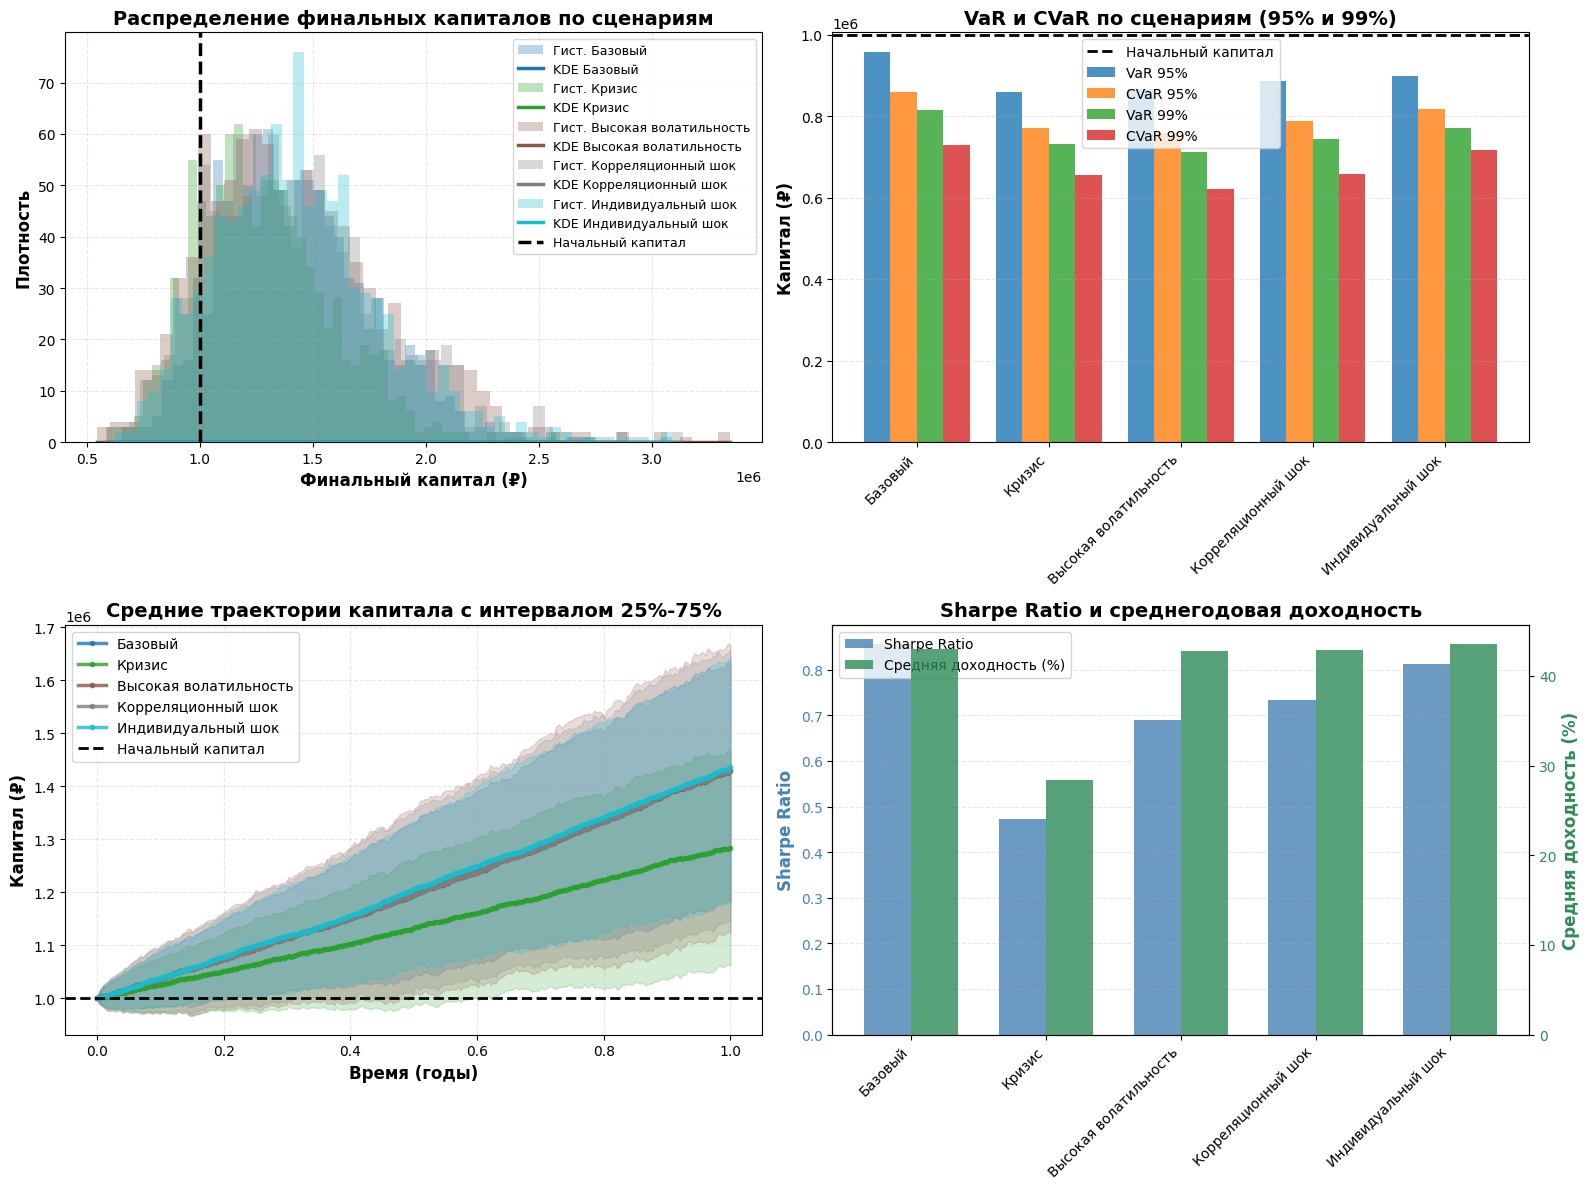


📊 АНАЛИЗ РАСШИРЕННЫХ СТРЕСС-СЦЕНАРИЕВ:


                            СРАВНЕНИЕ СТРЕСС-СЦЕНАРИЕВ                           
Метрика                           Чёрный лебедь      Бычий рынок  Крах волатильно
---------------------------------------------------------------------------------
Средний финальный капитал                 1.20M            1.70M            1.43M
Медианный финальный капитал               1.17M            1.65M            1.41M
Средняя доходность                       20.13%           69.90%           43.37%
Волатильность                            32.19%           42.15%           26.91%
Sharpe Ratio                             0.1923           1.3275           1.0939
VaR 95%                                 761,718            1.09M            1.03M
CVaR 95%                                682,171          979,551          957,952
VaR 99%                                 619,817          922,816          940,313
CVaR 99%                                562,858         

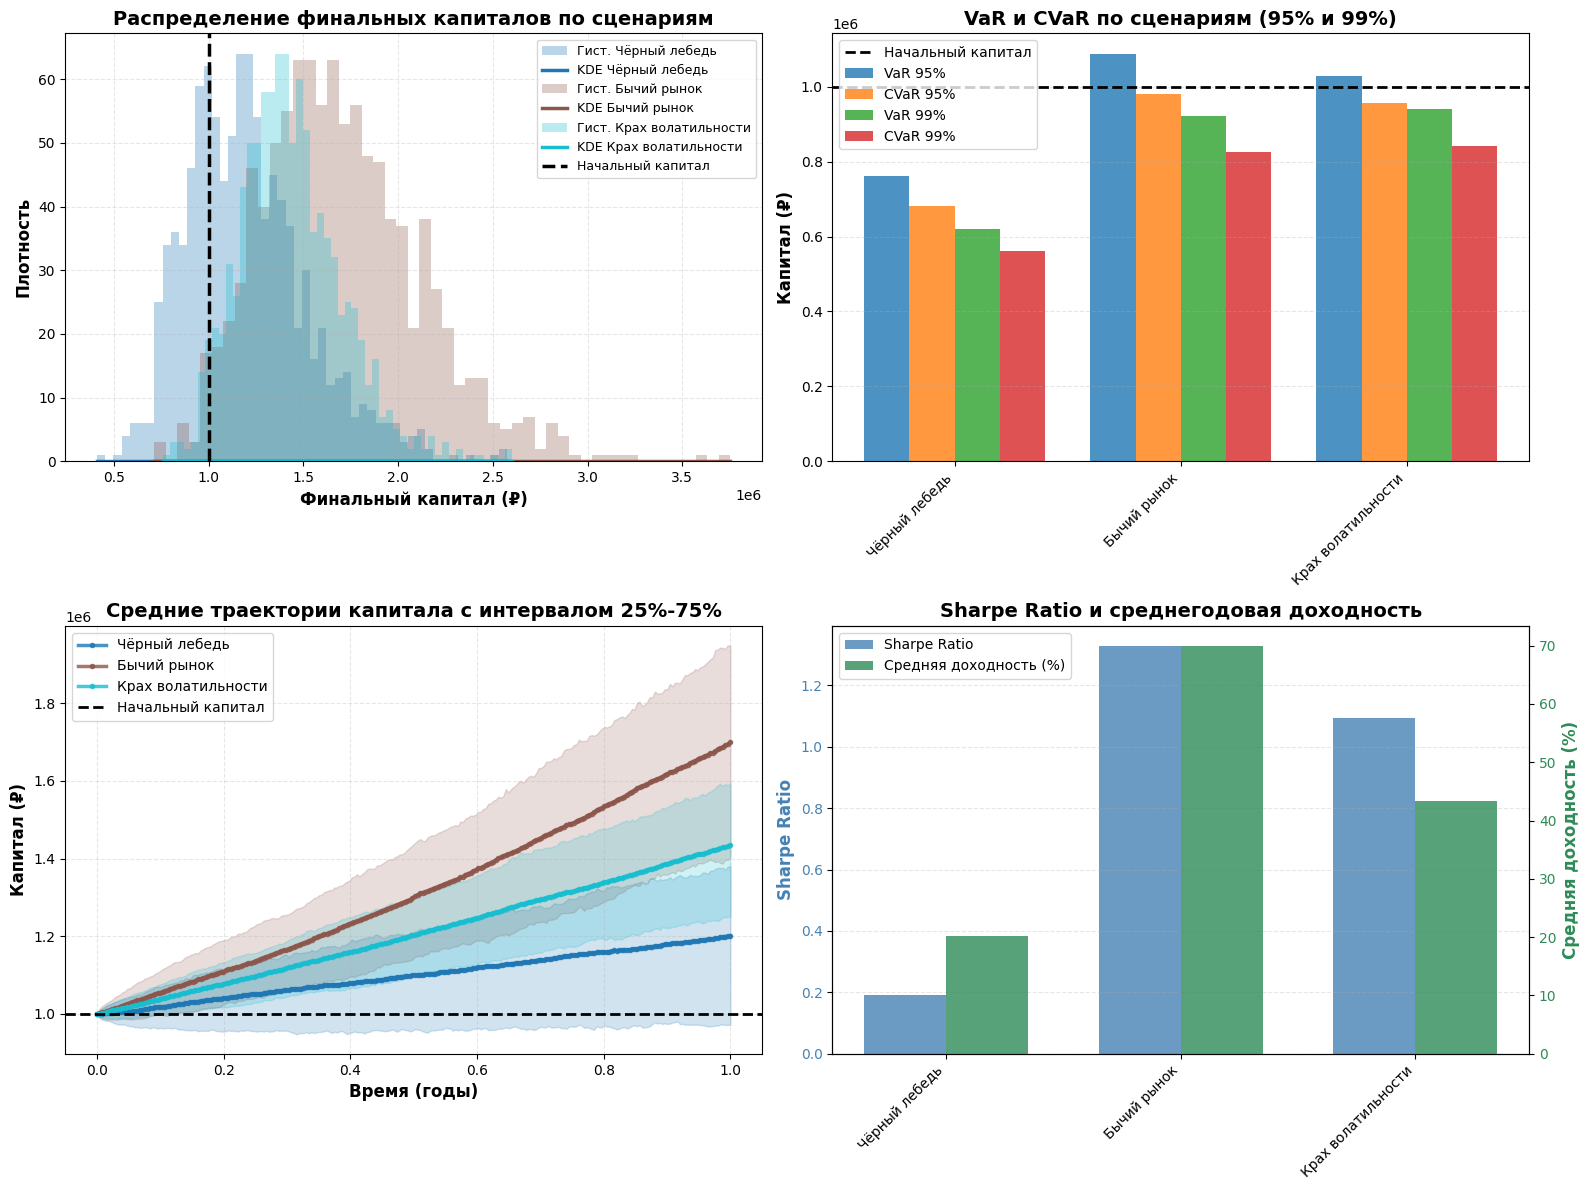


📊 АНАЛИЗ ВРЕМЕННЫХ ГОРИЗОНТОВ:


                                    СРАВНЕНИЕ СТРЕСС-СЦЕНАРИЕВ                                    
Метрика                         Горизонт: 1 мес  Горизонт: 3 мес  Горизонт: 1 год  Горизонт: 3 год
--------------------------------------------------------------------------------------------------
Средний финальный капитал                 1.03M            1.09M            1.43M            2.96M
Медианный финальный капитал               1.03M            1.08M            1.39M            2.71M
Средняя доходность                      103.79%           54.24%           43.03%           40.74%
Волатильность                           218.36%           83.90%           34.00%           20.20%
Sharpe Ratio                             0.4115           0.4804           0.8558           1.3266
VaR 95%                                 912,745          886,348          958,412            1.33M
CVaR 95%                                883,367          848,326          8

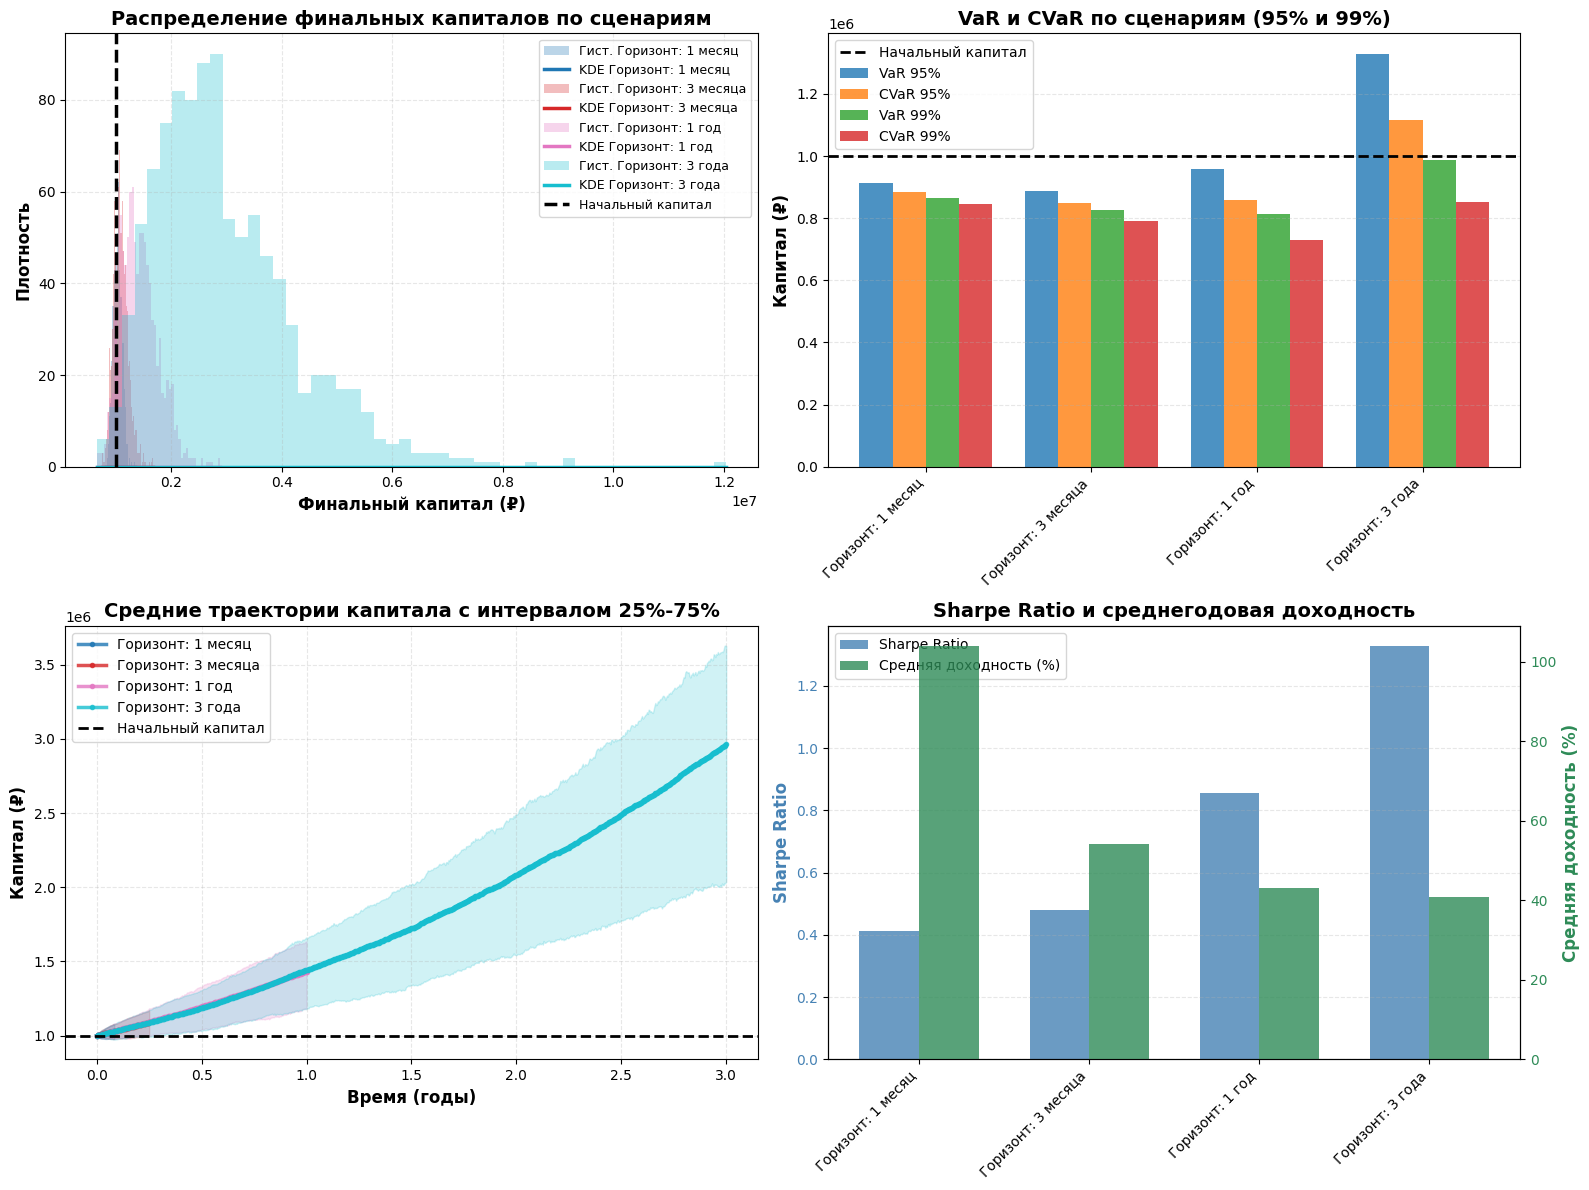

Всего проведено стресс-тестов: 12
Результаты доступны в переменной 'all_stress_results'


In [ ]:
# =============================================================================
# БЛОК СТРЕСС-8: СВОДНЫЙ АНАЛИЗ И ВИЗУАЛИЗАЦИЯ
# =============================================================================
"""
НАЗНАЧЕНИЕ:
-----------
Генерирует итоговые таблицы и графики для всех запущенных стресс-тестов.

ВЫВОДИТ:
--------
1. Сравнительные таблицы для каждой группы сценариев
2. Графические визуализации
"""

print("\n" + "=" * 100)
print("БЛОК СТРЕСС-8: СВОДНЫЙ АНАЛИЗ И ВИЗУАЛИЗАЦИЯ")
print("=" * 100 + "\n")

# 1. БАЗОВЫЕ СЦЕНАРИИ
print("📊 АНАЛИЗ БАЗОВЫХ СТРЕСС-СЦЕНАРИЕВ:\n")
stress_simulator.compare_scenarios(basic_stress_results)
stress_simulator.visualize_comparison(basic_stress_results)

# 2. РАСШИРЕННЫЕ СЦЕНАРИИ
print("\n📊 АНАЛИЗ РАСШИРЕННЫХ СТРЕСС-СЦЕНАРИЕВ:\n")
stress_simulator.compare_scenarios(extended_stress_results)
stress_simulator.visualize_comparison(extended_stress_results)

# 3. ВРЕМЕННЫЕ ГОРИЗОНТЫ
print("\n📊 АНАЛИЗ ВРЕМЕННЫХ ГОРИЗОНТОВ:\n")
stress_simulator.compare_scenarios(horizon_results)
stress_simulator.visualize_comparison(horizon_results)

# Сохранение результатов в переменные для дальнейшего использования
all_stress_results = {
    **basic_stress_results,
    **extended_stress_results,
    **horizon_results
}

print(f"Всего проведено стресс-тестов: {len(all_stress_results)}")
print(f"Результаты доступны в переменной 'all_stress_results'")

**Honorable Mention: Решение уравнение Якоба-Гамльтона-Белламана**

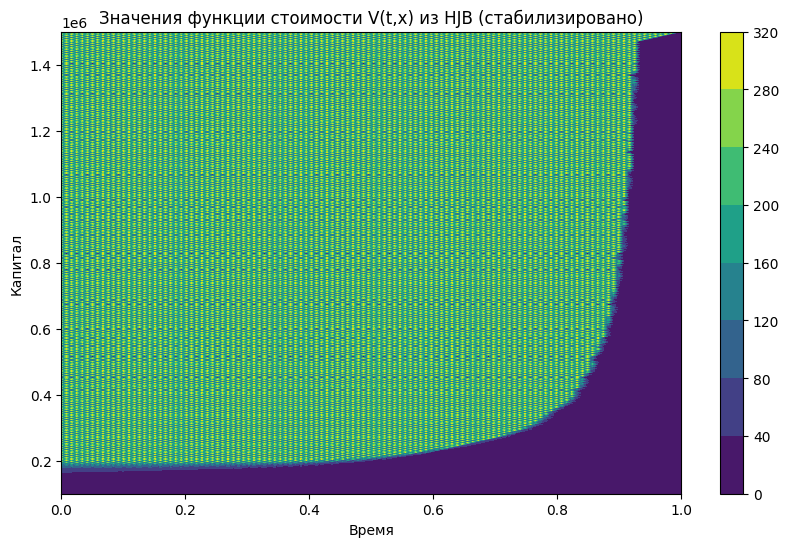

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def solve_hjb(t_grid, x_grid, mu_portfolio, sigma_portfolio, r, gamma):
    """
    Численно решает HJB для данного портфеля с логарифмической функцией полезности (utility).
    - t_grid: сетка по времени (например, 0...1 год, шаг dt)
    - x_grid: сетка по капиталу (минимал. — банкротство, максимал. — богач)
    - mu_portfolio: ожидаемая доходность портфеля (может быть константа или массив по времени)
    - sigma_portfolio: ожидаемая волатильность портфеля (константа или динамика)
    - r: безрисковая ставка (или альтернативная доходность)
    - gamma: коэффициент относительной неприятия риска (в данном коде не используется — логарифмическая утилита)

    Возвращает:
    - V: двумерный массив размерности (Nt, Nx), где V[i, j] — стоимость утилиты в момент времени t_i и при капитале x_j
    """

    Nt = len(t_grid)
    Nx = len(x_grid)
    V = np.zeros((Nt, Nx))  # Массив для хранения значений функции стоимости

    # Граничные условия:
    # - V[:, 0]: минимальный капитал (банкротство) — логарифм (устойчивость)
    V[:, 0] = np.log(x_grid[0] + 1e-10)
    # - V[-1, :]: конечное значение на последнем шаге по времени — логарифм капитала
    V[-1, :] = np.log(x_grid + 1e-10)

    # Шаги сетки
    dt = t_grid[1] - t_grid[0]
    dx = x_grid[1] - x_grid[0]

    # Пределы для стабилизации (от "плохих" значений при интегрировании)
    V_min = np.log(np.min(x_grid) + 1e-10)
    V_max = np.log(np.max(x_grid) + 1e-10) * 20

    # Численное обратное интегрирование по времени (backward in time)
    for i in reversed(range(Nt - 1)):
        mu = mu_portfolio[i]
        sigma = sigma_portfolio[i]
        for j in range(1, Nx - 1):
            # Производные по капиталу — конечные разности
            dVdx = (V[i+1, j+1] - V[i+1, j-1]) / (2*dx)
            d2Vdx2 = (V[i+1, j+1] - 2*V[i+1, j] + V[i+1, j-1]) / (dx**2)
            # Термы уравнения HJB:
            term1 = mu * x_grid[j] * dVdx
            term2 = 0.5 * (sigma ** 2) * (x_grid[j] ** 2) * d2Vdx2
            term3 = r * V[i+1, j]
            # Основная формула "шага" интегрирования
            V[i, j] = V[i+1, j] + dt * (term1 + term2 - term3)
            # Стабилизирующие ограничения на плохие значения
            if not np.isfinite(V[i, j]):
                V[i, j] = V_min
            V[i, j] = np.clip(V[i, j], V_min, V_max)
        # Граничные значения:
        V[i, 0] = V_min
        V[i, -1] = V_max
    return V

def plot_value_function(t_grid, x_grid, V):
    """
    Визуализация функции стоимости V(t, x)
    """
    plt.figure(figsize=(10, 6))
    T, X = np.meshgrid(t_grid, x_grid, indexing='ij')
    cp = plt.contourf(T, X, V, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel('Время')
    plt.ylabel('Капитал')
    plt.title('Значения функции стоимости V(t,x) из HJB (стабилизировано)')
    plt.show()

# ---------------------------------------
# Пример параметров/вызова функции:
t_grid = np.linspace(0, 1, 120)            # Сетка по времени — 1 год, 120 узлов
x_grid = np.linspace(1e5, 1.5e6, 400)      # Сетка по капиталу — от 100 тыс. до 1.5 млн
mu_portfolio = np.full(len(t_grid), 0.07)  # Ожидаемая доходность портфеля — 7% годовых
sigma_portfolio = np.full(len(t_grid), 0.2) # Волатильность портфеля — 20% годовых
r = 0.03
gamma = 3.0

# Решение и визуализация
V = solve_hjb(t_grid, x_grid, mu_portfolio, sigma_portfolio, r, gamma)
plot_value_function(t_grid, x_grid, V)

**CHANGELOG**

v1.1
добавлен backtestings VaR (исторический и симуляции Монте-Карло)

исправлены ошибки в расчетах формулы Мертона, логарифмических доходностей и коэффициента шарпа

добавлены расчеты ассиметрии и куртозиса для оценки каждого из активов портфеля

убраны расчеты изменчивости портфеля в зависимости от риск-аверсии из-за отсутствия коротких продаж



v. 1.2
исправлены графики в блоке 2.1: теперь корреляционная матрица вмещает больше активов, куртозис также считается по всем активам

исправлена ошибка в блоке 2.2, из-за которой garch брал в модель активы с неадекватной волатильностью.

todo:
исправить ошибку загрузки дивидендных доходностей с MOEX API, чтобы они были адекватными
добавить расчет волатилньости через implied volatility